In [1]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%cd ../code
from model import Model, ModelGamma

%cd ../notebooks

/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/code
/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/notebooks


In [2]:
#Load data
start_date = datetime(2020, 10, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [3]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,time series values, number of geo_values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1, time series values, number of geo_values)
Y = tf.cast(Y, dtype=tf.float32)

In [28]:
#Initialize model without filter bank

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
#kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
lr = 0.1

model_a = ModelGamma(
    p = p, 
    m = m,
    #kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam=10,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_A_PATH = "model_a.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_A_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_a.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [29]:
#Training
hist = model_a.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
   epochs = 10000,
)

Epoch 1/100000
1/1 [==============================] - 0s 128ms/step - MSE: 15580805.0000
Epoch 2/100000
1/1 [==============================] - 0s 20ms/step - MSE: 15580626.0000
Epoch 3/100000
1/1 [==============================] - 0s 22ms/step - MSE: 15580399.0000
Epoch 4/100000
1/1 [==============================] - 0s 20ms/step - MSE: 15580110.0000
Epoch 5/100000
1/1 [==============================] - 0s 20ms/step - MSE: 15579735.0000
Epoch 6/100000
1/1 [==============================] - 0s 19ms/step - MSE: 15579231.0000
Epoch 7/100000
1/1 [==============================] - 0s 20ms/step - MSE: 15578547.0000
Epoch 8/100000
1/1 [==============================] - 0s 21ms/step - MSE: 15577595.0000
Epoch 9/100000
1/1 [==============================] - 0s 20ms/step - MSE: 15576236.0000
Epoch 10/100000
1/1 [==============================] - 0s 19ms/step - MSE: 15574238.0000
Epoch 11/100000
1/1 [==============================] - 0s 21ms/step - MSE: 15571219.0000
Epoch 12/100000
1/1 [========

1/1 [==============================] - 0s 510us/step - MSE: 12348709.0000
Epoch 93/100000
1/1 [==============================] - 0s 519us/step - MSE: 12349640.0000
Epoch 94/100000
1/1 [==============================] - 0s 472us/step - MSE: 12347454.0000
Epoch 95/100000
1/1 [==============================] - 0s 620us/step - MSE: 12346614.0000
Epoch 96/100000
1/1 [==============================] - 0s 781us/step - MSE: 12345903.0000
Epoch 97/100000
1/1 [==============================] - 0s 516us/step - MSE: 12343100.0000
Epoch 98/100000
1/1 [==============================] - 0s 584us/step - MSE: 12341027.0000
Epoch 99/100000
1/1 [==============================] - 0s 590us/step - MSE: 12340985.0000
Epoch 100/100000
1/1 [==============================] - 0s 898us/step - MSE: 12340602.0000
Epoch 101/100000
1/1 [==============================] - 0s 491us/step - MSE: 12339969.0000
Epoch 102/100000
1/1 [==============================] - 0s 922us/step - MSE: 12338773.0000
Epoch 103/100000
1/1 [=

1/1 [==============================] - 0s 497us/step - MSE: 12202935.0000
Epoch 183/100000
1/1 [==============================] - 0s 500us/step - MSE: 12151635.0000
Epoch 184/100000
1/1 [==============================] - 0s 543us/step - MSE: 12143547.0000
Epoch 185/100000
1/1 [==============================] - 0s 582us/step - MSE: 12150850.0000
Epoch 186/100000
1/1 [==============================] - 0s 538us/step - MSE: 12152767.0000
Epoch 187/100000
1/1 [==============================] - 0s 486us/step - MSE: 12147193.0000
Epoch 188/100000
1/1 [==============================] - 0s 512us/step - MSE: 12134214.0000
Epoch 189/100000
1/1 [==============================] - 0s 503us/step - MSE: 12113665.0000
Epoch 190/100000
1/1 [==============================] - 0s 516us/step - MSE: 12086382.0000
Epoch 191/100000
1/1 [==============================] - 0s 467us/step - MSE: 12058603.0000
Epoch 192/100000
1/1 [==============================] - 0s 611us/step - MSE: 12039153.0000
Epoch 193/100000

1/1 [==============================] - 0s 528us/step - MSE: 11083080.0000
Epoch 273/100000
1/1 [==============================] - 0s 501us/step - MSE: 11059345.0000
Epoch 274/100000
1/1 [==============================] - 0s 547us/step - MSE: 11028286.0000
Epoch 275/100000
1/1 [==============================] - 0s 1ms/step - MSE: 11055438.0000
Epoch 276/100000
1/1 [==============================] - 0s 553us/step - MSE: 11067628.0000
Epoch 277/100000
1/1 [==============================] - 0s 585us/step - MSE: 11047773.0000
Epoch 278/100000
1/1 [==============================] - 0s 574us/step - MSE: 11032918.0000
Epoch 279/100000
1/1 [==============================] - 0s 602us/step - MSE: 11050733.0000
Epoch 280/100000
1/1 [==============================] - 0s 543us/step - MSE: 11046028.0000
Epoch 281/100000
1/1 [==============================] - 0s 562us/step - MSE: 11026280.0000
Epoch 282/100000
1/1 [==============================] - 0s 490us/step - MSE: 11038421.0000
Epoch 283/100000
1

1/1 [==============================] - 0s 609us/step - MSE: 11062151.0000
Epoch 363/100000
1/1 [==============================] - 0s 568us/step - MSE: 11061136.0000
Epoch 364/100000
1/1 [==============================] - 0s 465us/step - MSE: 11058677.0000
Epoch 365/100000
1/1 [==============================] - 0s 513us/step - MSE: 11056148.0000
Epoch 366/100000
1/1 [==============================] - 0s 546us/step - MSE: 11051718.0000
Epoch 367/100000
1/1 [==============================] - 0s 723us/step - MSE: 11046537.0000
Epoch 368/100000
1/1 [==============================] - 0s 551us/step - MSE: 11066267.0000
Epoch 369/100000
1/1 [==============================] - 0s 684us/step - MSE: 11050914.0000
Epoch 370/100000
1/1 [==============================] - 0s 998us/step - MSE: 11052864.0000
Epoch 371/100000
1/1 [==============================] - 0s 556us/step - MSE: 11052068.0000
Epoch 372/100000
1/1 [==============================] - 0s 581us/step - MSE: 11050583.0000
Epoch 373/100000

1/1 [==============================] - 0s 656us/step - MSE: 10860339.0000
Epoch 453/100000
1/1 [==============================] - 0s 595us/step - MSE: 10860170.0000
Epoch 454/100000
1/1 [==============================] - 0s 537us/step - MSE: 10859978.0000
Epoch 455/100000
1/1 [==============================] - 0s 482us/step - MSE: 10859589.0000
Epoch 456/100000
1/1 [==============================] - 0s 535us/step - MSE: 10859054.0000
Epoch 457/100000
1/1 [==============================] - 0s 861us/step - MSE: 10858557.0000
Epoch 458/100000
1/1 [==============================] - 0s 767us/step - MSE: 10858230.0000
Epoch 459/100000
1/1 [==============================] - 0s 677us/step - MSE: 10858025.0000
Epoch 460/100000
1/1 [==============================] - 0s 584us/step - MSE: 10857790.0000
Epoch 461/100000
1/1 [==============================] - 0s 826us/step - MSE: 10857417.0000
Epoch 462/100000
1/1 [==============================] - 0s 672us/step - MSE: 10857118.0000
Epoch 463/100000

1/1 [==============================] - 0s 547us/step - MSE: 10564638.0000
Epoch 543/100000
1/1 [==============================] - 0s 637us/step - MSE: 10580659.0000
Epoch 544/100000
1/1 [==============================] - 0s 642us/step - MSE: 10589572.0000
Epoch 545/100000
1/1 [==============================] - 0s 605us/step - MSE: 10586107.0000
Epoch 546/100000
1/1 [==============================] - 0s 608us/step - MSE: 10572460.0000
Epoch 547/100000
1/1 [==============================] - 0s 581us/step - MSE: 10557867.0000
Epoch 548/100000
1/1 [==============================] - 0s 497us/step - MSE: 10563406.0000
Epoch 549/100000
1/1 [==============================] - 0s 527us/step - MSE: 10574685.0000
Epoch 550/100000
1/1 [==============================] - 0s 579us/step - MSE: 10555611.0000
Epoch 551/100000
1/1 [==============================] - 0s 572us/step - MSE: 10552326.0000
Epoch 552/100000
1/1 [==============================] - 0s 673us/step - MSE: 10558226.0000
Epoch 553/100000

1/1 [==============================] - 0s 478us/step - MSE: 10175608.0000
Epoch 633/100000
1/1 [==============================] - 0s 558us/step - MSE: 10194867.0000
Epoch 634/100000
1/1 [==============================] - 0s 715us/step - MSE: 10199510.0000
Epoch 635/100000
1/1 [==============================] - 0s 528us/step - MSE: 10172244.0000
Epoch 636/100000
1/1 [==============================] - 0s 574us/step - MSE: 10163275.0000
Epoch 637/100000
1/1 [==============================] - 0s 503us/step - MSE: 10169691.0000
Epoch 638/100000
1/1 [==============================] - 0s 547us/step - MSE: 10174969.0000
Epoch 639/100000
1/1 [==============================] - 0s 618us/step - MSE: 10177176.0000
Epoch 640/100000
1/1 [==============================] - 0s 494us/step - MSE: 10177666.0000
Epoch 641/100000
1/1 [==============================] - 0s 634us/step - MSE: 10176275.0000
Epoch 642/100000
1/1 [==============================] - 0s 558us/step - MSE: 10173042.0000
Epoch 643/100000

1/1 [==============================] - 0s 563us/step - MSE: 10122258.0000
Epoch 723/100000
1/1 [==============================] - 0s 502us/step - MSE: 10121595.0000
Epoch 724/100000
1/1 [==============================] - 0s 657us/step - MSE: 10120940.0000
Epoch 725/100000
1/1 [==============================] - 0s 600us/step - MSE: 10120291.0000
Epoch 726/100000
1/1 [==============================] - 0s 650us/step - MSE: 10119716.0000
Epoch 727/100000
1/1 [==============================] - 0s 465us/step - MSE: 10119132.0000
Epoch 728/100000
1/1 [==============================] - 0s 538us/step - MSE: 10118861.0000
Epoch 729/100000
1/1 [==============================] - 0s 516us/step - MSE: 10118295.0000
Epoch 730/100000
1/1 [==============================] - 0s 558us/step - MSE: 10118756.0000
Epoch 731/100000
1/1 [==============================] - 0s 491us/step - MSE: 10117480.0000
Epoch 732/100000
1/1 [==============================] - 0s 499us/step - MSE: 10118056.0000
Epoch 733/100000

1/1 [==============================] - 0s 578us/step - MSE: 9379107.0000
Epoch 813/100000
1/1 [==============================] - 0s 519us/step - MSE: 9355718.0000
Epoch 814/100000
1/1 [==============================] - 0s 530us/step - MSE: 9360839.0000
Epoch 815/100000
1/1 [==============================] - 0s 509us/step - MSE: 9370147.0000
Epoch 816/100000
1/1 [==============================] - 0s 629us/step - MSE: 9344830.0000
Epoch 817/100000
1/1 [==============================] - 0s 609us/step - MSE: 9332606.0000
Epoch 818/100000
1/1 [==============================] - 0s 566us/step - MSE: 9336511.0000
Epoch 819/100000
1/1 [==============================] - 0s 468us/step - MSE: 9333542.0000
Epoch 820/100000
1/1 [==============================] - 0s 646us/step - MSE: 9318655.0000
Epoch 821/100000
1/1 [==============================] - 0s 581us/step - MSE: 9300556.0000
Epoch 822/100000
1/1 [==============================] - 0s 721us/step - MSE: 9295036.0000
Epoch 823/100000
1/1 [=====

1/1 [==============================] - 0s 610us/step - MSE: 7932870.0000
Epoch 904/100000
1/1 [==============================] - 0s 555us/step - MSE: 7931272.0000
Epoch 905/100000
1/1 [==============================] - 0s 754us/step - MSE: 7926280.5000
Epoch 906/100000
1/1 [==============================] - 0s 690us/step - MSE: 7923080.0000
Epoch 907/100000
1/1 [==============================] - 0s 807us/step - MSE: 7920892.5000
Epoch 908/100000
1/1 [==============================] - 0s 878us/step - MSE: 7917544.0000
Epoch 909/100000
1/1 [==============================] - 0s 612us/step - MSE: 7912166.5000
Epoch 910/100000
1/1 [==============================] - 0s 813us/step - MSE: 7907775.5000
Epoch 911/100000
1/1 [==============================] - 0s 675us/step - MSE: 7903766.0000
Epoch 912/100000
1/1 [==============================] - 0s 573us/step - MSE: 7898373.5000
Epoch 913/100000
1/1 [==============================] - 0s 658us/step - MSE: 7891404.0000
Epoch 914/100000
1/1 [=====

1/1 [==============================] - 0s 615us/step - MSE: 6928287.5000
Epoch 995/100000
1/1 [==============================] - 0s 560us/step - MSE: 6923159.5000
Epoch 996/100000
1/1 [==============================] - 0s 606us/step - MSE: 6917729.0000
Epoch 997/100000
1/1 [==============================] - 0s 483us/step - MSE: 6911886.5000
Epoch 998/100000
1/1 [==============================] - 0s 473us/step - MSE: 6905762.0000
Epoch 999/100000
1/1 [==============================] - 0s 551us/step - MSE: 6898235.5000
Epoch 1000/100000
1/1 [==============================] - 0s 535us/step - MSE: 6889959.0000
Epoch 1001/100000
1/1 [==============================] - 0s 529us/step - MSE: 6880564.5000
Epoch 1002/100000
1/1 [==============================] - 0s 539us/step - MSE: 6870135.5000
Epoch 1003/100000
1/1 [==============================] - 0s 812us/step - MSE: 6857535.0000
Epoch 1004/100000
1/1 [==============================] - 0s 595us/step - MSE: 6842958.0000
Epoch 1005/100000
1/1 

1/1 [==============================] - 0s 590us/step - MSE: 5644384.0000
Epoch 1085/100000
1/1 [==============================] - 0s 696us/step - MSE: 5642248.5000
Epoch 1086/100000
1/1 [==============================] - 0s 629us/step - MSE: 5639328.0000
Epoch 1087/100000
1/1 [==============================] - 0s 776us/step - MSE: 5637568.5000
Epoch 1088/100000
1/1 [==============================] - 0s 625us/step - MSE: 5636268.5000
Epoch 1089/100000
1/1 [==============================] - 0s 1ms/step - MSE: 5634613.5000
Epoch 1090/100000
1/1 [==============================] - 0s 819us/step - MSE: 5633882.0000
Epoch 1091/100000
1/1 [==============================] - 0s 669us/step - MSE: 5632955.5000
Epoch 1092/100000
1/1 [==============================] - 0s 685us/step - MSE: 5632203.0000
Epoch 1093/100000
1/1 [==============================] - 0s 537us/step - MSE: 5631641.5000
Epoch 1094/100000
1/1 [==============================] - 0s 536us/step - MSE: 5631401.0000
Epoch 1095/100000
1

1/1 [==============================] - 0s 715us/step - MSE: 5064672.5000
Epoch 1175/100000
1/1 [==============================] - 0s 506us/step - MSE: 5067224.0000
Epoch 1176/100000
1/1 [==============================] - 0s 475us/step - MSE: 5065030.5000
Epoch 1177/100000
1/1 [==============================] - 0s 556us/step - MSE: 5063406.5000
Epoch 1178/100000
1/1 [==============================] - 0s 666us/step - MSE: 5062016.0000
Epoch 1179/100000
1/1 [==============================] - 0s 656us/step - MSE: 5063592.5000
Epoch 1180/100000
1/1 [==============================] - 0s 525us/step - MSE: 5062830.0000
Epoch 1181/100000
1/1 [==============================] - 0s 490us/step - MSE: 5061968.0000
Epoch 1182/100000
1/1 [==============================] - 0s 526us/step - MSE: 5059726.5000
Epoch 1183/100000
1/1 [==============================] - 0s 579us/step - MSE: 5059721.5000
Epoch 1184/100000
1/1 [==============================] - 0s 493us/step - MSE: 5059666.0000
Epoch 1185/100000

1/1 [==============================] - 0s 813us/step - MSE: 5026235.5000
Epoch 1265/100000
1/1 [==============================] - 0s 693us/step - MSE: 5025988.0000
Epoch 1266/100000
1/1 [==============================] - 0s 840us/step - MSE: 5025044.0000
Epoch 1267/100000
1/1 [==============================] - 0s 688us/step - MSE: 5024860.0000
Epoch 1268/100000
1/1 [==============================] - 0s 629us/step - MSE: 5023876.0000
Epoch 1269/100000
1/1 [==============================] - 0s 980us/step - MSE: 5023777.5000
Epoch 1270/100000
1/1 [==============================] - 0s 772us/step - MSE: 5022870.5000
Epoch 1271/100000
1/1 [==============================] - 0s 804us/step - MSE: 5022746.0000
Epoch 1272/100000
1/1 [==============================] - 0s 599us/step - MSE: 5021891.0000
Epoch 1273/100000
1/1 [==============================] - 0s 771us/step - MSE: 5021637.0000
Epoch 1274/100000
1/1 [==============================] - 0s 671us/step - MSE: 5020678.0000
Epoch 1275/100000

1/1 [==============================] - 0s 561us/step - MSE: 4706382.5000
Epoch 1355/100000
1/1 [==============================] - 0s 865us/step - MSE: 4755730.0000
Epoch 1356/100000
1/1 [==============================] - 0s 512us/step - MSE: 4693909.5000
Epoch 1357/100000
1/1 [==============================] - 0s 594us/step - MSE: 4677328.0000
Epoch 1358/100000
1/1 [==============================] - 0s 576us/step - MSE: 4692166.0000
Epoch 1359/100000
1/1 [==============================] - 0s 567us/step - MSE: 4707808.0000
Epoch 1360/100000
1/1 [==============================] - 0s 559us/step - MSE: 4715125.5000
Epoch 1361/100000
1/1 [==============================] - 0s 481us/step - MSE: 4715645.0000
Epoch 1362/100000
1/1 [==============================] - 0s 627us/step - MSE: 4708284.0000
Epoch 1363/100000
1/1 [==============================] - 0s 581us/step - MSE: 4695691.5000
Epoch 1364/100000
1/1 [==============================] - 0s 577us/step - MSE: 4680667.0000
Epoch 1365/100000

1/1 [==============================] - 0s 650us/step - MSE: 4651170.0000
Epoch 1445/100000
1/1 [==============================] - 0s 705us/step - MSE: 4651390.5000
Epoch 1446/100000
1/1 [==============================] - 0s 697us/step - MSE: 4650602.5000
Epoch 1447/100000
1/1 [==============================] - 0s 869us/step - MSE: 4650819.0000
Epoch 1448/100000
1/1 [==============================] - 0s 625us/step - MSE: 4650032.0000
Epoch 1449/100000
1/1 [==============================] - 0s 669us/step - MSE: 4650250.0000
Epoch 1450/100000
1/1 [==============================] - 0s 616us/step - MSE: 4649473.5000
Epoch 1451/100000
1/1 [==============================] - 0s 801us/step - MSE: 4649694.5000
Epoch 1452/100000
1/1 [==============================] - 0s 627us/step - MSE: 4648918.5000
Epoch 1453/100000
1/1 [==============================] - 0s 506us/step - MSE: 4649138.5000
Epoch 1454/100000
1/1 [==============================] - 0s 474us/step - MSE: 4648370.0000
Epoch 1455/100000

1/1 [==============================] - 0s 515us/step - MSE: 4622039.0000
Epoch 1535/100000
1/1 [==============================] - 0s 488us/step - MSE: 4621887.0000
Epoch 1536/100000
1/1 [==============================] - 0s 646us/step - MSE: 4620670.5000
Epoch 1537/100000
1/1 [==============================] - 0s 503us/step - MSE: 4620318.0000
Epoch 1538/100000
1/1 [==============================] - 0s 506us/step - MSE: 4618847.0000
Epoch 1539/100000
1/1 [==============================] - 0s 530us/step - MSE: 4618028.5000
Epoch 1540/100000
1/1 [==============================] - 0s 526us/step - MSE: 4615826.5000
Epoch 1541/100000
1/1 [==============================] - 0s 563us/step - MSE: 4613557.0000
Epoch 1542/100000
1/1 [==============================] - 0s 503us/step - MSE: 4608285.5000
Epoch 1543/100000
1/1 [==============================] - 0s 589us/step - MSE: 4597652.5000
Epoch 1544/100000
1/1 [==============================] - 0s 677us/step - MSE: 4562971.0000
Epoch 1545/100000

1/1 [==============================] - 0s 20ms/step - MSE: 4495459.0000
Epoch 1625/100000
1/1 [==============================] - 0s 20ms/step - MSE: 4486530.0000
Epoch 1626/100000
1/1 [==============================] - 0s 21ms/step - MSE: 4475257.0000
Epoch 1627/100000
1/1 [==============================] - 0s 21ms/step - MSE: 4463339.0000
Epoch 1628/100000
1/1 [==============================] - 0s 19ms/step - MSE: 4448308.5000
Epoch 1629/100000
1/1 [==============================] - 0s 19ms/step - MSE: 4431711.0000
Epoch 1630/100000
1/1 [==============================] - 0s 20ms/step - MSE: 4410603.5000
Epoch 1631/100000
1/1 [==============================] - 0s 21ms/step - MSE: 4386126.0000
Epoch 1632/100000
1/1 [==============================] - 0s 21ms/step - MSE: 4354403.0000
Epoch 1633/100000
1/1 [==============================] - 0s 21ms/step - MSE: 4315365.0000
Epoch 1634/100000
1/1 [==============================] - 0s 20ms/step - MSE: 4262931.0000
Epoch 1635/100000
1/1 [=====

1/1 [==============================] - 0s 573us/step - MSE: 4619955.5000
Epoch 1715/100000
1/1 [==============================] - 0s 510us/step - MSE: 4620386.0000
Epoch 1716/100000
1/1 [==============================] - 0s 554us/step - MSE: 4619712.0000
Epoch 1717/100000
1/1 [==============================] - 0s 596us/step - MSE: 4620134.5000
Epoch 1718/100000
1/1 [==============================] - 0s 549us/step - MSE: 4619444.5000
Epoch 1719/100000
1/1 [==============================] - 0s 495us/step - MSE: 4619853.5000
Epoch 1720/100000
1/1 [==============================] - 0s 464us/step - MSE: 4619157.5000
Epoch 1721/100000
1/1 [==============================] - 0s 654us/step - MSE: 4619552.5000
Epoch 1722/100000
1/1 [==============================] - 0s 538us/step - MSE: 4618862.0000
Epoch 1723/100000
1/1 [==============================] - 0s 514us/step - MSE: 4619247.5000
Epoch 1724/100000
1/1 [==============================] - 0s 468us/step - MSE: 4618566.5000
Epoch 1725/100000

1/1 [==============================] - 0s 539us/step - MSE: 4608853.0000
Epoch 1805/100000
1/1 [==============================] - 0s 490us/step - MSE: 4609282.5000
Epoch 1806/100000
1/1 [==============================] - 0s 528us/step - MSE: 4608636.5000
Epoch 1807/100000
1/1 [==============================] - 0s 740us/step - MSE: 4609066.5000
Epoch 1808/100000
1/1 [==============================] - 0s 508us/step - MSE: 4608414.0000
Epoch 1809/100000
1/1 [==============================] - 0s 512us/step - MSE: 4608837.5000
Epoch 1810/100000
1/1 [==============================] - 0s 498us/step - MSE: 4608181.5000
Epoch 1811/100000
1/1 [==============================] - 0s 504us/step - MSE: 4608597.0000
Epoch 1812/100000
1/1 [==============================] - 0s 606us/step - MSE: 4607946.0000
Epoch 1813/100000
1/1 [==============================] - 0s 543us/step - MSE: 4608361.5000
Epoch 1814/100000
1/1 [==============================] - 0s 525us/step - MSE: 4607715.5000
Epoch 1815/100000

1/1 [==============================] - 0s 666us/step - MSE: 4599281.0000
Epoch 1895/100000
1/1 [==============================] - 0s 644us/step - MSE: 4599723.5000
Epoch 1896/100000
1/1 [==============================] - 0s 569us/step - MSE: 4599095.0000
Epoch 1897/100000
1/1 [==============================] - 0s 538us/step - MSE: 4599542.5000
Epoch 1898/100000
1/1 [==============================] - 0s 741us/step - MSE: 4598913.0000
Epoch 1899/100000
1/1 [==============================] - 0s 603us/step - MSE: 4599367.5000
Epoch 1900/100000
1/1 [==============================] - 0s 622us/step - MSE: 4598734.0000
Epoch 1901/100000
1/1 [==============================] - 0s 711us/step - MSE: 4599195.0000
Epoch 1902/100000
1/1 [==============================] - 0s 679us/step - MSE: 4598554.0000
Epoch 1903/100000
1/1 [==============================] - 0s 632us/step - MSE: 4599015.5000
Epoch 1904/100000
1/1 [==============================] - 0s 483us/step - MSE: 4598371.0000
Epoch 1905/100000

1/1 [==============================] - 0s 551us/step - MSE: 4591418.0000
Epoch 1985/100000
1/1 [==============================] - 0s 713us/step - MSE: 4591833.5000
Epoch 1986/100000
1/1 [==============================] - 0s 572us/step - MSE: 4591346.0000
Epoch 1987/100000
1/1 [==============================] - 0s 863us/step - MSE: 4591733.5000
Epoch 1988/100000
1/1 [==============================] - 0s 575us/step - MSE: 4591249.0000
Epoch 1989/100000
1/1 [==============================] - 0s 511us/step - MSE: 4591599.5000
Epoch 1990/100000
1/1 [==============================] - 0s 516us/step - MSE: 4591095.0000
Epoch 1991/100000
1/1 [==============================] - 0s 669us/step - MSE: 4591414.0000
Epoch 1992/100000
1/1 [==============================] - 0s 766us/step - MSE: 4590869.5000
Epoch 1993/100000
1/1 [==============================] - 0s 554us/step - MSE: 4591175.0000
Epoch 1994/100000
1/1 [==============================] - 0s 510us/step - MSE: 4590585.5000
Epoch 1995/100000

1/1 [==============================] - 0s 591us/step - MSE: 4583748.5000
Epoch 2075/100000
1/1 [==============================] - 0s 519us/step - MSE: 4584217.5000
Epoch 2076/100000
1/1 [==============================] - 0s 574us/step - MSE: 4583578.0000
Epoch 2077/100000
1/1 [==============================] - 0s 578us/step - MSE: 4584049.0000
Epoch 2078/100000
1/1 [==============================] - 0s 471us/step - MSE: 4583410.0000
Epoch 2079/100000
1/1 [==============================] - 0s 679us/step - MSE: 4583878.0000
Epoch 2080/100000
1/1 [==============================] - 0s 557us/step - MSE: 4583239.5000
Epoch 2081/100000
1/1 [==============================] - 0s 517us/step - MSE: 4583703.5000
Epoch 2082/100000
1/1 [==============================] - 0s 525us/step - MSE: 4583070.5000
Epoch 2083/100000
1/1 [==============================] - 0s 569us/step - MSE: 4583532.5000
Epoch 2084/100000
1/1 [==============================] - 0s 600us/step - MSE: 4582909.0000
Epoch 2085/100000

1/1 [==============================] - 0s 503us/step - MSE: 4580373.5000
Epoch 2165/100000
1/1 [==============================] - 0s 483us/step - MSE: 4579548.5000
Epoch 2166/100000
1/1 [==============================] - 0s 889us/step - MSE: 4579009.5000
Epoch 2167/100000
1/1 [==============================] - 0s 524us/step - MSE: 4578421.5000
Epoch 2168/100000
1/1 [==============================] - 0s 463us/step - MSE: 4577459.0000
Epoch 2169/100000
1/1 [==============================] - 0s 536us/step - MSE: 4577482.5000
Epoch 2170/100000
1/1 [==============================] - 0s 484us/step - MSE: 4576689.5000
Epoch 2171/100000
1/1 [==============================] - 0s 545us/step - MSE: 4577077.0000
Epoch 2172/100000
1/1 [==============================] - 0s 502us/step - MSE: 4576508.5000
Epoch 2173/100000
1/1 [==============================] - 0s 479us/step - MSE: 4577076.5000
Epoch 2174/100000
1/1 [==============================] - 0s 714us/step - MSE: 4576612.0000
Epoch 2175/100000

1/1 [==============================] - 0s 478us/step - MSE: 4571197.0000
Epoch 2255/100000
1/1 [==============================] - 0s 436us/step - MSE: 4571675.0000
Epoch 2256/100000
1/1 [==============================] - 0s 437us/step - MSE: 4571086.5000
Epoch 2257/100000
1/1 [==============================] - 0s 472us/step - MSE: 4571678.5000
Epoch 2258/100000
1/1 [==============================] - 0s 587us/step - MSE: 4571025.5000
Epoch 2259/100000
1/1 [==============================] - 0s 471us/step - MSE: 4571469.5000
Epoch 2260/100000
1/1 [==============================] - 0s 534us/step - MSE: 4570846.5000
Epoch 2261/100000
1/1 [==============================] - 0s 515us/step - MSE: 4571332.0000
Epoch 2262/100000
1/1 [==============================] - 0s 618us/step - MSE: 4570782.5000
Epoch 2263/100000
1/1 [==============================] - 0s 640us/step - MSE: 4571265.0000
Epoch 2264/100000
1/1 [==============================] - 0s 536us/step - MSE: 4570672.0000
Epoch 2265/100000

1/1 [==============================] - 0s 546us/step - MSE: 4566451.5000
Epoch 2345/100000
1/1 [==============================] - 0s 489us/step - MSE: 4566930.0000
Epoch 2346/100000
1/1 [==============================] - 0s 518us/step - MSE: 4566511.0000
Epoch 2347/100000
1/1 [==============================] - 0s 605us/step - MSE: 4566956.5000
Epoch 2348/100000
1/1 [==============================] - 0s 501us/step - MSE: 4566568.0000
Epoch 2349/100000
1/1 [==============================] - 0s 601us/step - MSE: 4566955.0000
Epoch 2350/100000
1/1 [==============================] - 0s 522us/step - MSE: 4566560.5000
Epoch 2351/100000
1/1 [==============================] - 0s 509us/step - MSE: 4566879.0000
Epoch 2352/100000
1/1 [==============================] - 0s 603us/step - MSE: 4566432.0000
Epoch 2353/100000
1/1 [==============================] - 0s 845us/step - MSE: 4566705.5000
Epoch 2354/100000
1/1 [==============================] - 0s 708us/step - MSE: 4566180.0000
Epoch 2355/100000

1/1 [==============================] - 0s 564us/step - MSE: 4561334.0000
Epoch 2435/100000
1/1 [==============================] - 0s 551us/step - MSE: 4561785.0000
Epoch 2436/100000
1/1 [==============================] - 0s 575us/step - MSE: 4561199.0000
Epoch 2437/100000
1/1 [==============================] - 0s 620us/step - MSE: 4561660.0000
Epoch 2438/100000
1/1 [==============================] - 0s 520us/step - MSE: 4561074.5000
Epoch 2439/100000
1/1 [==============================] - 0s 494us/step - MSE: 4561545.5000
Epoch 2440/100000
1/1 [==============================] - 0s 641us/step - MSE: 4560964.0000
Epoch 2441/100000
1/1 [==============================] - 0s 670us/step - MSE: 4561443.0000
Epoch 2442/100000
1/1 [==============================] - 0s 485us/step - MSE: 4560865.5000
Epoch 2443/100000
1/1 [==============================] - 0s 473us/step - MSE: 4561348.5000
Epoch 2444/100000
1/1 [==============================] - 0s 491us/step - MSE: 4560776.0000
Epoch 2445/100000

1/1 [==============================] - 0s 587us/step - MSE: 4556954.0000
Epoch 2525/100000
1/1 [==============================] - 0s 567us/step - MSE: 4557442.0000
Epoch 2526/100000
1/1 [==============================] - 0s 470us/step - MSE: 4556865.0000
Epoch 2527/100000
1/1 [==============================] - 0s 539us/step - MSE: 4557358.0000
Epoch 2528/100000
1/1 [==============================] - 0s 493us/step - MSE: 4556787.5000
Epoch 2529/100000
1/1 [==============================] - 0s 553us/step - MSE: 4557289.0000
Epoch 2530/100000
1/1 [==============================] - 0s 525us/step - MSE: 4556727.0000
Epoch 2531/100000
1/1 [==============================] - 0s 489us/step - MSE: 4557246.0000
Epoch 2532/100000
1/1 [==============================] - 0s 488us/step - MSE: 4556697.5000
Epoch 2533/100000
1/1 [==============================] - 0s 485us/step - MSE: 4557248.5000
Epoch 2534/100000
1/1 [==============================] - 0s 665us/step - MSE: 4556719.5000
Epoch 2535/100000

1/1 [==============================] - 0s 476us/step - MSE: 4553454.0000
Epoch 2615/100000
1/1 [==============================] - 0s 666us/step - MSE: 4553798.0000
Epoch 2616/100000
1/1 [==============================] - 0s 512us/step - MSE: 4553178.5000
Epoch 2617/100000
1/1 [==============================] - 0s 577us/step - MSE: 4553578.0000
Epoch 2618/100000
1/1 [==============================] - 0s 535us/step - MSE: 4552966.5000
Epoch 2619/100000
1/1 [==============================] - 0s 572us/step - MSE: 4553406.0000
Epoch 2620/100000
1/1 [==============================] - 0s 505us/step - MSE: 4552809.5000
Epoch 2621/100000
1/1 [==============================] - 0s 776us/step - MSE: 4553274.0000
Epoch 2622/100000
1/1 [==============================] - 0s 547us/step - MSE: 4552692.0000
Epoch 2623/100000
1/1 [==============================] - 0s 546us/step - MSE: 4553170.0000
Epoch 2624/100000
1/1 [==============================] - 0s 533us/step - MSE: 4552598.0000
Epoch 2625/100000

1/1 [==============================] - 0s 596us/step - MSE: 4549551.5000
Epoch 2705/100000
1/1 [==============================] - 0s 639us/step - MSE: 4550056.5000
Epoch 2706/100000
1/1 [==============================] - 0s 456us/step - MSE: 4549534.5000
Epoch 2707/100000
1/1 [==============================] - 0s 533us/step - MSE: 4550047.0000
Epoch 2708/100000
1/1 [==============================] - 0s 559us/step - MSE: 4549553.0000
Epoch 2709/100000
1/1 [==============================] - 0s 595us/step - MSE: 4550072.5000
Epoch 2710/100000
1/1 [==============================] - 0s 544us/step - MSE: 4549619.5000
Epoch 2711/100000
1/1 [==============================] - 0s 702us/step - MSE: 4550138.5000
Epoch 2712/100000
1/1 [==============================] - 0s 500us/step - MSE: 4549738.0000
Epoch 2713/100000
1/1 [==============================] - 0s 590us/step - MSE: 4550241.0000
Epoch 2714/100000
1/1 [==============================] - 0s 664us/step - MSE: 4549891.0000
Epoch 2715/100000

1/1 [==============================] - 0s 522us/step - MSE: 4547050.0000
Epoch 2795/100000
1/1 [==============================] - 0s 570us/step - MSE: 4547418.5000
Epoch 2796/100000
1/1 [==============================] - 0s 564us/step - MSE: 4546686.0000
Epoch 2797/100000
1/1 [==============================] - 0s 609us/step - MSE: 4546963.5000
Epoch 2798/100000
1/1 [==============================] - 0s 489us/step - MSE: 4546300.5000
Epoch 2799/100000
1/1 [==============================] - 0s 483us/step - MSE: 4546702.5000
Epoch 2800/100000
1/1 [==============================] - 0s 750us/step - MSE: 4546165.0000
Epoch 2801/100000
1/1 [==============================] - 0s 715us/step - MSE: 4546667.0000
Epoch 2802/100000
1/1 [==============================] - 0s 547us/step - MSE: 4546157.5000
Epoch 2803/100000
1/1 [==============================] - 0s 716us/step - MSE: 4546620.0000
Epoch 2804/100000
1/1 [==============================] - 0s 542us/step - MSE: 4546041.5000
Epoch 2805/100000

1/1 [==============================] - 0s 572us/step - MSE: 4543025.0000
Epoch 2885/100000
1/1 [==============================] - 0s 682us/step - MSE: 4543518.5000
Epoch 2886/100000
1/1 [==============================] - 0s 522us/step - MSE: 4542969.5000
Epoch 2887/100000
1/1 [==============================] - 0s 542us/step - MSE: 4543492.0000
Epoch 2888/100000
1/1 [==============================] - 0s 588us/step - MSE: 4542963.0000
Epoch 2889/100000
1/1 [==============================] - 0s 522us/step - MSE: 4543494.5000
Epoch 2890/100000
1/1 [==============================] - 0s 468us/step - MSE: 4542977.5000
Epoch 2891/100000
1/1 [==============================] - 0s 705us/step - MSE: 4543507.0000
Epoch 2892/100000
1/1 [==============================] - 0s 708us/step - MSE: 4543002.0000
Epoch 2893/100000
1/1 [==============================] - 0s 614us/step - MSE: 4543522.5000
Epoch 2894/100000
1/1 [==============================] - 0s 628us/step - MSE: 4543033.5000
Epoch 2895/100000

1/1 [==============================] - 0s 532us/step - MSE: 4540578.5000
Epoch 2975/100000
1/1 [==============================] - 0s 486us/step - MSE: 4541091.0000
Epoch 2976/100000
1/1 [==============================] - 0s 643us/step - MSE: 4540578.5000
Epoch 2977/100000
1/1 [==============================] - 0s 556us/step - MSE: 4541076.5000
Epoch 2978/100000
1/1 [==============================] - 0s 485us/step - MSE: 4540525.5000
Epoch 2979/100000
1/1 [==============================] - 0s 481us/step - MSE: 4541083.0000
Epoch 2980/100000
1/1 [==============================] - 0s 587us/step - MSE: 4540537.0000
Epoch 2981/100000
1/1 [==============================] - 0s 964us/step - MSE: 4541226.5000
Epoch 2982/100000
1/1 [==============================] - 0s 445us/step - MSE: 4540704.5000
Epoch 2983/100000
1/1 [==============================] - 0s 486us/step - MSE: 4541585.0000
Epoch 2984/100000
1/1 [==============================] - 0s 733us/step - MSE: 4541023.5000
Epoch 2985/100000

1/1 [==============================] - 0s 550us/step - MSE: 4537685.5000
Epoch 3065/100000
1/1 [==============================] - 0s 761us/step - MSE: 4538206.0000
Epoch 3066/100000
1/1 [==============================] - 0s 546us/step - MSE: 4537656.0000
Epoch 3067/100000
1/1 [==============================] - 0s 461us/step - MSE: 4538181.5000
Epoch 3068/100000
1/1 [==============================] - 0s 491us/step - MSE: 4537627.0000
Epoch 3069/100000
1/1 [==============================] - 0s 483us/step - MSE: 4538143.0000
Epoch 3070/100000
1/1 [==============================] - 0s 516us/step - MSE: 4537579.0000
Epoch 3071/100000
1/1 [==============================] - 0s 577us/step - MSE: 4538087.5000
Epoch 3072/100000
1/1 [==============================] - 0s 571us/step - MSE: 4537522.5000
Epoch 3073/100000
1/1 [==============================] - 0s 587us/step - MSE: 4538035.5000
Epoch 3074/100000
1/1 [==============================] - 0s 937us/step - MSE: 4537477.5000
Epoch 3075/100000

1/1 [==============================] - 0s 639us/step - MSE: 4535800.0000
Epoch 3155/100000
1/1 [==============================] - 0s 553us/step - MSE: 4536264.0000
Epoch 3156/100000
1/1 [==============================] - 0s 538us/step - MSE: 4535842.5000
Epoch 3157/100000
1/1 [==============================] - 0s 520us/step - MSE: 4536221.5000
Epoch 3158/100000
1/1 [==============================] - 0s 487us/step - MSE: 4535745.0000
Epoch 3159/100000
1/1 [==============================] - 0s 535us/step - MSE: 4536081.0000
Epoch 3160/100000
1/1 [==============================] - 0s 552us/step - MSE: 4535544.5000
Epoch 3161/100000
1/1 [==============================] - 0s 592us/step - MSE: 4535895.5000
Epoch 3162/100000
1/1 [==============================] - 0s 484us/step - MSE: 4535328.0000
Epoch 3163/100000
1/1 [==============================] - 0s 464us/step - MSE: 4535727.5000
Epoch 3164/100000
1/1 [==============================] - 0s 592us/step - MSE: 4535165.5000
Epoch 3165/100000

1/1 [==============================] - 0s 481us/step - MSE: 4534622.5000
Epoch 3245/100000
1/1 [==============================] - 0s 560us/step - MSE: 4534612.0000
Epoch 3246/100000
1/1 [==============================] - 0s 474us/step - MSE: 4533526.0000
Epoch 3247/100000
1/1 [==============================] - 0s 515us/step - MSE: 4533707.5000
Epoch 3248/100000
1/1 [==============================] - 0s 463us/step - MSE: 4533102.5000
Epoch 3249/100000
1/1 [==============================] - 0s 488us/step - MSE: 4533570.5000
Epoch 3250/100000
1/1 [==============================] - 0s 515us/step - MSE: 4533163.5000
Epoch 3251/100000
1/1 [==============================] - 0s 467us/step - MSE: 4533697.5000
Epoch 3252/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4533362.0000
Epoch 3253/100000
1/1 [==============================] - 0s 483us/step - MSE: 4533743.5000
Epoch 3254/100000
1/1 [==============================] - 0s 574us/step - MSE: 4533292.0000
Epoch 3255/100000
1

1/1 [==============================] - 0s 488us/step - MSE: 4531395.5000
Epoch 3335/100000
1/1 [==============================] - 0s 620us/step - MSE: 4531840.5000
Epoch 3336/100000
1/1 [==============================] - 0s 748us/step - MSE: 4531401.5000
Epoch 3337/100000
1/1 [==============================] - 0s 545us/step - MSE: 4531878.0000
Epoch 3338/100000
1/1 [==============================] - 0s 526us/step - MSE: 4531535.0000
Epoch 3339/100000
1/1 [==============================] - 0s 532us/step - MSE: 4531985.0000
Epoch 3340/100000
1/1 [==============================] - 0s 471us/step - MSE: 4531682.0000
Epoch 3341/100000
1/1 [==============================] - 0s 526us/step - MSE: 4532072.0000
Epoch 3342/100000
1/1 [==============================] - 0s 562us/step - MSE: 4531729.0000
Epoch 3343/100000
1/1 [==============================] - 0s 494us/step - MSE: 4532136.5000
Epoch 3344/100000
1/1 [==============================] - 0s 487us/step - MSE: 4531807.0000
Epoch 3345/100000

1/1 [==============================] - 0s 568us/step - MSE: 4529818.5000
Epoch 3425/100000
1/1 [==============================] - 0s 514us/step - MSE: 4530246.5000
Epoch 3426/100000
1/1 [==============================] - 0s 534us/step - MSE: 4529707.0000
Epoch 3427/100000
1/1 [==============================] - 0s 557us/step - MSE: 4530117.0000
Epoch 3428/100000
1/1 [==============================] - 0s 534us/step - MSE: 4529611.0000
Epoch 3429/100000
1/1 [==============================] - 0s 572us/step - MSE: 4529994.0000
Epoch 3430/100000
1/1 [==============================] - 0s 725us/step - MSE: 4529461.0000
Epoch 3431/100000
1/1 [==============================] - 0s 608us/step - MSE: 4529825.0000
Epoch 3432/100000
1/1 [==============================] - 0s 652us/step - MSE: 4529245.0000
Epoch 3433/100000
1/1 [==============================] - 0s 511us/step - MSE: 4529615.0000
Epoch 3434/100000
1/1 [==============================] - 0s 478us/step - MSE: 4529004.5000
Epoch 3435/100000

1/1 [==============================] - 0s 483us/step - MSE: 4528721.5000
Epoch 3515/100000
1/1 [==============================] - 0s 559us/step - MSE: 4529060.0000
Epoch 3516/100000
1/1 [==============================] - 0s 527us/step - MSE: 4528540.5000
Epoch 3517/100000
1/1 [==============================] - 0s 489us/step - MSE: 4528820.0000
Epoch 3518/100000
1/1 [==============================] - 0s 528us/step - MSE: 4528210.5000
Epoch 3519/100000
1/1 [==============================] - 0s 526us/step - MSE: 4528541.5000
Epoch 3520/100000
1/1 [==============================] - 0s 668us/step - MSE: 4527917.5000
Epoch 3521/100000
1/1 [==============================] - 0s 533us/step - MSE: 4528340.5000
Epoch 3522/100000
1/1 [==============================] - 0s 646us/step - MSE: 4527689.0000
Epoch 3523/100000
1/1 [==============================] - 0s 553us/step - MSE: 4528249.0000
Epoch 3524/100000
1/1 [==============================] - 0s 505us/step - MSE: 4527562.0000
Epoch 3525/100000

1/1 [==============================] - 0s 588us/step - MSE: 4526553.5000
Epoch 3605/100000
1/1 [==============================] - 0s 519us/step - MSE: 4527031.5000
Epoch 3606/100000
1/1 [==============================] - 0s 467us/step - MSE: 4526402.5000
Epoch 3607/100000
1/1 [==============================] - 0s 652us/step - MSE: 4526895.0000
Epoch 3608/100000
1/1 [==============================] - 0s 733us/step - MSE: 4526190.5000
Epoch 3609/100000
1/1 [==============================] - 0s 505us/step - MSE: 4526563.5000
Epoch 3610/100000
1/1 [==============================] - 0s 575us/step - MSE: 4525855.0000
Epoch 3611/100000
1/1 [==============================] - 0s 694us/step - MSE: 4526155.5000
Epoch 3612/100000
1/1 [==============================] - 0s 728us/step - MSE: 4525482.0000
Epoch 3613/100000
1/1 [==============================] - 0s 604us/step - MSE: 4525850.0000
Epoch 3614/100000
1/1 [==============================] - 0s 568us/step - MSE: 4525245.5000
Epoch 3615/100000

1/1 [==============================] - 0s 566us/step - MSE: 4523765.5000
Epoch 3695/100000
1/1 [==============================] - 0s 522us/step - MSE: 4524373.0000
Epoch 3696/100000
1/1 [==============================] - 0s 546us/step - MSE: 4523895.0000
Epoch 3697/100000
1/1 [==============================] - 0s 549us/step - MSE: 4524521.5000
Epoch 3698/100000
1/1 [==============================] - 0s 512us/step - MSE: 4524071.5000
Epoch 3699/100000
1/1 [==============================] - 0s 501us/step - MSE: 4524817.5000
Epoch 3700/100000
1/1 [==============================] - 0s 478us/step - MSE: 4524391.0000
Epoch 3701/100000
1/1 [==============================] - 0s 488us/step - MSE: 4525210.0000
Epoch 3702/100000
1/1 [==============================] - 0s 659us/step - MSE: 4524698.5000
Epoch 3703/100000
1/1 [==============================] - 0s 556us/step - MSE: 4525552.0000
Epoch 3704/100000
1/1 [==============================] - 0s 482us/step - MSE: 4524867.5000
Epoch 3705/100000

1/1 [==============================] - 0s 589us/step - MSE: 4522813.0000
Epoch 3785/100000
1/1 [==============================] - 0s 711us/step - MSE: 4523374.5000
Epoch 3786/100000
1/1 [==============================] - 0s 536us/step - MSE: 4522666.0000
Epoch 3787/100000
1/1 [==============================] - 0s 550us/step - MSE: 4523232.5000
Epoch 3788/100000
1/1 [==============================] - 0s 494us/step - MSE: 4522511.0000
Epoch 3789/100000
1/1 [==============================] - 0s 588us/step - MSE: 4523099.5000
Epoch 3790/100000
1/1 [==============================] - 0s 534us/step - MSE: 4522411.0000
Epoch 3791/100000
1/1 [==============================] - 0s 501us/step - MSE: 4523016.5000
Epoch 3792/100000
1/1 [==============================] - 0s 551us/step - MSE: 4522371.0000
Epoch 3793/100000
1/1 [==============================] - 0s 478us/step - MSE: 4522991.0000
Epoch 3794/100000
1/1 [==============================] - 0s 605us/step - MSE: 4522382.5000
Epoch 3795/100000

1/1 [==============================] - 0s 595us/step - MSE: 4522334.5000
Epoch 3875/100000
1/1 [==============================] - 0s 610us/step - MSE: 4522890.0000
Epoch 3876/100000
1/1 [==============================] - 0s 584us/step - MSE: 4522583.5000
Epoch 3877/100000
1/1 [==============================] - 0s 479us/step - MSE: 4523117.5000
Epoch 3878/100000
1/1 [==============================] - 0s 507us/step - MSE: 4523028.5000
Epoch 3879/100000
1/1 [==============================] - 0s 617us/step - MSE: 4523410.5000
Epoch 3880/100000
1/1 [==============================] - 0s 802us/step - MSE: 4523504.0000
Epoch 3881/100000
1/1 [==============================] - 0s 573us/step - MSE: 4523618.0000
Epoch 3882/100000
1/1 [==============================] - 0s 520us/step - MSE: 4523718.5000
Epoch 3883/100000
1/1 [==============================] - 0s 474us/step - MSE: 4523572.5000
Epoch 3884/100000
1/1 [==============================] - 0s 572us/step - MSE: 4523486.0000
Epoch 3885/100000

1/1 [==============================] - 0s 548us/step - MSE: 4519855.5000
Epoch 3965/100000
1/1 [==============================] - 0s 522us/step - MSE: 4520476.0000
Epoch 3966/100000
1/1 [==============================] - 0s 470us/step - MSE: 4520013.0000
Epoch 3967/100000
1/1 [==============================] - 0s 571us/step - MSE: 4520727.5000
Epoch 3968/100000
1/1 [==============================] - 0s 507us/step - MSE: 4520565.5000
Epoch 3969/100000
1/1 [==============================] - 0s 502us/step - MSE: 4521415.0000
Epoch 3970/100000
1/1 [==============================] - 0s 598us/step - MSE: 4521797.5000
Epoch 3971/100000
1/1 [==============================] - 0s 494us/step - MSE: 4522624.5000
Epoch 3972/100000
1/1 [==============================] - 0s 570us/step - MSE: 4523834.0000
Epoch 3973/100000
1/1 [==============================] - 0s 573us/step - MSE: 4523953.5000
Epoch 3974/100000
1/1 [==============================] - 0s 605us/step - MSE: 4525519.5000
Epoch 3975/100000

1/1 [==============================] - 0s 656us/step - MSE: 4520418.5000
Epoch 4055/100000
1/1 [==============================] - 0s 525us/step - MSE: 4521089.5000
Epoch 4056/100000
1/1 [==============================] - 0s 510us/step - MSE: 4520030.5000
Epoch 4057/100000
1/1 [==============================] - 0s 510us/step - MSE: 4520779.0000
Epoch 4058/100000
1/1 [==============================] - 0s 453us/step - MSE: 4519823.5000
Epoch 4059/100000
1/1 [==============================] - 0s 525us/step - MSE: 4520658.5000
Epoch 4060/100000
1/1 [==============================] - 0s 908us/step - MSE: 4519741.0000
Epoch 4061/100000
1/1 [==============================] - 0s 489us/step - MSE: 4520659.0000
Epoch 4062/100000
1/1 [==============================] - 0s 587us/step - MSE: 4519739.5000
Epoch 4063/100000
1/1 [==============================] - 0s 565us/step - MSE: 4520756.0000
Epoch 4064/100000
1/1 [==============================] - 0s 623us/step - MSE: 4519798.0000
Epoch 4065/100000

1/1 [==============================] - 0s 569us/step - MSE: 4518374.5000
Epoch 4145/100000
1/1 [==============================] - 0s 727us/step - MSE: 4519282.5000
Epoch 4146/100000
1/1 [==============================] - 0s 507us/step - MSE: 4518482.5000
Epoch 4147/100000
1/1 [==============================] - 0s 531us/step - MSE: 4519392.5000
Epoch 4148/100000
1/1 [==============================] - 0s 765us/step - MSE: 4518619.5000
Epoch 4149/100000
1/1 [==============================] - 0s 803us/step - MSE: 4519514.5000
Epoch 4150/100000
1/1 [==============================] - 0s 489us/step - MSE: 4518794.0000
Epoch 4151/100000
1/1 [==============================] - 0s 478us/step - MSE: 4519660.5000
Epoch 4152/100000
1/1 [==============================] - 0s 821us/step - MSE: 4518993.5000
Epoch 4153/100000
1/1 [==============================] - 0s 731us/step - MSE: 4519839.5000
Epoch 4154/100000
1/1 [==============================] - 0s 553us/step - MSE: 4519181.0000
Epoch 4155/100000

1/1 [==============================] - 0s 477us/step - MSE: 4520714.0000
Epoch 4235/100000
1/1 [==============================] - 0s 473us/step - MSE: 4520420.5000
Epoch 4236/100000
1/1 [==============================] - 0s 517us/step - MSE: 4518641.0000
Epoch 4237/100000
1/1 [==============================] - 0s 476us/step - MSE: 4518806.5000
Epoch 4238/100000
1/1 [==============================] - 0s 571us/step - MSE: 4517199.5000
Epoch 4239/100000
1/1 [==============================] - 0s 550us/step - MSE: 4517598.5000
Epoch 4240/100000
1/1 [==============================] - 0s 493us/step - MSE: 4516173.5000
Epoch 4241/100000
1/1 [==============================] - 0s 480us/step - MSE: 4516662.0000
Epoch 4242/100000
1/1 [==============================] - 0s 463us/step - MSE: 4515272.5000
Epoch 4243/100000
1/1 [==============================] - 0s 631us/step - MSE: 4515621.0000
Epoch 4244/100000
1/1 [==============================] - 0s 639us/step - MSE: 4513901.0000
Epoch 4245/100000

1/1 [==============================] - 0s 526us/step - MSE: 4516292.5000
Epoch 4325/100000
1/1 [==============================] - 0s 577us/step - MSE: 4517131.0000
Epoch 4326/100000
1/1 [==============================] - 0s 519us/step - MSE: 4516253.0000
Epoch 4327/100000
1/1 [==============================] - 0s 529us/step - MSE: 4517148.0000
Epoch 4328/100000
1/1 [==============================] - 0s 488us/step - MSE: 4516329.0000
Epoch 4329/100000
1/1 [==============================] - 0s 603us/step - MSE: 4517257.0000
Epoch 4330/100000
1/1 [==============================] - 0s 563us/step - MSE: 4516503.5000
Epoch 4331/100000
1/1 [==============================] - 0s 798us/step - MSE: 4517443.5000
Epoch 4332/100000
1/1 [==============================] - 0s 764us/step - MSE: 4516737.0000
Epoch 4333/100000
1/1 [==============================] - 0s 606us/step - MSE: 4517693.5000
Epoch 4334/100000
1/1 [==============================] - 0s 635us/step - MSE: 4516988.0000
Epoch 4335/100000

1/1 [==============================] - 0s 635us/step - MSE: 4516777.5000
Epoch 4415/100000
1/1 [==============================] - 0s 670us/step - MSE: 4517598.0000
Epoch 4416/100000
1/1 [==============================] - 0s 541us/step - MSE: 4517481.5000
Epoch 4417/100000
1/1 [==============================] - 0s 525us/step - MSE: 4518054.0000
Epoch 4418/100000
1/1 [==============================] - 0s 501us/step - MSE: 4517986.5000
Epoch 4419/100000
1/1 [==============================] - 0s 616us/step - MSE: 4518232.5000
Epoch 4420/100000
1/1 [==============================] - 0s 775us/step - MSE: 4517929.5000
Epoch 4421/100000
1/1 [==============================] - 0s 536us/step - MSE: 4518023.0000
Epoch 4422/100000
1/1 [==============================] - 0s 642us/step - MSE: 4517397.0000
Epoch 4423/100000
1/1 [==============================] - 0s 835us/step - MSE: 4517613.5000
Epoch 4424/100000
1/1 [==============================] - 0s 754us/step - MSE: 4516841.5000
Epoch 4425/100000

1/1 [==============================] - 0s 535us/step - MSE: 4515262.0000
Epoch 4505/100000
1/1 [==============================] - 0s 523us/step - MSE: 4516318.0000
Epoch 4506/100000
1/1 [==============================] - 0s 635us/step - MSE: 4515256.5000
Epoch 4507/100000
1/1 [==============================] - 0s 481us/step - MSE: 4516441.0000
Epoch 4508/100000
1/1 [==============================] - 0s 562us/step - MSE: 4515324.5000
Epoch 4509/100000
1/1 [==============================] - 0s 518us/step - MSE: 4516502.5000
Epoch 4510/100000
1/1 [==============================] - 0s 615us/step - MSE: 4515272.0000
Epoch 4511/100000
1/1 [==============================] - 0s 559us/step - MSE: 4516318.0000
Epoch 4512/100000
1/1 [==============================] - 0s 471us/step - MSE: 4515061.0000
Epoch 4513/100000
1/1 [==============================] - 0s 464us/step - MSE: 4515971.0000
Epoch 4514/100000
1/1 [==============================] - 0s 774us/step - MSE: 4514838.0000
Epoch 4515/100000

1/1 [==============================] - 0s 503us/step - MSE: 4513847.0000
Epoch 4595/100000
1/1 [==============================] - 0s 541us/step - MSE: 4514640.0000
Epoch 4596/100000
1/1 [==============================] - 0s 578us/step - MSE: 4513863.0000
Epoch 4597/100000
1/1 [==============================] - 0s 547us/step - MSE: 4514674.5000
Epoch 4598/100000
1/1 [==============================] - 0s 498us/step - MSE: 4513931.5000
Epoch 4599/100000
1/1 [==============================] - 0s 531us/step - MSE: 4514770.0000
Epoch 4600/100000
1/1 [==============================] - 0s 619us/step - MSE: 4514082.5000
Epoch 4601/100000
1/1 [==============================] - 0s 477us/step - MSE: 4514966.5000
Epoch 4602/100000
1/1 [==============================] - 0s 566us/step - MSE: 4514411.5000
Epoch 4603/100000
1/1 [==============================] - 0s 561us/step - MSE: 4515358.0000
Epoch 4604/100000
1/1 [==============================] - 0s 518us/step - MSE: 4515088.5000
Epoch 4605/100000

1/1 [==============================] - 0s 554us/step - MSE: 4515724.5000
Epoch 4685/100000
1/1 [==============================] - 0s 499us/step - MSE: 4518294.5000
Epoch 4686/100000
1/1 [==============================] - 0s 558us/step - MSE: 4516559.0000
Epoch 4687/100000
1/1 [==============================] - 0s 535us/step - MSE: 4519009.0000
Epoch 4688/100000
1/1 [==============================] - 0s 475us/step - MSE: 4516435.0000
Epoch 4689/100000
1/1 [==============================] - 0s 520us/step - MSE: 4517766.0000
Epoch 4690/100000
1/1 [==============================] - 0s 566us/step - MSE: 4515278.0000
Epoch 4691/100000
1/1 [==============================] - 0s 534us/step - MSE: 4515836.5000
Epoch 4692/100000
1/1 [==============================] - 0s 528us/step - MSE: 4513943.0000
Epoch 4693/100000
1/1 [==============================] - 0s 536us/step - MSE: 4514394.0000
Epoch 4694/100000
1/1 [==============================] - 0s 621us/step - MSE: 4512995.5000
Epoch 4695/100000

1/1 [==============================] - 0s 544us/step - MSE: 4511645.0000
Epoch 4775/100000
1/1 [==============================] - 0s 555us/step - MSE: 4512427.0000
Epoch 4776/100000
1/1 [==============================] - 0s 511us/step - MSE: 4511453.5000
Epoch 4777/100000
1/1 [==============================] - 0s 492us/step - MSE: 4512366.0000
Epoch 4778/100000
1/1 [==============================] - 0s 458us/step - MSE: 4511472.5000
Epoch 4779/100000
1/1 [==============================] - 0s 598us/step - MSE: 4512496.0000
Epoch 4780/100000
1/1 [==============================] - 0s 638us/step - MSE: 4511665.5000
Epoch 4781/100000
1/1 [==============================] - 0s 643us/step - MSE: 4512807.5000
Epoch 4782/100000
1/1 [==============================] - 0s 487us/step - MSE: 4512008.5000
Epoch 4783/100000
1/1 [==============================] - 0s 648us/step - MSE: 4513306.5000
Epoch 4784/100000
1/1 [==============================] - 0s 800us/step - MSE: 4512491.5000
Epoch 4785/100000

1/1 [==============================] - 0s 890us/step - MSE: 4516802.5000
Epoch 4865/100000
1/1 [==============================] - 0s 489us/step - MSE: 4517220.0000
Epoch 4866/100000
1/1 [==============================] - 0s 609us/step - MSE: 4518728.5000
Epoch 4867/100000
1/1 [==============================] - 0s 514us/step - MSE: 4518489.0000
Epoch 4868/100000
1/1 [==============================] - 0s 496us/step - MSE: 4519964.0000
Epoch 4869/100000
1/1 [==============================] - 0s 493us/step - MSE: 4519338.0000
Epoch 4870/100000
1/1 [==============================] - 0s 561us/step - MSE: 4520525.0000
Epoch 4871/100000
1/1 [==============================] - 0s 674us/step - MSE: 4519495.5000
Epoch 4872/100000
1/1 [==============================] - 0s 508us/step - MSE: 4519703.0000
Epoch 4873/100000
1/1 [==============================] - 0s 496us/step - MSE: 4518560.0000
Epoch 4874/100000
1/1 [==============================] - 0s 528us/step - MSE: 4517487.5000
Epoch 4875/100000

1/1 [==============================] - 0s 625us/step - MSE: 4512098.0000
Epoch 4955/100000
1/1 [==============================] - 0s 571us/step - MSE: 4512605.0000
Epoch 4956/100000
1/1 [==============================] - 0s 527us/step - MSE: 4512077.5000
Epoch 4957/100000
1/1 [==============================] - 0s 633us/step - MSE: 4512760.0000
Epoch 4958/100000
1/1 [==============================] - 0s 633us/step - MSE: 4512363.5000
Epoch 4959/100000
1/1 [==============================] - 0s 514us/step - MSE: 4513177.0000
Epoch 4960/100000
1/1 [==============================] - 0s 531us/step - MSE: 4512862.0000
Epoch 4961/100000
1/1 [==============================] - 0s 772us/step - MSE: 4513754.5000
Epoch 4962/100000
1/1 [==============================] - 0s 707us/step - MSE: 4513431.5000
Epoch 4963/100000
1/1 [==============================] - 0s 509us/step - MSE: 4514324.0000
Epoch 4964/100000
1/1 [==============================] - 0s 448us/step - MSE: 4513931.5000
Epoch 4965/100000

1/1 [==============================] - 0s 483us/step - MSE: 4513288.0000
Epoch 5045/100000
1/1 [==============================] - 0s 640us/step - MSE: 4513772.5000
Epoch 5046/100000
1/1 [==============================] - 0s 517us/step - MSE: 4514086.5000
Epoch 5047/100000
1/1 [==============================] - 0s 548us/step - MSE: 4514526.5000
Epoch 5048/100000
1/1 [==============================] - 0s 508us/step - MSE: 4515405.5000
Epoch 5049/100000
1/1 [==============================] - 0s 502us/step - MSE: 4515348.5000
Epoch 5050/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4516429.0000
Epoch 5051/100000
1/1 [==============================] - 0s 650us/step - MSE: 4515462.0000
Epoch 5052/100000
1/1 [==============================] - 0s 535us/step - MSE: 4515802.5000
Epoch 5053/100000
1/1 [==============================] - 0s 630us/step - MSE: 4514536.0000
Epoch 5054/100000
1/1 [==============================] - 0s 800us/step - MSE: 4513961.0000
Epoch 5055/100000
1

1/1 [==============================] - 0s 542us/step - MSE: 4511773.5000
Epoch 5135/100000
1/1 [==============================] - 0s 724us/step - MSE: 4512209.0000
Epoch 5136/100000
1/1 [==============================] - 0s 507us/step - MSE: 4512474.0000
Epoch 5137/100000
1/1 [==============================] - 0s 657us/step - MSE: 4512387.5000
Epoch 5138/100000
1/1 [==============================] - 0s 789us/step - MSE: 4512152.0000
Epoch 5139/100000
1/1 [==============================] - 0s 514us/step - MSE: 4512018.0000
Epoch 5140/100000
1/1 [==============================] - 0s 464us/step - MSE: 4511369.5000
Epoch 5141/100000
1/1 [==============================] - 0s 448us/step - MSE: 4511652.0000
Epoch 5142/100000
1/1 [==============================] - 0s 695us/step - MSE: 4511095.0000
Epoch 5143/100000
1/1 [==============================] - 0s 568us/step - MSE: 4511680.0000
Epoch 5144/100000
1/1 [==============================] - 0s 574us/step - MSE: 4511299.5000
Epoch 5145/100000

1/1 [==============================] - 0s 492us/step - MSE: 4502595.5000
Epoch 5225/100000
1/1 [==============================] - 0s 825us/step - MSE: 4503184.5000
Epoch 5226/100000
1/1 [==============================] - 0s 547us/step - MSE: 4503304.0000
Epoch 5227/100000
1/1 [==============================] - 0s 604us/step - MSE: 4503282.5000
Epoch 5228/100000
1/1 [==============================] - 0s 523us/step - MSE: 4502951.0000
Epoch 5229/100000
1/1 [==============================] - 0s 635us/step - MSE: 4502610.0000
Epoch 5230/100000
1/1 [==============================] - 0s 653us/step - MSE: 4502409.0000
Epoch 5231/100000
1/1 [==============================] - 0s 584us/step - MSE: 4501656.5000
Epoch 5232/100000
1/1 [==============================] - 0s 637us/step - MSE: 4501220.0000
Epoch 5233/100000
1/1 [==============================] - 0s 585us/step - MSE: 4500907.0000
Epoch 5234/100000
1/1 [==============================] - 0s 647us/step - MSE: 4500110.0000
Epoch 5235/100000

1/1 [==============================] - 0s 633us/step - MSE: 4500545.5000
Epoch 5315/100000
1/1 [==============================] - 0s 611us/step - MSE: 4500876.5000
Epoch 5316/100000
1/1 [==============================] - 0s 512us/step - MSE: 4500663.0000
Epoch 5317/100000
1/1 [==============================] - 0s 507us/step - MSE: 4500247.0000
Epoch 5318/100000
1/1 [==============================] - 0s 579us/step - MSE: 4499816.0000
Epoch 5319/100000
1/1 [==============================] - 0s 638us/step - MSE: 4499603.5000
Epoch 5320/100000
1/1 [==============================] - 0s 550us/step - MSE: 4499073.5000
Epoch 5321/100000
1/1 [==============================] - 0s 462us/step - MSE: 4499361.0000
Epoch 5322/100000
1/1 [==============================] - 0s 470us/step - MSE: 4498949.0000
Epoch 5323/100000
1/1 [==============================] - 0s 662us/step - MSE: 4499541.5000
Epoch 5324/100000
1/1 [==============================] - 0s 533us/step - MSE: 4499249.0000
Epoch 5325/100000

1/1 [==============================] - 0s 596us/step - MSE: 4500139.0000
Epoch 5405/100000
1/1 [==============================] - 0s 493us/step - MSE: 4500691.5000
Epoch 5406/100000
1/1 [==============================] - 0s 547us/step - MSE: 4500072.5000
Epoch 5407/100000
1/1 [==============================] - 0s 578us/step - MSE: 4501017.5000
Epoch 5408/100000
1/1 [==============================] - 0s 559us/step - MSE: 4500300.0000
Epoch 5409/100000
1/1 [==============================] - 0s 605us/step - MSE: 4501681.5000
Epoch 5410/100000
1/1 [==============================] - 0s 716us/step - MSE: 4500601.5000
Epoch 5411/100000
1/1 [==============================] - 0s 732us/step - MSE: 4502007.5000
Epoch 5412/100000
1/1 [==============================] - 0s 907us/step - MSE: 4500517.5000
Epoch 5413/100000
1/1 [==============================] - 0s 585us/step - MSE: 4501442.0000
Epoch 5414/100000
1/1 [==============================] - 0s 612us/step - MSE: 4499944.5000
Epoch 5415/100000

1/1 [==============================] - 0s 588us/step - MSE: 4497288.0000
Epoch 5495/100000
1/1 [==============================] - 0s 582us/step - MSE: 4497737.5000
Epoch 5496/100000
1/1 [==============================] - 0s 511us/step - MSE: 4497402.5000
Epoch 5497/100000
1/1 [==============================] - 0s 470us/step - MSE: 4497933.0000
Epoch 5498/100000
1/1 [==============================] - 0s 522us/step - MSE: 4497660.0000
Epoch 5499/100000
1/1 [==============================] - 0s 639us/step - MSE: 4498254.5000
Epoch 5500/100000
1/1 [==============================] - 0s 551us/step - MSE: 4498042.0000
Epoch 5501/100000
1/1 [==============================] - 0s 490us/step - MSE: 4498667.5000
Epoch 5502/100000
1/1 [==============================] - 0s 452us/step - MSE: 4498562.0000
Epoch 5503/100000
1/1 [==============================] - 0s 598us/step - MSE: 4499148.5000
Epoch 5504/100000
1/1 [==============================] - 0s 805us/step - MSE: 4499243.0000
Epoch 5505/100000

1/1 [==============================] - 0s 613us/step - MSE: 4497814.0000
Epoch 5585/100000
1/1 [==============================] - 0s 535us/step - MSE: 4498466.5000
Epoch 5586/100000
1/1 [==============================] - 0s 572us/step - MSE: 4498091.0000
Epoch 5587/100000
1/1 [==============================] - 0s 879us/step - MSE: 4499155.5000
Epoch 5588/100000
1/1 [==============================] - 0s 673us/step - MSE: 4498699.0000
Epoch 5589/100000
1/1 [==============================] - 0s 605us/step - MSE: 4500136.0000
Epoch 5590/100000
1/1 [==============================] - 0s 491us/step - MSE: 4499306.0000
Epoch 5591/100000
1/1 [==============================] - 0s 630us/step - MSE: 4500804.0000
Epoch 5592/100000
1/1 [==============================] - 0s 617us/step - MSE: 4499468.0000
Epoch 5593/100000
1/1 [==============================] - 0s 601us/step - MSE: 4500581.5000
Epoch 5594/100000
1/1 [==============================] - 0s 538us/step - MSE: 4499044.5000
Epoch 5595/100000

1/1 [==============================] - 0s 536us/step - MSE: 4496716.5000
Epoch 5675/100000
1/1 [==============================] - 0s 594us/step - MSE: 4497054.0000
Epoch 5676/100000
1/1 [==============================] - 0s 616us/step - MSE: 4496804.0000
Epoch 5677/100000
1/1 [==============================] - 0s 485us/step - MSE: 4497163.0000
Epoch 5678/100000
1/1 [==============================] - 0s 565us/step - MSE: 4496912.5000
Epoch 5679/100000
1/1 [==============================] - 0s 516us/step - MSE: 4497317.0000
Epoch 5680/100000
1/1 [==============================] - 0s 528us/step - MSE: 4497014.5000
Epoch 5681/100000
1/1 [==============================] - 0s 499us/step - MSE: 4497482.5000
Epoch 5682/100000
1/1 [==============================] - 0s 469us/step - MSE: 4497096.5000
Epoch 5683/100000
1/1 [==============================] - 0s 506us/step - MSE: 4497561.5000
Epoch 5684/100000
1/1 [==============================] - 0s 727us/step - MSE: 4497114.5000
Epoch 5685/100000

1/1 [==============================] - 0s 536us/step - MSE: 4496798.5000
Epoch 5765/100000
1/1 [==============================] - 0s 539us/step - MSE: 4497575.5000
Epoch 5766/100000
1/1 [==============================] - 0s 670us/step - MSE: 4497182.5000
Epoch 5767/100000
1/1 [==============================] - 0s 602us/step - MSE: 4498168.5000
Epoch 5768/100000
1/1 [==============================] - 0s 613us/step - MSE: 4497665.5000
Epoch 5769/100000
1/1 [==============================] - 0s 782us/step - MSE: 4498838.0000
Epoch 5770/100000
1/1 [==============================] - 0s 618us/step - MSE: 4498151.0000
Epoch 5771/100000
1/1 [==============================] - 0s 674us/step - MSE: 4499487.5000
Epoch 5772/100000
1/1 [==============================] - 0s 731us/step - MSE: 4498702.0000
Epoch 5773/100000
1/1 [==============================] - 0s 639us/step - MSE: 4500300.0000
Epoch 5774/100000
1/1 [==============================] - 0s 686us/step - MSE: 4499341.0000
Epoch 5775/100000

1/1 [==============================] - 0s 500us/step - MSE: 4496898.5000
Epoch 5855/100000
1/1 [==============================] - 0s 576us/step - MSE: 4497291.5000
Epoch 5856/100000
1/1 [==============================] - 0s 631us/step - MSE: 4496791.0000
Epoch 5857/100000
1/1 [==============================] - 0s 472us/step - MSE: 4497851.0000
Epoch 5858/100000
1/1 [==============================] - 0s 459us/step - MSE: 4498043.0000
Epoch 5859/100000
1/1 [==============================] - 0s 496us/step - MSE: 4499695.0000
Epoch 5860/100000
1/1 [==============================] - 0s 610us/step - MSE: 4499918.0000
Epoch 5861/100000
1/1 [==============================] - 0s 622us/step - MSE: 4501761.5000
Epoch 5862/100000
1/1 [==============================] - 0s 729us/step - MSE: 4501109.5000
Epoch 5863/100000
1/1 [==============================] - 0s 525us/step - MSE: 4502410.5000
Epoch 5864/100000
1/1 [==============================] - 0s 761us/step - MSE: 4500545.5000
Epoch 5865/100000

1/1 [==============================] - 0s 646us/step - MSE: 4496968.5000
Epoch 5945/100000
1/1 [==============================] - 0s 646us/step - MSE: 4497267.5000
Epoch 5946/100000
1/1 [==============================] - 0s 603us/step - MSE: 4497064.5000
Epoch 5947/100000
1/1 [==============================] - 0s 758us/step - MSE: 4497535.0000
Epoch 5948/100000
1/1 [==============================] - 0s 728us/step - MSE: 4497284.0000
Epoch 5949/100000
1/1 [==============================] - 0s 572us/step - MSE: 4498070.5000
Epoch 5950/100000
1/1 [==============================] - 0s 610us/step - MSE: 4497652.0000
Epoch 5951/100000
1/1 [==============================] - 0s 745us/step - MSE: 4498686.5000
Epoch 5952/100000
1/1 [==============================] - 0s 650us/step - MSE: 4497982.0000
Epoch 5953/100000
1/1 [==============================] - 0s 533us/step - MSE: 4498957.0000
Epoch 5954/100000
1/1 [==============================] - 0s 597us/step - MSE: 4498057.5000
Epoch 5955/100000

1/1 [==============================] - 0s 556us/step - MSE: 4499211.5000
Epoch 6035/100000
1/1 [==============================] - 0s 558us/step - MSE: 4498825.5000
Epoch 6036/100000
1/1 [==============================] - 0s 501us/step - MSE: 4499324.5000
Epoch 6037/100000
1/1 [==============================] - 0s 516us/step - MSE: 4498780.0000
Epoch 6038/100000
1/1 [==============================] - 0s 721us/step - MSE: 4498925.0000
Epoch 6039/100000
1/1 [==============================] - 0s 823us/step - MSE: 4498131.0000
Epoch 6040/100000
1/1 [==============================] - 0s 488us/step - MSE: 4497797.0000
Epoch 6041/100000
1/1 [==============================] - 0s 486us/step - MSE: 4497048.5000
Epoch 6042/100000
1/1 [==============================] - 0s 600us/step - MSE: 4496496.5000
Epoch 6043/100000
1/1 [==============================] - 0s 526us/step - MSE: 4496064.0000
Epoch 6044/100000
1/1 [==============================] - 0s 608us/step - MSE: 4495570.5000
Epoch 6045/100000

1/1 [==============================] - 0s 508us/step - MSE: 4496160.5000
Epoch 6125/100000
1/1 [==============================] - 0s 741us/step - MSE: 4496291.0000
Epoch 6126/100000
1/1 [==============================] - 0s 582us/step - MSE: 4495356.5000
Epoch 6127/100000
1/1 [==============================] - 0s 683us/step - MSE: 4495840.5000
Epoch 6128/100000
1/1 [==============================] - 0s 614us/step - MSE: 4495241.0000
Epoch 6129/100000
1/1 [==============================] - 0s 506us/step - MSE: 4496163.5000
Epoch 6130/100000
1/1 [==============================] - 0s 580us/step - MSE: 4495542.0000
Epoch 6131/100000
1/1 [==============================] - 0s 604us/step - MSE: 4496764.0000
Epoch 6132/100000
1/1 [==============================] - 0s 689us/step - MSE: 4495859.5000
Epoch 6133/100000
1/1 [==============================] - 0s 796us/step - MSE: 4497048.5000
Epoch 6134/100000
1/1 [==============================] - 0s 661us/step - MSE: 4495883.0000
Epoch 6135/100000

1/1 [==============================] - 0s 491us/step - MSE: 4493987.5000
Epoch 6215/100000
1/1 [==============================] - 0s 518us/step - MSE: 4494313.5000
Epoch 6216/100000
1/1 [==============================] - 0s 510us/step - MSE: 4493844.5000
Epoch 6217/100000
1/1 [==============================] - 0s 478us/step - MSE: 4494585.5000
Epoch 6218/100000
1/1 [==============================] - 0s 748us/step - MSE: 4494146.0000
Epoch 6219/100000
1/1 [==============================] - 0s 667us/step - MSE: 4495188.0000
Epoch 6220/100000
1/1 [==============================] - 0s 489us/step - MSE: 4494699.5000
Epoch 6221/100000
1/1 [==============================] - 0s 510us/step - MSE: 4495937.0000
Epoch 6222/100000
1/1 [==============================] - 0s 579us/step - MSE: 4495485.0000
Epoch 6223/100000
1/1 [==============================] - 0s 576us/step - MSE: 4497063.0000
Epoch 6224/100000
1/1 [==============================] - 0s 557us/step - MSE: 4496582.0000
Epoch 6225/100000

1/1 [==============================] - 0s 671us/step - MSE: 4496904.0000
Epoch 6305/100000
1/1 [==============================] - 0s 879us/step - MSE: 4499995.5000
Epoch 6306/100000
1/1 [==============================] - 0s 531us/step - MSE: 4498530.0000
Epoch 6307/100000
1/1 [==============================] - 0s 457us/step - MSE: 4501571.5000
Epoch 6308/100000
1/1 [==============================] - 0s 548us/step - MSE: 4498702.5000
Epoch 6309/100000
1/1 [==============================] - 0s 485us/step - MSE: 4500494.0000
Epoch 6310/100000
1/1 [==============================] - 0s 527us/step - MSE: 4497597.5000
Epoch 6311/100000
1/1 [==============================] - 0s 770us/step - MSE: 4498544.5000
Epoch 6312/100000
1/1 [==============================] - 0s 597us/step - MSE: 4496589.0000
Epoch 6313/100000
1/1 [==============================] - 0s 616us/step - MSE: 4497769.0000
Epoch 6314/100000
1/1 [==============================] - 0s 605us/step - MSE: 4496408.5000
Epoch 6315/100000

1/1 [==============================] - 0s 487us/step - MSE: 4496635.5000
Epoch 6395/100000
1/1 [==============================] - 0s 551us/step - MSE: 4495460.0000
Epoch 6396/100000
1/1 [==============================] - 0s 560us/step - MSE: 4494690.0000
Epoch 6397/100000
1/1 [==============================] - 0s 504us/step - MSE: 4494119.5000
Epoch 6398/100000
1/1 [==============================] - 0s 481us/step - MSE: 4493256.0000
Epoch 6399/100000
1/1 [==============================] - 0s 542us/step - MSE: 4493154.0000
Epoch 6400/100000
1/1 [==============================] - 0s 525us/step - MSE: 4492474.5000
Epoch 6401/100000
1/1 [==============================] - 0s 590us/step - MSE: 4492642.0000
Epoch 6402/100000
1/1 [==============================] - 0s 529us/step - MSE: 4492155.0000
Epoch 6403/100000
1/1 [==============================] - 0s 473us/step - MSE: 4492525.5000
Epoch 6404/100000
1/1 [==============================] - 0s 579us/step - MSE: 4492195.0000
Epoch 6405/100000

1/1 [==============================] - 0s 578us/step - MSE: 4496131.0000
Epoch 6485/100000
1/1 [==============================] - 0s 494us/step - MSE: 4496502.0000
Epoch 6486/100000
1/1 [==============================] - 0s 493us/step - MSE: 4498692.0000
Epoch 6487/100000
1/1 [==============================] - 0s 660us/step - MSE: 4498160.0000
Epoch 6488/100000
1/1 [==============================] - 0s 656us/step - MSE: 4500360.5000
Epoch 6489/100000
1/1 [==============================] - 0s 595us/step - MSE: 4498739.0000
Epoch 6490/100000
1/1 [==============================] - 0s 613us/step - MSE: 4500031.0000
Epoch 6491/100000
1/1 [==============================] - 0s 678us/step - MSE: 4498159.0000
Epoch 6492/100000
1/1 [==============================] - 0s 879us/step - MSE: 4498727.5000
Epoch 6493/100000
1/1 [==============================] - 0s 714us/step - MSE: 4497150.5000
Epoch 6494/100000
1/1 [==============================] - 0s 578us/step - MSE: 4497469.5000
Epoch 6495/100000

1/1 [==============================] - 0s 523us/step - MSE: 4503448.5000
Epoch 6575/100000
1/1 [==============================] - 0s 509us/step - MSE: 4503636.5000
Epoch 6576/100000
1/1 [==============================] - 0s 918us/step - MSE: 4503144.5000
Epoch 6577/100000
1/1 [==============================] - 0s 507us/step - MSE: 4503761.0000
Epoch 6578/100000
1/1 [==============================] - 0s 463us/step - MSE: 4503284.5000
Epoch 6579/100000
1/1 [==============================] - 0s 507us/step - MSE: 4504050.0000
Epoch 6580/100000
1/1 [==============================] - 0s 597us/step - MSE: 4503445.0000
Epoch 6581/100000
1/1 [==============================] - 0s 540us/step - MSE: 4504052.0000
Epoch 6582/100000
1/1 [==============================] - 0s 463us/step - MSE: 4503494.0000
Epoch 6583/100000
1/1 [==============================] - 0s 524us/step - MSE: 4503921.5000
Epoch 6584/100000
1/1 [==============================] - 0s 481us/step - MSE: 4503673.5000
Epoch 6585/100000

1/1 [==============================] - 0s 656us/step - MSE: 4504076.0000
Epoch 6665/100000
1/1 [==============================] - 0s 690us/step - MSE: 4505406.5000
Epoch 6666/100000
1/1 [==============================] - 0s 537us/step - MSE: 4505369.0000
Epoch 6667/100000
1/1 [==============================] - 0s 559us/step - MSE: 4507434.0000
Epoch 6668/100000
1/1 [==============================] - 0s 671us/step - MSE: 4506996.5000
Epoch 6669/100000
1/1 [==============================] - 0s 725us/step - MSE: 4509728.5000
Epoch 6670/100000
1/1 [==============================] - 0s 548us/step - MSE: 4508322.0000
Epoch 6671/100000
1/1 [==============================] - 0s 583us/step - MSE: 4510950.0000
Epoch 6672/100000
1/1 [==============================] - 0s 500us/step - MSE: 4508691.0000
Epoch 6673/100000
1/1 [==============================] - 0s 594us/step - MSE: 4510604.5000
Epoch 6674/100000
1/1 [==============================] - 0s 677us/step - MSE: 4508430.5000
Epoch 6675/100000

1/1 [==============================] - 0s 563us/step - MSE: 4505025.5000
Epoch 6755/100000
1/1 [==============================] - 0s 524us/step - MSE: 4503644.0000
Epoch 6756/100000
1/1 [==============================] - 0s 505us/step - MSE: 4502357.0000
Epoch 6757/100000
1/1 [==============================] - 0s 500us/step - MSE: 4502022.5000
Epoch 6758/100000
1/1 [==============================] - 0s 552us/step - MSE: 4501270.5000
Epoch 6759/100000
1/1 [==============================] - 0s 597us/step - MSE: 4501493.5000
Epoch 6760/100000
1/1 [==============================] - 0s 501us/step - MSE: 4501095.5000
Epoch 6761/100000
1/1 [==============================] - 0s 507us/step - MSE: 4501606.5000
Epoch 6762/100000
1/1 [==============================] - 0s 576us/step - MSE: 4501390.0000
Epoch 6763/100000
1/1 [==============================] - 0s 551us/step - MSE: 4502068.0000
Epoch 6764/100000
1/1 [==============================] - 0s 482us/step - MSE: 4501926.5000
Epoch 6765/100000

1/1 [==============================] - 0s 605us/step - MSE: 4503697.5000
Epoch 6845/100000
1/1 [==============================] - 0s 923us/step - MSE: 4504705.0000
Epoch 6846/100000
1/1 [==============================] - 0s 759us/step - MSE: 4506023.5000
Epoch 6847/100000
1/1 [==============================] - 0s 540us/step - MSE: 4506883.5000
Epoch 6848/100000
1/1 [==============================] - 0s 597us/step - MSE: 4509080.5000
Epoch 6849/100000
1/1 [==============================] - 0s 676us/step - MSE: 4509189.5000
Epoch 6850/100000
1/1 [==============================] - 0s 662us/step - MSE: 4511981.0000
Epoch 6851/100000
1/1 [==============================] - 0s 571us/step - MSE: 4510728.5000
Epoch 6852/100000
1/1 [==============================] - 0s 546us/step - MSE: 4513011.0000
Epoch 6853/100000
1/1 [==============================] - 0s 887us/step - MSE: 4510624.0000
Epoch 6854/100000
1/1 [==============================] - 0s 690us/step - MSE: 4511237.5000
Epoch 6855/100000

1/1 [==============================] - 0s 686us/step - MSE: 4502978.0000
Epoch 6935/100000
1/1 [==============================] - 0s 550us/step - MSE: 4505247.0000
Epoch 6936/100000
1/1 [==============================] - 0s 508us/step - MSE: 4505501.5000
Epoch 6937/100000
1/1 [==============================] - 0s 598us/step - MSE: 4510071.0000
Epoch 6938/100000
1/1 [==============================] - 0s 772us/step - MSE: 4508765.0000
Epoch 6939/100000
1/1 [==============================] - 0s 653us/step - MSE: 4514618.5000
Epoch 6940/100000
1/1 [==============================] - 0s 696us/step - MSE: 4509433.5000
Epoch 6941/100000
1/1 [==============================] - 0s 483us/step - MSE: 4511908.0000
Epoch 6942/100000
1/1 [==============================] - 0s 539us/step - MSE: 4506428.0000
Epoch 6943/100000
1/1 [==============================] - 0s 711us/step - MSE: 4506008.5000
Epoch 6944/100000
1/1 [==============================] - 0s 571us/step - MSE: 4503207.0000
Epoch 6945/100000

1/1 [==============================] - 0s 670us/step - MSE: 4500835.0000
Epoch 7025/100000
1/1 [==============================] - 0s 592us/step - MSE: 4501453.0000
Epoch 7026/100000
1/1 [==============================] - 0s 687us/step - MSE: 4501346.0000
Epoch 7027/100000
1/1 [==============================] - 0s 637us/step - MSE: 4502087.5000
Epoch 7028/100000
1/1 [==============================] - 0s 624us/step - MSE: 4502082.5000
Epoch 7029/100000
1/1 [==============================] - 0s 607us/step - MSE: 4503017.0000
Epoch 7030/100000
1/1 [==============================] - 0s 614us/step - MSE: 4503085.5000
Epoch 7031/100000
1/1 [==============================] - 0s 750us/step - MSE: 4504283.5000
Epoch 7032/100000
1/1 [==============================] - 0s 754us/step - MSE: 4504376.0000
Epoch 7033/100000
1/1 [==============================] - 0s 659us/step - MSE: 4505814.5000
Epoch 7034/100000
1/1 [==============================] - 0s 600us/step - MSE: 4506097.0000
Epoch 7035/100000

1/1 [==============================] - 0s 582us/step - MSE: 4501603.0000
Epoch 7115/100000
1/1 [==============================] - 0s 665us/step - MSE: 4501646.0000
Epoch 7116/100000
1/1 [==============================] - 0s 864us/step - MSE: 4500815.5000
Epoch 7117/100000
1/1 [==============================] - 0s 505us/step - MSE: 4501090.5000
Epoch 7118/100000
1/1 [==============================] - 0s 576us/step - MSE: 4500443.5000
Epoch 7119/100000
1/1 [==============================] - 0s 583us/step - MSE: 4500714.0000
Epoch 7120/100000
1/1 [==============================] - 0s 556us/step - MSE: 4500118.5000
Epoch 7121/100000
1/1 [==============================] - 0s 550us/step - MSE: 4500385.0000
Epoch 7122/100000
1/1 [==============================] - 0s 520us/step - MSE: 4499850.5000
Epoch 7123/100000
1/1 [==============================] - 0s 551us/step - MSE: 4500198.5000
Epoch 7124/100000
1/1 [==============================] - 0s 512us/step - MSE: 4499782.5000
Epoch 7125/100000

1/1 [==============================] - 0s 715us/step - MSE: 4500099.5000
Epoch 7205/100000
1/1 [==============================] - 0s 675us/step - MSE: 4500587.5000
Epoch 7206/100000
1/1 [==============================] - 0s 592us/step - MSE: 4500606.0000
Epoch 7207/100000
1/1 [==============================] - 0s 803us/step - MSE: 4501109.0000
Epoch 7208/100000
1/1 [==============================] - 0s 587us/step - MSE: 4501259.0000
Epoch 7209/100000
1/1 [==============================] - 0s 607us/step - MSE: 4501885.0000
Epoch 7210/100000
1/1 [==============================] - 0s 625us/step - MSE: 4502198.0000
Epoch 7211/100000
1/1 [==============================] - 0s 596us/step - MSE: 4503234.5000
Epoch 7212/100000
1/1 [==============================] - 0s 900us/step - MSE: 4503877.5000
Epoch 7213/100000
1/1 [==============================] - 0s 681us/step - MSE: 4505614.0000
Epoch 7214/100000
1/1 [==============================] - 0s 540us/step - MSE: 4506694.5000
Epoch 7215/100000

1/1 [==============================] - 0s 485us/step - MSE: 4502182.0000
Epoch 7295/100000
1/1 [==============================] - 0s 625us/step - MSE: 4501958.0000
Epoch 7296/100000
1/1 [==============================] - 0s 614us/step - MSE: 4500778.0000
Epoch 7297/100000
1/1 [==============================] - 0s 486us/step - MSE: 4500814.5000
Epoch 7298/100000
1/1 [==============================] - 0s 835us/step - MSE: 4500116.0000
Epoch 7299/100000
1/1 [==============================] - 0s 543us/step - MSE: 4500304.5000
Epoch 7300/100000
1/1 [==============================] - 0s 528us/step - MSE: 4499783.5000
Epoch 7301/100000
1/1 [==============================] - 0s 511us/step - MSE: 4500104.0000
Epoch 7302/100000
1/1 [==============================] - 0s 474us/step - MSE: 4499674.5000
Epoch 7303/100000
1/1 [==============================] - 0s 519us/step - MSE: 4500182.5000
Epoch 7304/100000
1/1 [==============================] - 0s 628us/step - MSE: 4499919.0000
Epoch 7305/100000

1/1 [==============================] - 0s 705us/step - MSE: 4501384.5000
Epoch 7385/100000
1/1 [==============================] - 0s 703us/step - MSE: 4501896.0000
Epoch 7386/100000
1/1 [==============================] - 0s 618us/step - MSE: 4502664.0000
Epoch 7387/100000
1/1 [==============================] - 0s 611us/step - MSE: 4503113.5000
Epoch 7388/100000
1/1 [==============================] - 0s 702us/step - MSE: 4504453.5000
Epoch 7389/100000
1/1 [==============================] - 0s 783us/step - MSE: 4504566.0000
Epoch 7390/100000
1/1 [==============================] - 0s 652us/step - MSE: 4506402.5000
Epoch 7391/100000
1/1 [==============================] - 0s 988us/step - MSE: 4505789.5000
Epoch 7392/100000
1/1 [==============================] - 0s 794us/step - MSE: 4507596.0000
Epoch 7393/100000
1/1 [==============================] - 0s 771us/step - MSE: 4506187.0000
Epoch 7394/100000
1/1 [==============================] - 0s 837us/step - MSE: 4507260.0000
Epoch 7395/100000

1/1 [==============================] - 0s 485us/step - MSE: 4499827.0000
Epoch 7475/100000
1/1 [==============================] - 0s 783us/step - MSE: 4499859.0000
Epoch 7476/100000
1/1 [==============================] - 0s 477us/step - MSE: 4499562.5000
Epoch 7477/100000
1/1 [==============================] - 0s 695us/step - MSE: 4499673.5000
Epoch 7478/100000
1/1 [==============================] - 0s 698us/step - MSE: 4499407.5000
Epoch 7479/100000
1/1 [==============================] - 0s 766us/step - MSE: 4499521.0000
Epoch 7480/100000
1/1 [==============================] - 0s 722us/step - MSE: 4499195.0000
Epoch 7481/100000
1/1 [==============================] - 0s 568us/step - MSE: 4499346.5000
Epoch 7482/100000
1/1 [==============================] - 0s 473us/step - MSE: 4498961.5000
Epoch 7483/100000
1/1 [==============================] - 0s 525us/step - MSE: 4499202.0000
Epoch 7484/100000
1/1 [==============================] - 0s 790us/step - MSE: 4498813.0000
Epoch 7485/100000

1/1 [==============================] - 0s 526us/step - MSE: 4500432.5000
Epoch 7565/100000
1/1 [==============================] - 0s 754us/step - MSE: 4500763.0000
Epoch 7566/100000
1/1 [==============================] - 0s 566us/step - MSE: 4501018.5000
Epoch 7567/100000
1/1 [==============================] - 0s 520us/step - MSE: 4501489.0000
Epoch 7568/100000
1/1 [==============================] - 0s 537us/step - MSE: 4502048.5000
Epoch 7569/100000
1/1 [==============================] - 0s 638us/step - MSE: 4502546.5000
Epoch 7570/100000
1/1 [==============================] - 0s 570us/step - MSE: 4503404.5000
Epoch 7571/100000
1/1 [==============================] - 0s 539us/step - MSE: 4503500.0000
Epoch 7572/100000
1/1 [==============================] - 0s 580us/step - MSE: 4504321.0000
Epoch 7573/100000
1/1 [==============================] - 0s 633us/step - MSE: 4503771.5000
Epoch 7574/100000
1/1 [==============================] - 0s 746us/step - MSE: 4504255.5000
Epoch 7575/100000

1/1 [==============================] - 0s 612us/step - MSE: 4499072.0000
Epoch 7655/100000
1/1 [==============================] - 0s 586us/step - MSE: 4499229.5000
Epoch 7656/100000
1/1 [==============================] - 0s 462us/step - MSE: 4498606.5000
Epoch 7657/100000
1/1 [==============================] - 0s 732us/step - MSE: 4498946.0000
Epoch 7658/100000
1/1 [==============================] - 0s 499us/step - MSE: 4498482.0000
Epoch 7659/100000
1/1 [==============================] - 0s 533us/step - MSE: 4498962.0000
Epoch 7660/100000
1/1 [==============================] - 0s 488us/step - MSE: 4498535.0000
Epoch 7661/100000
1/1 [==============================] - 0s 495us/step - MSE: 4499114.5000
Epoch 7662/100000
1/1 [==============================] - 0s 576us/step - MSE: 4498636.5000
Epoch 7663/100000
1/1 [==============================] - 0s 525us/step - MSE: 4499209.0000
Epoch 7664/100000
1/1 [==============================] - 0s 531us/step - MSE: 4498711.0000
Epoch 7665/100000

1/1 [==============================] - 0s 497us/step - MSE: 4499407.0000
Epoch 7745/100000
1/1 [==============================] - 0s 785us/step - MSE: 4500318.0000
Epoch 7746/100000
1/1 [==============================] - 0s 746us/step - MSE: 4500394.0000
Epoch 7747/100000
1/1 [==============================] - 0s 567us/step - MSE: 4501714.0000
Epoch 7748/100000
1/1 [==============================] - 0s 615us/step - MSE: 4502140.0000
Epoch 7749/100000
1/1 [==============================] - 0s 547us/step - MSE: 4503981.0000
Epoch 7750/100000
1/1 [==============================] - 0s 564us/step - MSE: 4504597.5000
Epoch 7751/100000
1/1 [==============================] - 0s 654us/step - MSE: 4506415.0000
Epoch 7752/100000
1/1 [==============================] - 0s 560us/step - MSE: 4506960.5000
Epoch 7753/100000
1/1 [==============================] - 0s 671us/step - MSE: 4507565.0000
Epoch 7754/100000
1/1 [==============================] - 0s 493us/step - MSE: 4508040.0000
Epoch 7755/100000

1/1 [==============================] - 0s 510us/step - MSE: 4501016.0000
Epoch 7835/100000
1/1 [==============================] - 0s 533us/step - MSE: 4500925.5000
Epoch 7836/100000
1/1 [==============================] - 0s 450us/step - MSE: 4499526.5000
Epoch 7837/100000
1/1 [==============================] - 0s 527us/step - MSE: 4499622.0000
Epoch 7838/100000
1/1 [==============================] - 0s 526us/step - MSE: 4498515.0000
Epoch 7839/100000
1/1 [==============================] - 0s 564us/step - MSE: 4498684.0000
Epoch 7840/100000
1/1 [==============================] - 0s 490us/step - MSE: 4497909.0000
Epoch 7841/100000
1/1 [==============================] - 0s 631us/step - MSE: 4498182.5000
Epoch 7842/100000
1/1 [==============================] - 0s 501us/step - MSE: 4497665.5000
Epoch 7843/100000
1/1 [==============================] - 0s 643us/step - MSE: 4498073.0000
Epoch 7844/100000
1/1 [==============================] - 0s 585us/step - MSE: 4497740.0000
Epoch 7845/100000

1/1 [==============================] - 0s 496us/step - MSE: 4500960.5000
Epoch 7925/100000
1/1 [==============================] - 0s 546us/step - MSE: 4501969.0000
Epoch 7926/100000
1/1 [==============================] - 0s 526us/step - MSE: 4502481.5000
Epoch 7927/100000
1/1 [==============================] - 0s 510us/step - MSE: 4503643.0000
Epoch 7928/100000
1/1 [==============================] - 0s 547us/step - MSE: 4503701.0000
Epoch 7929/100000
1/1 [==============================] - 0s 495us/step - MSE: 4504906.0000
Epoch 7930/100000
1/1 [==============================] - 0s 781us/step - MSE: 4504076.0000
Epoch 7931/100000
1/1 [==============================] - 0s 541us/step - MSE: 4505269.0000
Epoch 7932/100000
1/1 [==============================] - 0s 818us/step - MSE: 4503632.0000
Epoch 7933/100000
1/1 [==============================] - 0s 494us/step - MSE: 4504741.0000
Epoch 7934/100000
1/1 [==============================] - 0s 721us/step - MSE: 4502739.5000
Epoch 7935/100000

1/1 [==============================] - 0s 525us/step - MSE: 4498188.0000
Epoch 8015/100000
1/1 [==============================] - 0s 530us/step - MSE: 4498171.0000
Epoch 8016/100000
1/1 [==============================] - 0s 586us/step - MSE: 4497938.0000
Epoch 8017/100000
1/1 [==============================] - 0s 468us/step - MSE: 4498171.0000
Epoch 8018/100000
1/1 [==============================] - 0s 699us/step - MSE: 4498235.0000
Epoch 8019/100000
1/1 [==============================] - 0s 694us/step - MSE: 4498383.0000
Epoch 8020/100000
1/1 [==============================] - 0s 539us/step - MSE: 4498430.5000
Epoch 8021/100000
1/1 [==============================] - 0s 498us/step - MSE: 4498273.0000
Epoch 8022/100000
1/1 [==============================] - 0s 478us/step - MSE: 4497902.0000
Epoch 8023/100000
1/1 [==============================] - 0s 518us/step - MSE: 4497757.5000
Epoch 8024/100000
1/1 [==============================] - 0s 516us/step - MSE: 4497209.0000
Epoch 8025/100000

1/1 [==============================] - 0s 650us/step - MSE: 4500808.5000
Epoch 8105/100000
1/1 [==============================] - 0s 661us/step - MSE: 4501695.5000
Epoch 8106/100000
1/1 [==============================] - 0s 561us/step - MSE: 4502831.0000
Epoch 8107/100000
1/1 [==============================] - 0s 512us/step - MSE: 4503238.0000
Epoch 8108/100000
1/1 [==============================] - 0s 680us/step - MSE: 4504775.0000
Epoch 8109/100000
1/1 [==============================] - 0s 616us/step - MSE: 4504506.5000
Epoch 8110/100000
1/1 [==============================] - 0s 551us/step - MSE: 4506218.5000
Epoch 8111/100000
1/1 [==============================] - 0s 556us/step - MSE: 4505436.5000
Epoch 8112/100000
1/1 [==============================] - 0s 481us/step - MSE: 4507264.0000
Epoch 8113/100000
1/1 [==============================] - 0s 570us/step - MSE: 4505954.0000
Epoch 8114/100000
1/1 [==============================] - 0s 539us/step - MSE: 4507512.0000
Epoch 8115/100000

1/1 [==============================] - 0s 452us/step - MSE: 4498445.0000
Epoch 8195/100000
1/1 [==============================] - 0s 541us/step - MSE: 4497928.0000
Epoch 8196/100000
1/1 [==============================] - 0s 485us/step - MSE: 4497170.0000
Epoch 8197/100000
1/1 [==============================] - 0s 629us/step - MSE: 4497081.5000
Epoch 8198/100000
1/1 [==============================] - 0s 591us/step - MSE: 4496464.5000
Epoch 8199/100000
1/1 [==============================] - 0s 503us/step - MSE: 4496636.5000
Epoch 8200/100000
1/1 [==============================] - 0s 448us/step - MSE: 4496161.0000
Epoch 8201/100000
1/1 [==============================] - 0s 523us/step - MSE: 4496484.5000
Epoch 8202/100000
1/1 [==============================] - 0s 572us/step - MSE: 4496154.0000
Epoch 8203/100000
1/1 [==============================] - 0s 516us/step - MSE: 4496597.5000
Epoch 8204/100000
1/1 [==============================] - 0s 865us/step - MSE: 4496414.5000
Epoch 8205/100000

1/1 [==============================] - 0s 525us/step - MSE: 4500325.0000
Epoch 8285/100000
1/1 [==============================] - 0s 500us/step - MSE: 4501288.5000
Epoch 8286/100000
1/1 [==============================] - 0s 552us/step - MSE: 4502057.0000
Epoch 8287/100000
1/1 [==============================] - 0s 566us/step - MSE: 4502722.5000
Epoch 8288/100000
1/1 [==============================] - 0s 470us/step - MSE: 4503081.5000
Epoch 8289/100000
1/1 [==============================] - 0s 489us/step - MSE: 4503437.0000
Epoch 8290/100000
1/1 [==============================] - 0s 494us/step - MSE: 4502869.5000
Epoch 8291/100000
1/1 [==============================] - 0s 826us/step - MSE: 4503141.5000
Epoch 8292/100000
1/1 [==============================] - 0s 747us/step - MSE: 4501978.5000
Epoch 8293/100000
1/1 [==============================] - 0s 562us/step - MSE: 4502235.5000
Epoch 8294/100000
1/1 [==============================] - 0s 453us/step - MSE: 4501243.5000
Epoch 8295/100000

1/1 [==============================] - 0s 483us/step - MSE: 4498250.0000
Epoch 8375/100000
1/1 [==============================] - 0s 525us/step - MSE: 4498978.0000
Epoch 8376/100000
1/1 [==============================] - 0s 580us/step - MSE: 4498432.5000
Epoch 8377/100000
1/1 [==============================] - 0s 772us/step - MSE: 4499250.0000
Epoch 8378/100000
1/1 [==============================] - 0s 493us/step - MSE: 4498634.0000
Epoch 8379/100000
1/1 [==============================] - 0s 486us/step - MSE: 4499390.0000
Epoch 8380/100000
1/1 [==============================] - 0s 557us/step - MSE: 4498679.0000
Epoch 8381/100000
1/1 [==============================] - 0s 518us/step - MSE: 4499336.0000
Epoch 8382/100000
1/1 [==============================] - 0s 598us/step - MSE: 4498509.5000
Epoch 8383/100000
1/1 [==============================] - 0s 479us/step - MSE: 4499003.0000
Epoch 8384/100000
1/1 [==============================] - 0s 467us/step - MSE: 4498152.5000
Epoch 8385/100000

1/1 [==============================] - 0s 541us/step - MSE: 4497559.5000
Epoch 8465/100000
1/1 [==============================] - 0s 495us/step - MSE: 4498732.0000
Epoch 8466/100000
1/1 [==============================] - 0s 483us/step - MSE: 4498579.5000
Epoch 8467/100000
1/1 [==============================] - 0s 522us/step - MSE: 4500589.5000
Epoch 8468/100000
1/1 [==============================] - 0s 556us/step - MSE: 4500507.5000
Epoch 8469/100000
1/1 [==============================] - 0s 521us/step - MSE: 4503901.0000
Epoch 8470/100000
1/1 [==============================] - 0s 476us/step - MSE: 4503242.0000
Epoch 8471/100000
1/1 [==============================] - 0s 520us/step - MSE: 4507957.5000
Epoch 8472/100000
1/1 [==============================] - 0s 716us/step - MSE: 4505424.0000
Epoch 8473/100000
1/1 [==============================] - 0s 531us/step - MSE: 4509701.5000
Epoch 8474/100000
1/1 [==============================] - 0s 538us/step - MSE: 4505188.5000
Epoch 8475/100000

1/1 [==============================] - 0s 675us/step - MSE: 4496596.0000
Epoch 8555/100000
1/1 [==============================] - 0s 615us/step - MSE: 4496904.5000
Epoch 8556/100000
1/1 [==============================] - 0s 612us/step - MSE: 4496166.0000
Epoch 8557/100000
1/1 [==============================] - 0s 612us/step - MSE: 4496593.0000
Epoch 8558/100000
1/1 [==============================] - 0s 620us/step - MSE: 4495832.5000
Epoch 8559/100000
1/1 [==============================] - 0s 510us/step - MSE: 4496267.5000
Epoch 8560/100000
1/1 [==============================] - 0s 470us/step - MSE: 4495576.5000
Epoch 8561/100000
1/1 [==============================] - 0s 604us/step - MSE: 4495983.5000
Epoch 8562/100000
1/1 [==============================] - 0s 651us/step - MSE: 4495416.0000
Epoch 8563/100000
1/1 [==============================] - 0s 466us/step - MSE: 4495837.5000
Epoch 8564/100000
1/1 [==============================] - 0s 463us/step - MSE: 4495400.0000
Epoch 8565/100000

1/1 [==============================] - 0s 476us/step - MSE: 4498947.5000
Epoch 8645/100000
1/1 [==============================] - 0s 504us/step - MSE: 4500727.0000
Epoch 8646/100000
1/1 [==============================] - 0s 623us/step - MSE: 4501026.5000
Epoch 8647/100000
1/1 [==============================] - 0s 542us/step - MSE: 4503042.5000
Epoch 8648/100000
1/1 [==============================] - 0s 561us/step - MSE: 4502832.0000
Epoch 8649/100000
1/1 [==============================] - 0s 664us/step - MSE: 4504092.5000
Epoch 8650/100000
1/1 [==============================] - 0s 822us/step - MSE: 4503898.0000
Epoch 8651/100000
1/1 [==============================] - 0s 593us/step - MSE: 4504017.0000
Epoch 8652/100000
1/1 [==============================] - 0s 550us/step - MSE: 4504941.5000
Epoch 8653/100000
1/1 [==============================] - 0s 693us/step - MSE: 4503946.0000
Epoch 8654/100000
1/1 [==============================] - 0s 805us/step - MSE: 4505704.5000
Epoch 8655/100000

1/1 [==============================] - 0s 479us/step - MSE: 4498095.5000
Epoch 8735/100000
1/1 [==============================] - 0s 494us/step - MSE: 4498198.0000
Epoch 8736/100000
1/1 [==============================] - 0s 583us/step - MSE: 4497215.5000
Epoch 8737/100000
1/1 [==============================] - 0s 483us/step - MSE: 4497239.0000
Epoch 8738/100000
1/1 [==============================] - 0s 457us/step - MSE: 4496594.5000
Epoch 8739/100000
1/1 [==============================] - 0s 492us/step - MSE: 4496629.0000
Epoch 8740/100000
1/1 [==============================] - 0s 536us/step - MSE: 4496207.0000
Epoch 8741/100000
1/1 [==============================] - 0s 509us/step - MSE: 4496415.5000
Epoch 8742/100000
1/1 [==============================] - 0s 505us/step - MSE: 4496107.0000
Epoch 8743/100000
1/1 [==============================] - 0s 458us/step - MSE: 4496629.0000
Epoch 8744/100000
1/1 [==============================] - 0s 500us/step - MSE: 4496405.0000
Epoch 8745/100000

1/1 [==============================] - 0s 468us/step - MSE: 4500942.5000
Epoch 8825/100000
1/1 [==============================] - 0s 646us/step - MSE: 4501400.5000
Epoch 8826/100000
1/1 [==============================] - 0s 793us/step - MSE: 4501508.5000
Epoch 8827/100000
1/1 [==============================] - 0s 526us/step - MSE: 4502436.5000
Epoch 8828/100000
1/1 [==============================] - 0s 477us/step - MSE: 4501465.5000
Epoch 8829/100000
1/1 [==============================] - 0s 475us/step - MSE: 4502872.0000
Epoch 8830/100000
1/1 [==============================] - 0s 513us/step - MSE: 4500968.0000
Epoch 8831/100000
1/1 [==============================] - 0s 642us/step - MSE: 4502077.0000
Epoch 8832/100000
1/1 [==============================] - 0s 662us/step - MSE: 4499810.5000
Epoch 8833/100000
1/1 [==============================] - 0s 470us/step - MSE: 4500173.5000
Epoch 8834/100000
1/1 [==============================] - 0s 598us/step - MSE: 4498258.5000
Epoch 8835/100000

1/1 [==============================] - 0s 551us/step - MSE: 4496153.5000
Epoch 8915/100000
1/1 [==============================] - 0s 598us/step - MSE: 4497036.5000
Epoch 8916/100000
1/1 [==============================] - 0s 568us/step - MSE: 4496275.5000
Epoch 8917/100000
1/1 [==============================] - 0s 563us/step - MSE: 4497073.0000
Epoch 8918/100000
1/1 [==============================] - 0s 603us/step - MSE: 4496176.0000
Epoch 8919/100000
1/1 [==============================] - 0s 589us/step - MSE: 4496707.5000
Epoch 8920/100000
1/1 [==============================] - 0s 654us/step - MSE: 4495861.5000
Epoch 8921/100000
1/1 [==============================] - 0s 543us/step - MSE: 4496152.0000
Epoch 8922/100000
1/1 [==============================] - 0s 588us/step - MSE: 4495555.0000
Epoch 8923/100000
1/1 [==============================] - 0s 677us/step - MSE: 4495786.0000
Epoch 8924/100000
1/1 [==============================] - 0s 596us/step - MSE: 4495477.5000
Epoch 8925/100000

1/1 [==============================] - 0s 512us/step - MSE: 4496195.5000
Epoch 9005/100000
1/1 [==============================] - 0s 478us/step - MSE: 4496862.0000
Epoch 9006/100000
1/1 [==============================] - 0s 615us/step - MSE: 4497289.0000
Epoch 9007/100000
1/1 [==============================] - 0s 532us/step - MSE: 4498184.5000
Epoch 9008/100000
1/1 [==============================] - 0s 520us/step - MSE: 4499290.0000
Epoch 9009/100000
1/1 [==============================] - 0s 554us/step - MSE: 4500244.0000
Epoch 9010/100000
1/1 [==============================] - 0s 489us/step - MSE: 4502788.5000
Epoch 9011/100000
1/1 [==============================] - 0s 634us/step - MSE: 4503150.5000
Epoch 9012/100000
1/1 [==============================] - 0s 662us/step - MSE: 4507727.5000
Epoch 9013/100000
1/1 [==============================] - 0s 463us/step - MSE: 4505813.0000
Epoch 9014/100000
1/1 [==============================] - 0s 462us/step - MSE: 4510590.0000
Epoch 9015/100000

1/1 [==============================] - 0s 483us/step - MSE: 4495085.0000
Epoch 9095/100000
1/1 [==============================] - 0s 452us/step - MSE: 4495158.0000
Epoch 9096/100000
1/1 [==============================] - 0s 796us/step - MSE: 4494543.0000
Epoch 9097/100000
1/1 [==============================] - 0s 581us/step - MSE: 4494866.0000
Epoch 9098/100000
1/1 [==============================] - 0s 487us/step - MSE: 4494518.0000
Epoch 9099/100000
1/1 [==============================] - 0s 464us/step - MSE: 4495130.0000
Epoch 9100/100000
1/1 [==============================] - 0s 548us/step - MSE: 4495010.0000
Epoch 9101/100000
1/1 [==============================] - 0s 519us/step - MSE: 4495887.5000
Epoch 9102/100000
1/1 [==============================] - 0s 465us/step - MSE: 4495947.5000
Epoch 9103/100000
1/1 [==============================] - 0s 476us/step - MSE: 4496910.0000
Epoch 9104/100000
1/1 [==============================] - 0s 468us/step - MSE: 4497076.5000
Epoch 9105/100000

1/1 [==============================] - 0s 607us/step - MSE: 4500497.5000
Epoch 9185/100000
1/1 [==============================] - 0s 618us/step - MSE: 4501072.0000
Epoch 9186/100000
1/1 [==============================] - 0s 581us/step - MSE: 4501494.0000
Epoch 9187/100000
1/1 [==============================] - 0s 496us/step - MSE: 4501106.5000
Epoch 9188/100000
1/1 [==============================] - 0s 504us/step - MSE: 4501926.5000
Epoch 9189/100000
1/1 [==============================] - 0s 565us/step - MSE: 4500617.0000
Epoch 9190/100000
1/1 [==============================] - 0s 512us/step - MSE: 4500921.5000
Epoch 9191/100000
1/1 [==============================] - 0s 468us/step - MSE: 4499381.5000
Epoch 9192/100000
1/1 [==============================] - 0s 469us/step - MSE: 4498911.5000
Epoch 9193/100000
1/1 [==============================] - 0s 508us/step - MSE: 4497884.0000
Epoch 9194/100000
1/1 [==============================] - 0s 552us/step - MSE: 4497103.0000
Epoch 9195/100000

1/1 [==============================] - 0s 582us/step - MSE: 4495533.0000
Epoch 9275/100000
1/1 [==============================] - 0s 580us/step - MSE: 4496351.0000
Epoch 9276/100000
1/1 [==============================] - 0s 574us/step - MSE: 4496186.0000
Epoch 9277/100000
1/1 [==============================] - 0s 890us/step - MSE: 4497000.0000
Epoch 9278/100000
1/1 [==============================] - 0s 463us/step - MSE: 4497195.0000
Epoch 9279/100000
1/1 [==============================] - 0s 566us/step - MSE: 4497781.5000
Epoch 9280/100000
1/1 [==============================] - 0s 616us/step - MSE: 4498324.5000
Epoch 9281/100000
1/1 [==============================] - 0s 502us/step - MSE: 4498329.0000
Epoch 9282/100000
1/1 [==============================] - 0s 690us/step - MSE: 4498588.0000
Epoch 9283/100000
1/1 [==============================] - 0s 583us/step - MSE: 4498075.0000
Epoch 9284/100000
1/1 [==============================] - 0s 735us/step - MSE: 4497618.5000
Epoch 9285/100000

1/1 [==============================] - 0s 505us/step - MSE: 4498002.5000
Epoch 9365/100000
1/1 [==============================] - 0s 496us/step - MSE: 4500731.5000
Epoch 9366/100000
1/1 [==============================] - 0s 459us/step - MSE: 4498898.5000
Epoch 9367/100000
1/1 [==============================] - 0s 500us/step - MSE: 4501239.5000
Epoch 9368/100000
1/1 [==============================] - 0s 471us/step - MSE: 4499436.5000
Epoch 9369/100000
1/1 [==============================] - 0s 592us/step - MSE: 4502008.0000
Epoch 9370/100000
1/1 [==============================] - 0s 524us/step - MSE: 4500198.0000
Epoch 9371/100000
1/1 [==============================] - 0s 525us/step - MSE: 4503242.0000
Epoch 9372/100000
1/1 [==============================] - 0s 535us/step - MSE: 4500467.0000
Epoch 9373/100000
1/1 [==============================] - 0s 501us/step - MSE: 4502676.5000
Epoch 9374/100000
1/1 [==============================] - 0s 493us/step - MSE: 4499349.5000
Epoch 9375/100000

1/1 [==============================] - 0s 546us/step - MSE: 4494914.0000
Epoch 9455/100000
1/1 [==============================] - 0s 690us/step - MSE: 4495814.5000
Epoch 9456/100000
1/1 [==============================] - 0s 586us/step - MSE: 4495429.5000
Epoch 9457/100000
1/1 [==============================] - 0s 661us/step - MSE: 4496306.5000
Epoch 9458/100000
1/1 [==============================] - 0s 673us/step - MSE: 4495828.0000
Epoch 9459/100000
1/1 [==============================] - 0s 541us/step - MSE: 4496572.5000
Epoch 9460/100000
1/1 [==============================] - 0s 704us/step - MSE: 4496020.5000
Epoch 9461/100000
1/1 [==============================] - 0s 528us/step - MSE: 4496813.5000
Epoch 9462/100000
1/1 [==============================] - 0s 635us/step - MSE: 4496343.5000
Epoch 9463/100000
1/1 [==============================] - 0s 533us/step - MSE: 4497582.5000
Epoch 9464/100000
1/1 [==============================] - 0s 493us/step - MSE: 4497189.5000
Epoch 9465/100000

1/1 [==============================] - 0s 516us/step - MSE: 4497650.0000
Epoch 9545/100000
1/1 [==============================] - 0s 523us/step - MSE: 4498458.0000
Epoch 9546/100000
1/1 [==============================] - 0s 561us/step - MSE: 4496603.5000
Epoch 9547/100000
1/1 [==============================] - 0s 509us/step - MSE: 4497173.0000
Epoch 9548/100000
1/1 [==============================] - 0s 501us/step - MSE: 4495855.0000
Epoch 9549/100000
1/1 [==============================] - 0s 512us/step - MSE: 4496281.0000
Epoch 9550/100000
1/1 [==============================] - 0s 783us/step - MSE: 4495465.5000
Epoch 9551/100000
1/1 [==============================] - 0s 530us/step - MSE: 4495721.5000
Epoch 9552/100000
1/1 [==============================] - 0s 477us/step - MSE: 4495105.5000
Epoch 9553/100000
1/1 [==============================] - 0s 473us/step - MSE: 4495202.0000
Epoch 9554/100000
1/1 [==============================] - 0s 507us/step - MSE: 4494545.5000
Epoch 9555/100000

1/1 [==============================] - 0s 618us/step - MSE: 4493774.0000
Epoch 9635/100000
1/1 [==============================] - 0s 533us/step - MSE: 4494067.0000
Epoch 9636/100000
1/1 [==============================] - 0s 563us/step - MSE: 4493929.0000
Epoch 9637/100000
1/1 [==============================] - 0s 483us/step - MSE: 4494300.5000
Epoch 9638/100000
1/1 [==============================] - 0s 795us/step - MSE: 4494162.5000
Epoch 9639/100000
1/1 [==============================] - 0s 723us/step - MSE: 4494579.0000
Epoch 9640/100000
1/1 [==============================] - 0s 493us/step - MSE: 4494481.0000
Epoch 9641/100000
1/1 [==============================] - 0s 484us/step - MSE: 4495006.0000
Epoch 9642/100000
1/1 [==============================] - 0s 487us/step - MSE: 4495107.0000
Epoch 9643/100000
1/1 [==============================] - 0s 629us/step - MSE: 4495812.0000
Epoch 9644/100000
1/1 [==============================] - 0s 516us/step - MSE: 4496334.0000
Epoch 9645/100000

1/1 [==============================] - 0s 505us/step - MSE: 4505420.5000
Epoch 9725/100000
1/1 [==============================] - 0s 481us/step - MSE: 4504275.0000
Epoch 9726/100000
1/1 [==============================] - 0s 567us/step - MSE: 4507529.0000
Epoch 9727/100000
1/1 [==============================] - 0s 489us/step - MSE: 4504238.0000
Epoch 9728/100000
1/1 [==============================] - 0s 558us/step - MSE: 4505533.5000
Epoch 9729/100000
1/1 [==============================] - 0s 502us/step - MSE: 4501860.0000
Epoch 9730/100000
1/1 [==============================] - 0s 454us/step - MSE: 4501314.5000
Epoch 9731/100000
1/1 [==============================] - 0s 497us/step - MSE: 4498858.0000
Epoch 9732/100000
1/1 [==============================] - 0s 805us/step - MSE: 4497542.0000
Epoch 9733/100000
1/1 [==============================] - 0s 798us/step - MSE: 4496556.5000
Epoch 9734/100000
1/1 [==============================] - 0s 449us/step - MSE: 4495257.5000
Epoch 9735/100000

1/1 [==============================] - 0s 501us/step - MSE: 4493270.0000
Epoch 9815/100000
1/1 [==============================] - 0s 661us/step - MSE: 4493752.5000
Epoch 9816/100000
1/1 [==============================] - 0s 525us/step - MSE: 4493574.5000
Epoch 9817/100000
1/1 [==============================] - 0s 550us/step - MSE: 4494310.0000
Epoch 9818/100000
1/1 [==============================] - 0s 541us/step - MSE: 4494437.0000
Epoch 9819/100000
1/1 [==============================] - 0s 491us/step - MSE: 4495320.5000
Epoch 9820/100000
1/1 [==============================] - 0s 714us/step - MSE: 4495840.5000
Epoch 9821/100000
1/1 [==============================] - 0s 615us/step - MSE: 4496673.5000
Epoch 9822/100000
1/1 [==============================] - 0s 473us/step - MSE: 4497772.0000
Epoch 9823/100000
1/1 [==============================] - 0s 479us/step - MSE: 4498235.0000
Epoch 9824/100000
1/1 [==============================] - 0s 479us/step - MSE: 4499967.5000
Epoch 9825/100000

1/1 [==============================] - 0s 624us/step - MSE: 4500575.5000
Epoch 9905/100000
1/1 [==============================] - 0s 543us/step - MSE: 4501231.0000
Epoch 9906/100000
1/1 [==============================] - 0s 570us/step - MSE: 4498289.0000
Epoch 9907/100000
1/1 [==============================] - 0s 699us/step - MSE: 4498307.0000
Epoch 9908/100000
1/1 [==============================] - 0s 700us/step - MSE: 4495890.5000
Epoch 9909/100000
1/1 [==============================] - 0s 629us/step - MSE: 4495758.0000
Epoch 9910/100000
1/1 [==============================] - 0s 582us/step - MSE: 4494277.0000
Epoch 9911/100000
1/1 [==============================] - 0s 458us/step - MSE: 4494338.0000
Epoch 9912/100000
1/1 [==============================] - 0s 461us/step - MSE: 4493584.0000
Epoch 9913/100000
1/1 [==============================] - 0s 617us/step - MSE: 4493898.5000
Epoch 9914/100000
1/1 [==============================] - 0s 587us/step - MSE: 4493552.0000
Epoch 9915/100000

1/1 [==============================] - 0s 474us/step - MSE: 4494693.0000
Epoch 9995/100000
1/1 [==============================] - 0s 566us/step - MSE: 4495861.5000
Epoch 9996/100000
1/1 [==============================] - 0s 522us/step - MSE: 4495846.0000
Epoch 9997/100000
1/1 [==============================] - 0s 528us/step - MSE: 4497339.5000
Epoch 9998/100000
1/1 [==============================] - 0s 450us/step - MSE: 4497172.5000
Epoch 9999/100000
1/1 [==============================] - 0s 472us/step - MSE: 4498639.0000
Epoch 10000/100000
1/1 [==============================] - 0s 462us/step - MSE: 4498072.5000
Epoch 10001/100000
1/1 [==============================] - 0s 573us/step - MSE: 4499173.5000
Epoch 10002/100000
1/1 [==============================] - 0s 528us/step - MSE: 4498232.5000
Epoch 10003/100000
1/1 [==============================] - 0s 486us/step - MSE: 4498976.5000
Epoch 10004/100000
1/1 [==============================] - 0s 490us/step - MSE: 4498083.0000
Epoch 10005/

1/1 [==============================] - 0s 551us/step - MSE: 4494985.0000
Epoch 10084/100000
1/1 [==============================] - 0s 632us/step - MSE: 4495342.0000
Epoch 10085/100000
1/1 [==============================] - 0s 553us/step - MSE: 4496118.5000
Epoch 10086/100000
1/1 [==============================] - 0s 548us/step - MSE: 4497436.0000
Epoch 10087/100000
1/1 [==============================] - 0s 602us/step - MSE: 4498229.0000
Epoch 10088/100000
1/1 [==============================] - 0s 567us/step - MSE: 4500908.0000
Epoch 10089/100000
1/1 [==============================] - 0s 591us/step - MSE: 4500585.5000
Epoch 10090/100000
1/1 [==============================] - 0s 623us/step - MSE: 4503723.0000
Epoch 10091/100000
1/1 [==============================] - 0s 487us/step - MSE: 4501465.5000
Epoch 10092/100000
1/1 [==============================] - 0s 558us/step - MSE: 4502774.5000
Epoch 10093/100000
1/1 [==============================] - 0s 549us/step - MSE: 4500529.5000
Epoch 1

1/1 [==============================] - 0s 849us/step - MSE: 4494700.5000
Epoch 10173/100000
1/1 [==============================] - 0s 482us/step - MSE: 4494646.5000
Epoch 10174/100000
1/1 [==============================] - 0s 528us/step - MSE: 4494291.0000
Epoch 10175/100000
1/1 [==============================] - 0s 495us/step - MSE: 4494312.0000
Epoch 10176/100000
1/1 [==============================] - 0s 609us/step - MSE: 4494042.5000
Epoch 10177/100000
1/1 [==============================] - 0s 634us/step - MSE: 4494399.0000
Epoch 10178/100000
1/1 [==============================] - 0s 489us/step - MSE: 4494433.0000
Epoch 10179/100000
1/1 [==============================] - 0s 484us/step - MSE: 4495095.5000
Epoch 10180/100000
1/1 [==============================] - 0s 574us/step - MSE: 4495704.0000
Epoch 10181/100000
1/1 [==============================] - 0s 559us/step - MSE: 4496493.0000
Epoch 10182/100000
1/1 [==============================] - 0s 473us/step - MSE: 4497962.0000
Epoch 1

1/1 [==============================] - 0s 477us/step - MSE: 4504814.0000
Epoch 10262/100000
1/1 [==============================] - 0s 506us/step - MSE: 4503069.5000
Epoch 10263/100000
1/1 [==============================] - 0s 568us/step - MSE: 4501125.5000
Epoch 10264/100000
1/1 [==============================] - 0s 543us/step - MSE: 4499297.5000
Epoch 10265/100000
1/1 [==============================] - 0s 470us/step - MSE: 4497738.5000
Epoch 10266/100000
1/1 [==============================] - 0s 460us/step - MSE: 4496615.0000
Epoch 10267/100000
1/1 [==============================] - 0s 576us/step - MSE: 4496040.0000
Epoch 10268/100000
1/1 [==============================] - 0s 497us/step - MSE: 4495561.0000
Epoch 10269/100000
1/1 [==============================] - 0s 539us/step - MSE: 4495804.0000
Epoch 10270/100000
1/1 [==============================] - 0s 703us/step - MSE: 4495666.5000
Epoch 10271/100000
1/1 [==============================] - 0s 474us/step - MSE: 4496364.0000
Epoch 1

1/1 [==============================] - 0s 561us/step - MSE: 4493963.5000
Epoch 10351/100000
1/1 [==============================] - 0s 680us/step - MSE: 4494464.0000
Epoch 10352/100000
1/1 [==============================] - 0s 674us/step - MSE: 4494732.5000
Epoch 10353/100000
1/1 [==============================] - 0s 546us/step - MSE: 4495292.5000
Epoch 10354/100000
1/1 [==============================] - 0s 595us/step - MSE: 4495352.0000
Epoch 10355/100000
1/1 [==============================] - 0s 600us/step - MSE: 4496316.5000
Epoch 10356/100000
1/1 [==============================] - 0s 534us/step - MSE: 4496081.0000
Epoch 10357/100000
1/1 [==============================] - 0s 508us/step - MSE: 4497589.0000
Epoch 10358/100000
1/1 [==============================] - 0s 504us/step - MSE: 4496941.0000
Epoch 10359/100000
1/1 [==============================] - 0s 521us/step - MSE: 4498856.5000
Epoch 10360/100000
1/1 [==============================] - 0s 591us/step - MSE: 4497705.5000
Epoch 1

1/1 [==============================] - 0s 680us/step - MSE: 4499947.0000
Epoch 10440/100000
1/1 [==============================] - 0s 564us/step - MSE: 4497547.5000
Epoch 10441/100000
1/1 [==============================] - 0s 636us/step - MSE: 4498076.5000
Epoch 10442/100000
1/1 [==============================] - 0s 519us/step - MSE: 4496113.0000
Epoch 10443/100000
1/1 [==============================] - 0s 553us/step - MSE: 4496155.0000
Epoch 10444/100000
1/1 [==============================] - 0s 612us/step - MSE: 4494603.0000
Epoch 10445/100000
1/1 [==============================] - 0s 561us/step - MSE: 4494563.5000
Epoch 10446/100000
1/1 [==============================] - 0s 493us/step - MSE: 4493447.5000
Epoch 10447/100000
1/1 [==============================] - 0s 471us/step - MSE: 4493539.5000
Epoch 10448/100000
1/1 [==============================] - 0s 646us/step - MSE: 4492799.5000
Epoch 10449/100000
1/1 [==============================] - 0s 519us/step - MSE: 4493007.0000
Epoch 1

1/1 [==============================] - 0s 718us/step - MSE: 4492761.5000
Epoch 10529/100000
1/1 [==============================] - 0s 688us/step - MSE: 4493655.0000
Epoch 10530/100000
1/1 [==============================] - 0s 512us/step - MSE: 4493709.5000
Epoch 10531/100000
1/1 [==============================] - 0s 507us/step - MSE: 4494895.0000
Epoch 10532/100000
1/1 [==============================] - 0s 555us/step - MSE: 4495011.0000
Epoch 10533/100000
1/1 [==============================] - 0s 597us/step - MSE: 4496476.0000
Epoch 10534/100000
1/1 [==============================] - 0s 628us/step - MSE: 4496379.0000
Epoch 10535/100000
1/1 [==============================] - 0s 494us/step - MSE: 4498035.5000
Epoch 10536/100000
1/1 [==============================] - 0s 486us/step - MSE: 4497318.0000
Epoch 10537/100000
1/1 [==============================] - 0s 765us/step - MSE: 4498971.5000
Epoch 10538/100000
1/1 [==============================] - 0s 658us/step - MSE: 4497455.0000
Epoch 1

1/1 [==============================] - 0s 457us/step - MSE: 4494042.0000
Epoch 10618/100000
1/1 [==============================] - 0s 505us/step - MSE: 4493334.0000
Epoch 10619/100000
1/1 [==============================] - 0s 600us/step - MSE: 4493767.0000
Epoch 10620/100000
1/1 [==============================] - 0s 503us/step - MSE: 4493372.5000
Epoch 10621/100000
1/1 [==============================] - 0s 754us/step - MSE: 4494630.5000
Epoch 10622/100000
1/1 [==============================] - 0s 553us/step - MSE: 4494414.5000
Epoch 10623/100000
1/1 [==============================] - 0s 566us/step - MSE: 4496647.0000
Epoch 10624/100000
1/1 [==============================] - 0s 514us/step - MSE: 4496318.5000
Epoch 10625/100000
1/1 [==============================] - 0s 484us/step - MSE: 4499738.0000
Epoch 10626/100000
1/1 [==============================] - 0s 527us/step - MSE: 4498364.0000
Epoch 10627/100000
1/1 [==============================] - 0s 530us/step - MSE: 4502087.5000
Epoch 1

1/1 [==============================] - 0s 502us/step - MSE: 4492151.0000
Epoch 10707/100000
1/1 [==============================] - 0s 619us/step - MSE: 4492768.5000
Epoch 10708/100000
1/1 [==============================] - 0s 824us/step - MSE: 4492779.5000
Epoch 10709/100000
1/1 [==============================] - 0s 516us/step - MSE: 4493578.5000
Epoch 10710/100000
1/1 [==============================] - 0s 498us/step - MSE: 4493690.5000
Epoch 10711/100000
1/1 [==============================] - 0s 487us/step - MSE: 4494792.5000
Epoch 10712/100000
1/1 [==============================] - 0s 593us/step - MSE: 4494886.5000
Epoch 10713/100000
1/1 [==============================] - 0s 504us/step - MSE: 4496407.0000
Epoch 10714/100000
1/1 [==============================] - 0s 461us/step - MSE: 4496172.5000
Epoch 10715/100000
1/1 [==============================] - 0s 555us/step - MSE: 4498012.0000
Epoch 10716/100000
1/1 [==============================] - 0s 553us/step - MSE: 4497046.5000
Epoch 1

1/1 [==============================] - 0s 522us/step - MSE: 4497163.0000
Epoch 10796/100000
1/1 [==============================] - 0s 592us/step - MSE: 4496558.5000
Epoch 10797/100000
1/1 [==============================] - 0s 578us/step - MSE: 4498949.5000
Epoch 10798/100000
1/1 [==============================] - 0s 743us/step - MSE: 4497320.0000
Epoch 10799/100000
1/1 [==============================] - 0s 654us/step - MSE: 4499303.0000
Epoch 10800/100000
1/1 [==============================] - 0s 586us/step - MSE: 4496756.5000
Epoch 10801/100000
1/1 [==============================] - 0s 511us/step - MSE: 4497693.5000
Epoch 10802/100000
1/1 [==============================] - 0s 450us/step - MSE: 4495258.0000
Epoch 10803/100000
1/1 [==============================] - 0s 515us/step - MSE: 4495508.0000
Epoch 10804/100000
1/1 [==============================] - 0s 710us/step - MSE: 4493993.0000
Epoch 10805/100000
1/1 [==============================] - 0s 635us/step - MSE: 4494139.0000
Epoch 1

1/1 [==============================] - 0s 766us/step - MSE: 4494112.0000
Epoch 10885/100000
1/1 [==============================] - 0s 494us/step - MSE: 4494890.5000
Epoch 10886/100000
1/1 [==============================] - 0s 709us/step - MSE: 4494344.5000
Epoch 10887/100000
1/1 [==============================] - 0s 684us/step - MSE: 4495126.0000
Epoch 10888/100000
1/1 [==============================] - 0s 561us/step - MSE: 4494496.0000
Epoch 10889/100000
1/1 [==============================] - 0s 502us/step - MSE: 4495264.0000
Epoch 10890/100000
1/1 [==============================] - 0s 592us/step - MSE: 4494375.5000
Epoch 10891/100000
1/1 [==============================] - 0s 484us/step - MSE: 4494964.5000
Epoch 10892/100000
1/1 [==============================] - 0s 631us/step - MSE: 4493956.0000
Epoch 10893/100000
1/1 [==============================] - 0s 559us/step - MSE: 4494408.5000
Epoch 10894/100000
1/1 [==============================] - 0s 461us/step - MSE: 4493632.5000
Epoch 1

1/1 [==============================] - 0s 499us/step - MSE: 4498088.5000
Epoch 10974/100000
1/1 [==============================] - 0s 593us/step - MSE: 4497563.0000
Epoch 10975/100000
1/1 [==============================] - 0s 496us/step - MSE: 4497664.0000
Epoch 10976/100000
1/1 [==============================] - 0s 504us/step - MSE: 4497264.5000
Epoch 10977/100000
1/1 [==============================] - 0s 531us/step - MSE: 4497860.5000
Epoch 10978/100000
1/1 [==============================] - 0s 484us/step - MSE: 4497627.5000
Epoch 10979/100000
1/1 [==============================] - 0s 489us/step - MSE: 4498976.5000
Epoch 10980/100000
1/1 [==============================] - 0s 545us/step - MSE: 4498264.0000
Epoch 10981/100000
1/1 [==============================] - 0s 743us/step - MSE: 4500412.5000
Epoch 10982/100000
1/1 [==============================] - 0s 674us/step - MSE: 4498338.0000
Epoch 10983/100000
1/1 [==============================] - 0s 488us/step - MSE: 4500309.5000
Epoch 1

1/1 [==============================] - 0s 596us/step - MSE: 4492112.5000
Epoch 11063/100000
1/1 [==============================] - 0s 610us/step - MSE: 4492429.5000
Epoch 11064/100000
1/1 [==============================] - 0s 487us/step - MSE: 4492024.5000
Epoch 11065/100000
1/1 [==============================] - 0s 511us/step - MSE: 4492604.0000
Epoch 11066/100000
1/1 [==============================] - 0s 581us/step - MSE: 4492397.5000
Epoch 11067/100000
1/1 [==============================] - 0s 541us/step - MSE: 4493213.0000
Epoch 11068/100000
1/1 [==============================] - 0s 545us/step - MSE: 4493180.0000
Epoch 11069/100000
1/1 [==============================] - 0s 489us/step - MSE: 4494350.5000
Epoch 11070/100000
1/1 [==============================] - 0s 479us/step - MSE: 4494428.0000
Epoch 11071/100000
1/1 [==============================] - 0s 501us/step - MSE: 4496138.0000
Epoch 11072/100000
1/1 [==============================] - 0s 594us/step - MSE: 4496128.5000
Epoch 1

1/1 [==============================] - 0s 570us/step - MSE: 4497060.5000
Epoch 11152/100000
1/1 [==============================] - 0s 506us/step - MSE: 4497104.0000
Epoch 11153/100000
1/1 [==============================] - 0s 594us/step - MSE: 4496771.0000
Epoch 11154/100000
1/1 [==============================] - 0s 550us/step - MSE: 4497214.5000
Epoch 11155/100000
1/1 [==============================] - 0s 525us/step - MSE: 4496377.5000
Epoch 11156/100000
1/1 [==============================] - 0s 518us/step - MSE: 4496758.0000
Epoch 11157/100000
1/1 [==============================] - 0s 539us/step - MSE: 4495562.0000
Epoch 11158/100000
1/1 [==============================] - 0s 556us/step - MSE: 4495499.5000
Epoch 11159/100000
1/1 [==============================] - 0s 475us/step - MSE: 4494434.5000
Epoch 11160/100000
1/1 [==============================] - 0s 522us/step - MSE: 4494010.0000
Epoch 11161/100000
1/1 [==============================] - 0s 507us/step - MSE: 4493409.0000
Epoch 1

1/1 [==============================] - 0s 532us/step - MSE: 4491249.0000
Epoch 11241/100000
1/1 [==============================] - 0s 756us/step - MSE: 4491766.0000
Epoch 11242/100000
1/1 [==============================] - 0s 478us/step - MSE: 4491482.5000
Epoch 11243/100000
1/1 [==============================] - 0s 597us/step - MSE: 4492123.0000
Epoch 11244/100000
1/1 [==============================] - 0s 700us/step - MSE: 4491886.0000
Epoch 11245/100000
1/1 [==============================] - 0s 633us/step - MSE: 4492569.5000
Epoch 11246/100000
1/1 [==============================] - 0s 524us/step - MSE: 4492361.0000
Epoch 11247/100000
1/1 [==============================] - 0s 512us/step - MSE: 4493051.5000
Epoch 11248/100000
1/1 [==============================] - 0s 523us/step - MSE: 4492927.0000
Epoch 11249/100000
1/1 [==============================] - 0s 714us/step - MSE: 4493707.5000
Epoch 11250/100000
1/1 [==============================] - 0s 568us/step - MSE: 4493731.5000
Epoch 1

1/1 [==============================] - 0s 524us/step - MSE: 4495823.5000
Epoch 11330/100000
1/1 [==============================] - 0s 491us/step - MSE: 4495813.5000
Epoch 11331/100000
1/1 [==============================] - 0s 538us/step - MSE: 4496790.5000
Epoch 11332/100000
1/1 [==============================] - 0s 637us/step - MSE: 4497042.5000
Epoch 11333/100000
1/1 [==============================] - 0s 598us/step - MSE: 4498731.5000
Epoch 11334/100000
1/1 [==============================] - 0s 535us/step - MSE: 4499538.5000
Epoch 11335/100000
1/1 [==============================] - 0s 477us/step - MSE: 4501723.0000
Epoch 11336/100000
1/1 [==============================] - 0s 446us/step - MSE: 4502889.0000
Epoch 11337/100000
1/1 [==============================] - 0s 572us/step - MSE: 4503729.0000
Epoch 11338/100000
1/1 [==============================] - 0s 553us/step - MSE: 4503674.0000
Epoch 11339/100000
1/1 [==============================] - 0s 535us/step - MSE: 4501917.5000
Epoch 1

1/1 [==============================] - 0s 551us/step - MSE: 4494642.5000
Epoch 11419/100000
1/1 [==============================] - 0s 606us/step - MSE: 4494356.5000
Epoch 11420/100000
1/1 [==============================] - 0s 515us/step - MSE: 4492729.0000
Epoch 11421/100000
1/1 [==============================] - 0s 546us/step - MSE: 4492849.0000
Epoch 11422/100000
1/1 [==============================] - 0s 655us/step - MSE: 4492113.5000
Epoch 11423/100000
1/1 [==============================] - 0s 709us/step - MSE: 4492636.0000
Epoch 11424/100000
1/1 [==============================] - 0s 552us/step - MSE: 4492345.0000
Epoch 11425/100000
1/1 [==============================] - 0s 498us/step - MSE: 4493118.5000
Epoch 11426/100000
1/1 [==============================] - 0s 666us/step - MSE: 4493187.0000
Epoch 11427/100000
1/1 [==============================] - 0s 589us/step - MSE: 4494063.5000
Epoch 11428/100000
1/1 [==============================] - 0s 452us/step - MSE: 4494576.5000
Epoch 1

1/1 [==============================] - 0s 599us/step - MSE: 4496633.0000
Epoch 11508/100000
1/1 [==============================] - 0s 580us/step - MSE: 4496744.0000
Epoch 11509/100000
1/1 [==============================] - 0s 690us/step - MSE: 4497813.5000
Epoch 11510/100000
1/1 [==============================] - 0s 454us/step - MSE: 4497669.5000
Epoch 11511/100000
1/1 [==============================] - 0s 577us/step - MSE: 4499528.5000
Epoch 11512/100000
1/1 [==============================] - 0s 538us/step - MSE: 4499119.0000
Epoch 11513/100000
1/1 [==============================] - 0s 497us/step - MSE: 4501304.0000
Epoch 11514/100000
1/1 [==============================] - 0s 503us/step - MSE: 4500295.5000
Epoch 11515/100000
1/1 [==============================] - 0s 512us/step - MSE: 4501771.5000
Epoch 11516/100000
1/1 [==============================] - 0s 594us/step - MSE: 4499881.0000
Epoch 11517/100000
1/1 [==============================] - 0s 563us/step - MSE: 4499869.0000
Epoch 1

1/1 [==============================] - 0s 534us/step - MSE: 4492387.0000
Epoch 11597/100000
1/1 [==============================] - 0s 477us/step - MSE: 4492452.5000
Epoch 11598/100000
1/1 [==============================] - 0s 482us/step - MSE: 4492327.5000
Epoch 11599/100000
1/1 [==============================] - 0s 476us/step - MSE: 4492447.0000
Epoch 11600/100000
1/1 [==============================] - 0s 535us/step - MSE: 4492333.5000
Epoch 11601/100000
1/1 [==============================] - 0s 614us/step - MSE: 4492674.0000
Epoch 11602/100000
1/1 [==============================] - 0s 486us/step - MSE: 4492759.0000
Epoch 11603/100000
1/1 [==============================] - 0s 492us/step - MSE: 4493273.0000
Epoch 11604/100000
1/1 [==============================] - 0s 528us/step - MSE: 4493600.0000
Epoch 11605/100000
1/1 [==============================] - 0s 670us/step - MSE: 4494087.0000
Epoch 11606/100000
1/1 [==============================] - 0s 745us/step - MSE: 4494516.5000
Epoch 1

1/1 [==============================] - 0s 515us/step - MSE: 4497135.0000
Epoch 11686/100000
1/1 [==============================] - 0s 534us/step - MSE: 4497881.5000
Epoch 11687/100000
1/1 [==============================] - 0s 477us/step - MSE: 4496889.5000
Epoch 11688/100000
1/1 [==============================] - 0s 578us/step - MSE: 4496848.5000
Epoch 11689/100000
1/1 [==============================] - 0s 636us/step - MSE: 4495969.0000
Epoch 11690/100000
1/1 [==============================] - 0s 731us/step - MSE: 4495506.5000
Epoch 11691/100000
1/1 [==============================] - 0s 593us/step - MSE: 4495155.0000
Epoch 11692/100000
1/1 [==============================] - 0s 656us/step - MSE: 4495097.5000
Epoch 11693/100000
1/1 [==============================] - 0s 603us/step - MSE: 4495248.0000
Epoch 11694/100000
1/1 [==============================] - 0s 577us/step - MSE: 4496312.5000
Epoch 11695/100000
1/1 [==============================] - 0s 643us/step - MSE: 4496298.0000
Epoch 1

1/1 [==============================] - 0s 778us/step - MSE: 4493114.0000
Epoch 11775/100000
1/1 [==============================] - 0s 720us/step - MSE: 4492727.0000
Epoch 11776/100000
1/1 [==============================] - 0s 632us/step - MSE: 4491975.0000
Epoch 11777/100000
1/1 [==============================] - 0s 653us/step - MSE: 4491930.0000
Epoch 11778/100000
1/1 [==============================] - 0s 721us/step - MSE: 4491512.5000
Epoch 11779/100000
1/1 [==============================] - 0s 806us/step - MSE: 4491743.5000
Epoch 11780/100000
1/1 [==============================] - 0s 832us/step - MSE: 4491502.0000
Epoch 11781/100000
1/1 [==============================] - 0s 620us/step - MSE: 4491915.5000
Epoch 11782/100000
1/1 [==============================] - 0s 506us/step - MSE: 4491804.5000
Epoch 11783/100000
1/1 [==============================] - 0s 606us/step - MSE: 4492307.0000
Epoch 11784/100000
1/1 [==============================] - 0s 907us/step - MSE: 4492330.5000
Epoch 1

1/1 [==============================] - 0s 693us/step - MSE: 4495404.0000
Epoch 11864/100000
1/1 [==============================] - 0s 513us/step - MSE: 4495171.5000
Epoch 11865/100000
1/1 [==============================] - 0s 518us/step - MSE: 4497903.0000
Epoch 11866/100000
1/1 [==============================] - 0s 625us/step - MSE: 4496876.0000
Epoch 11867/100000
1/1 [==============================] - 0s 510us/step - MSE: 4499992.5000
Epoch 11868/100000
1/1 [==============================] - 0s 664us/step - MSE: 4497624.0000
Epoch 11869/100000
1/1 [==============================] - 0s 535us/step - MSE: 4499909.0000
Epoch 11870/100000
1/1 [==============================] - 0s 595us/step - MSE: 4496842.0000
Epoch 11871/100000
1/1 [==============================] - 0s 526us/step - MSE: 4497886.0000
Epoch 11872/100000
1/1 [==============================] - 0s 571us/step - MSE: 4495155.0000
Epoch 11873/100000
1/1 [==============================] - 0s 506us/step - MSE: 4495482.0000
Epoch 1

1/1 [==============================] - 0s 517us/step - MSE: 4416143.0000
Epoch 11953/100000
1/1 [==============================] - 0s 535us/step - MSE: 4291660.0000
Epoch 11954/100000
1/1 [==============================] - 0s 475us/step - MSE: 2595386.2500
Epoch 11955/100000
1/1 [==============================] - 0s 650us/step - MSE: 422610436096.0000
Epoch 11956/100000
1/1 [==============================] - 0s 612us/step - MSE: 1760580.0000
Epoch 11957/100000
1/1 [==============================] - 0s 521us/step - MSE: 4364008.0000
Epoch 11958/100000
1/1 [==============================] - 0s 557us/step - MSE: 4475321.5000
Epoch 11959/100000
1/1 [==============================] - 0s 582us/step - MSE: 4488431.5000
Epoch 11960/100000
1/1 [==============================] - 0s 692us/step - MSE: 4491491.5000
Epoch 11961/100000
1/1 [==============================] - 0s 740us/step - MSE: 4492934.0000
Epoch 11962/100000
1/1 [==============================] - 0s 499us/step - MSE: 4494082.5000
Ep

1/1 [==============================] - 0s 507us/step - MSE: 4494237.0000
Epoch 12042/100000
1/1 [==============================] - 0s 533us/step - MSE: 4495350.0000
Epoch 12043/100000
1/1 [==============================] - 0s 472us/step - MSE: 4495207.0000
Epoch 12044/100000
1/1 [==============================] - 0s 830us/step - MSE: 4496082.5000
Epoch 12045/100000
1/1 [==============================] - 0s 781us/step - MSE: 4495748.0000
Epoch 12046/100000
1/1 [==============================] - 0s 748us/step - MSE: 4495853.0000
Epoch 12047/100000
1/1 [==============================] - 0s 510us/step - MSE: 4495704.5000
Epoch 12048/100000
1/1 [==============================] - 0s 482us/step - MSE: 4495029.5000
Epoch 12049/100000
1/1 [==============================] - 0s 526us/step - MSE: 4495220.5000
Epoch 12050/100000
1/1 [==============================] - 0s 518us/step - MSE: 4494111.5000
Epoch 12051/100000
1/1 [==============================] - 0s 792us/step - MSE: 4494557.5000
Epoch 1

1/1 [==============================] - 0s 622us/step - MSE: 4492156.0000
Epoch 12131/100000
1/1 [==============================] - 0s 789us/step - MSE: 4492521.5000
Epoch 12132/100000
1/1 [==============================] - 0s 612us/step - MSE: 4491938.0000
Epoch 12133/100000
1/1 [==============================] - 0s 494us/step - MSE: 4492377.0000
Epoch 12134/100000
1/1 [==============================] - 0s 635us/step - MSE: 4492110.5000
Epoch 12135/100000
1/1 [==============================] - 0s 510us/step - MSE: 4492710.0000
Epoch 12136/100000
1/1 [==============================] - 0s 520us/step - MSE: 4492862.0000
Epoch 12137/100000
1/1 [==============================] - 0s 529us/step - MSE: 4493547.0000
Epoch 12138/100000
1/1 [==============================] - 0s 498us/step - MSE: 4494091.0000
Epoch 12139/100000
1/1 [==============================] - 0s 684us/step - MSE: 4494573.0000
Epoch 12140/100000
1/1 [==============================] - 0s 840us/step - MSE: 4495127.0000
Epoch 1

1/1 [==============================] - 0s 547us/step - MSE: 4493684.5000
Epoch 12220/100000
1/1 [==============================] - 0s 545us/step - MSE: 4494102.0000
Epoch 12221/100000
1/1 [==============================] - 0s 540us/step - MSE: 4495205.5000
Epoch 12222/100000
1/1 [==============================] - 0s 557us/step - MSE: 4496374.0000
Epoch 12223/100000
1/1 [==============================] - 0s 531us/step - MSE: 4497683.5000
Epoch 12224/100000
1/1 [==============================] - 0s 829us/step - MSE: 4499369.0000
Epoch 12225/100000
1/1 [==============================] - 0s 568us/step - MSE: 4500458.5000
Epoch 12226/100000
1/1 [==============================] - 0s 595us/step - MSE: 4501412.0000
Epoch 12227/100000
1/1 [==============================] - 0s 571us/step - MSE: 4501878.5000
Epoch 12228/100000
1/1 [==============================] - 0s 550us/step - MSE: 4500732.0000
Epoch 12229/100000
1/1 [==============================] - 0s 496us/step - MSE: 4500683.0000
Epoch 1

1/1 [==============================] - 0s 705us/step - MSE: 4492348.0000
Epoch 12309/100000
1/1 [==============================] - 0s 638us/step - MSE: 4492426.5000
Epoch 12310/100000
1/1 [==============================] - 0s 672us/step - MSE: 4492006.0000
Epoch 12311/100000
1/1 [==============================] - 0s 616us/step - MSE: 4492114.5000
Epoch 12312/100000
1/1 [==============================] - 0s 671us/step - MSE: 4491780.5000
Epoch 12313/100000
1/1 [==============================] - 0s 776us/step - MSE: 4491944.5000
Epoch 12314/100000
1/1 [==============================] - 0s 756us/step - MSE: 4491484.5000
Epoch 12315/100000
1/1 [==============================] - 0s 522us/step - MSE: 4491848.0000
Epoch 12316/100000
1/1 [==============================] - 0s 665us/step - MSE: 4491384.5000
Epoch 12317/100000
1/1 [==============================] - 0s 469us/step - MSE: 4491973.0000
Epoch 12318/100000
1/1 [==============================] - 0s 562us/step - MSE: 4491681.0000
Epoch 1

1/1 [==============================] - 0s 533us/step - MSE: 4495897.0000
Epoch 12398/100000
1/1 [==============================] - 0s 526us/step - MSE: 4495346.5000
Epoch 12399/100000
1/1 [==============================] - 0s 539us/step - MSE: 4496551.0000
Epoch 12400/100000
1/1 [==============================] - 0s 476us/step - MSE: 4495931.0000
Epoch 12401/100000
1/1 [==============================] - 0s 537us/step - MSE: 4496409.0000
Epoch 12402/100000
1/1 [==============================] - 0s 533us/step - MSE: 4496211.5000
Epoch 12403/100000
1/1 [==============================] - 0s 626us/step - MSE: 4495975.5000
Epoch 12404/100000
1/1 [==============================] - 0s 535us/step - MSE: 4496143.0000
Epoch 12405/100000
1/1 [==============================] - 0s 532us/step - MSE: 4495377.0000
Epoch 12406/100000
1/1 [==============================] - 0s 589us/step - MSE: 4495451.0000
Epoch 12407/100000
1/1 [==============================] - 0s 581us/step - MSE: 4494559.5000
Epoch 1

1/1 [==============================] - 0s 551us/step - MSE: 4491016.5000
Epoch 12487/100000
1/1 [==============================] - 0s 569us/step - MSE: 4491231.5000
Epoch 12488/100000
1/1 [==============================] - 0s 844us/step - MSE: 4490606.5000
Epoch 12489/100000
1/1 [==============================] - 0s 669us/step - MSE: 4490948.0000
Epoch 12490/100000
1/1 [==============================] - 0s 629us/step - MSE: 4490397.5000
Epoch 12491/100000
1/1 [==============================] - 0s 486us/step - MSE: 4490747.5000
Epoch 12492/100000
1/1 [==============================] - 0s 459us/step - MSE: 4490340.5000
Epoch 12493/100000
1/1 [==============================] - 0s 521us/step - MSE: 4490861.5000
Epoch 12494/100000
1/1 [==============================] - 0s 643us/step - MSE: 4490585.0000
Epoch 12495/100000
1/1 [==============================] - 0s 694us/step - MSE: 4491216.0000
Epoch 12496/100000
1/1 [==============================] - 0s 542us/step - MSE: 4490915.5000
Epoch 1

1/1 [==============================] - 0s 607us/step - MSE: 4492436.5000
Epoch 12576/100000
1/1 [==============================] - 0s 595us/step - MSE: 4492986.0000
Epoch 12577/100000
1/1 [==============================] - 0s 656us/step - MSE: 4493792.5000
Epoch 12578/100000
1/1 [==============================] - 0s 539us/step - MSE: 4495056.0000
Epoch 12579/100000
1/1 [==============================] - 0s 538us/step - MSE: 4495562.0000
Epoch 12580/100000
1/1 [==============================] - 0s 576us/step - MSE: 4497349.5000
Epoch 12581/100000
1/1 [==============================] - 0s 599us/step - MSE: 4497163.5000
Epoch 12582/100000
1/1 [==============================] - 0s 748us/step - MSE: 4498886.0000
Epoch 12583/100000
1/1 [==============================] - 0s 960us/step - MSE: 4498294.5000
Epoch 12584/100000
1/1 [==============================] - 0s 715us/step - MSE: 4499865.5000
Epoch 12585/100000
1/1 [==============================] - 0s 835us/step - MSE: 4499214.5000
Epoch 1

1/1 [==============================] - 0s 546us/step - MSE: 4500193.5000
Epoch 12665/100000
1/1 [==============================] - 0s 569us/step - MSE: 4501412.5000
Epoch 12666/100000
1/1 [==============================] - 0s 643us/step - MSE: 4504113.5000
Epoch 12667/100000
1/1 [==============================] - 0s 669us/step - MSE: 4505121.0000
Epoch 12668/100000
1/1 [==============================] - 0s 504us/step - MSE: 4503643.0000
Epoch 12669/100000
1/1 [==============================] - 0s 547us/step - MSE: 4505873.0000
Epoch 12670/100000
1/1 [==============================] - 0s 561us/step - MSE: 4500515.5000
Epoch 12671/100000
1/1 [==============================] - 0s 569us/step - MSE: 4501131.5000
Epoch 12672/100000
1/1 [==============================] - 0s 525us/step - MSE: 4496195.0000
Epoch 12673/100000
1/1 [==============================] - 0s 578us/step - MSE: 4495474.0000
Epoch 12674/100000
1/1 [==============================] - 0s 667us/step - MSE: 4493074.0000
Epoch 1

1/1 [==============================] - 0s 561us/step - MSE: 4493421.0000
Epoch 12754/100000
1/1 [==============================] - 0s 499us/step - MSE: 4493420.0000
Epoch 12755/100000
1/1 [==============================] - 0s 600us/step - MSE: 4494891.5000
Epoch 12756/100000
1/1 [==============================] - 0s 543us/step - MSE: 4495556.5000
Epoch 12757/100000
1/1 [==============================] - 0s 546us/step - MSE: 4497442.0000
Epoch 12758/100000
1/1 [==============================] - 0s 659us/step - MSE: 4498229.5000
Epoch 12759/100000
1/1 [==============================] - 0s 604us/step - MSE: 4499744.0000
Epoch 12760/100000
1/1 [==============================] - 0s 633us/step - MSE: 4499895.5000
Epoch 12761/100000
1/1 [==============================] - 0s 740us/step - MSE: 4500290.0000
Epoch 12762/100000
1/1 [==============================] - 0s 633us/step - MSE: 4499750.5000
Epoch 12763/100000
1/1 [==============================] - 0s 645us/step - MSE: 4499137.0000
Epoch 1

1/1 [==============================] - 0s 635us/step - MSE: 4492976.0000
Epoch 12843/100000
1/1 [==============================] - 0s 638us/step - MSE: 4492971.0000
Epoch 12844/100000
1/1 [==============================] - 0s 551us/step - MSE: 4491990.5000
Epoch 12845/100000
1/1 [==============================] - 0s 648us/step - MSE: 4492039.0000
Epoch 12846/100000
1/1 [==============================] - 0s 513us/step - MSE: 4491080.5000
Epoch 12847/100000
1/1 [==============================] - 0s 887us/step - MSE: 4491243.0000
Epoch 12848/100000
1/1 [==============================] - 0s 514us/step - MSE: 4490671.5000
Epoch 12849/100000
1/1 [==============================] - 0s 541us/step - MSE: 4491047.0000
Epoch 12850/100000
1/1 [==============================] - 0s 986us/step - MSE: 4490902.5000
Epoch 12851/100000
1/1 [==============================] - 0s 518us/step - MSE: 4491389.0000
Epoch 12852/100000
1/1 [==============================] - 0s 923us/step - MSE: 4491371.5000
Epoch 1

1/1 [==============================] - 0s 615us/step - MSE: 4492206.0000
Epoch 12932/100000
1/1 [==============================] - 0s 648us/step - MSE: 4491930.5000
Epoch 12933/100000
1/1 [==============================] - 0s 631us/step - MSE: 4492388.5000
Epoch 12934/100000
1/1 [==============================] - 0s 586us/step - MSE: 4492340.0000
Epoch 12935/100000
1/1 [==============================] - 0s 642us/step - MSE: 4493192.0000
Epoch 12936/100000
1/1 [==============================] - 0s 575us/step - MSE: 4493200.0000
Epoch 12937/100000
1/1 [==============================] - 0s 546us/step - MSE: 4494313.5000
Epoch 12938/100000
1/1 [==============================] - 0s 757us/step - MSE: 4494220.5000
Epoch 12939/100000
1/1 [==============================] - 0s 597us/step - MSE: 4495611.5000
Epoch 12940/100000
1/1 [==============================] - 0s 550us/step - MSE: 4495219.5000
Epoch 12941/100000
1/1 [==============================] - 0s 560us/step - MSE: 4496983.0000
Epoch 1

1/1 [==============================] - 0s 602us/step - MSE: 4500960.5000
Epoch 13021/100000
1/1 [==============================] - 0s 544us/step - MSE: 4499305.5000
Epoch 13022/100000
1/1 [==============================] - 0s 594us/step - MSE: 4500737.5000
Epoch 13023/100000
1/1 [==============================] - 0s 513us/step - MSE: 4497819.5000
Epoch 13024/100000
1/1 [==============================] - 0s 686us/step - MSE: 4497742.5000
Epoch 13025/100000
1/1 [==============================] - 0s 509us/step - MSE: 4495261.5000
Epoch 13026/100000
1/1 [==============================] - 0s 725us/step - MSE: 4494344.0000
Epoch 13027/100000
1/1 [==============================] - 0s 720us/step - MSE: 4493054.5000
Epoch 13028/100000
1/1 [==============================] - 0s 633us/step - MSE: 4492059.5000
Epoch 13029/100000
1/1 [==============================] - 0s 581us/step - MSE: 4491724.0000
Epoch 13030/100000
1/1 [==============================] - 0s 901us/step - MSE: 4490896.0000
Epoch 1

1/1 [==============================] - 0s 653us/step - MSE: 4492307.5000
Epoch 13110/100000
1/1 [==============================] - 0s 716us/step - MSE: 4491742.5000
Epoch 13111/100000
1/1 [==============================] - 0s 626us/step - MSE: 4492239.5000
Epoch 13112/100000
1/1 [==============================] - 0s 505us/step - MSE: 4492201.0000
Epoch 13113/100000
1/1 [==============================] - 0s 605us/step - MSE: 4492911.5000
Epoch 13114/100000
1/1 [==============================] - 0s 572us/step - MSE: 4493395.0000
Epoch 13115/100000
1/1 [==============================] - 0s 799us/step - MSE: 4494550.5000
Epoch 13116/100000
1/1 [==============================] - 0s 598us/step - MSE: 4495397.0000
Epoch 13117/100000
1/1 [==============================] - 0s 542us/step - MSE: 4497102.0000
Epoch 13118/100000
1/1 [==============================] - 0s 547us/step - MSE: 4498019.0000
Epoch 13119/100000
1/1 [==============================] - 0s 740us/step - MSE: 4499964.5000
Epoch 1

1/1 [==============================] - 0s 512us/step - MSE: 4500012.5000
Epoch 13199/100000
1/1 [==============================] - 0s 554us/step - MSE: 4501235.0000
Epoch 13200/100000
1/1 [==============================] - 0s 549us/step - MSE: 4497722.0000
Epoch 13201/100000
1/1 [==============================] - 0s 550us/step - MSE: 4497951.5000
Epoch 13202/100000
1/1 [==============================] - 0s 648us/step - MSE: 4495148.0000
Epoch 13203/100000
1/1 [==============================] - 0s 671us/step - MSE: 4495059.5000
Epoch 13204/100000
1/1 [==============================] - 0s 758us/step - MSE: 4493044.0000
Epoch 13205/100000
1/1 [==============================] - 0s 608us/step - MSE: 4492855.5000
Epoch 13206/100000
1/1 [==============================] - 0s 538us/step - MSE: 4491512.5000
Epoch 13207/100000
1/1 [==============================] - 0s 582us/step - MSE: 4491405.5000
Epoch 13208/100000
1/1 [==============================] - 0s 583us/step - MSE: 4490699.0000
Epoch 1

1/1 [==============================] - 0s 609us/step - MSE: 4492155.5000
Epoch 13288/100000
1/1 [==============================] - 0s 611us/step - MSE: 4492453.5000
Epoch 13289/100000
1/1 [==============================] - 0s 586us/step - MSE: 4492988.0000
Epoch 13290/100000
1/1 [==============================] - 0s 750us/step - MSE: 4493409.5000
Epoch 13291/100000
1/1 [==============================] - 0s 641us/step - MSE: 4494110.5000
Epoch 13292/100000
1/1 [==============================] - 0s 738us/step - MSE: 4494452.5000
Epoch 13293/100000
1/1 [==============================] - 0s 676us/step - MSE: 4495473.5000
Epoch 13294/100000
1/1 [==============================] - 0s 628us/step - MSE: 4495569.5000
Epoch 13295/100000
1/1 [==============================] - 0s 807us/step - MSE: 4497180.5000
Epoch 13296/100000
1/1 [==============================] - 0s 673us/step - MSE: 4496761.0000
Epoch 13297/100000
1/1 [==============================] - 0s 628us/step - MSE: 4499045.0000
Epoch 1

1/1 [==============================] - 0s 513us/step - MSE: 4496506.0000
Epoch 13377/100000
1/1 [==============================] - 0s 526us/step - MSE: 4497221.5000
Epoch 13378/100000
1/1 [==============================] - 0s 699us/step - MSE: 4494149.5000
Epoch 13379/100000
1/1 [==============================] - 0s 543us/step - MSE: 4494186.0000
Epoch 13380/100000
1/1 [==============================] - 0s 508us/step - MSE: 4492152.5000
Epoch 13381/100000
1/1 [==============================] - 0s 564us/step - MSE: 4492154.0000
Epoch 13382/100000
1/1 [==============================] - 0s 651us/step - MSE: 4490955.0000
Epoch 13383/100000
1/1 [==============================] - 0s 573us/step - MSE: 4491128.5000
Epoch 13384/100000
1/1 [==============================] - 0s 483us/step - MSE: 4490414.5000
Epoch 13385/100000
1/1 [==============================] - 0s 553us/step - MSE: 4490698.0000
Epoch 13386/100000
1/1 [==============================] - 0s 674us/step - MSE: 4490222.0000
Epoch 1

1/1 [==============================] - 0s 628us/step - MSE: 4492368.0000
Epoch 13466/100000
1/1 [==============================] - 0s 730us/step - MSE: 4491934.5000
Epoch 13467/100000
1/1 [==============================] - 0s 819us/step - MSE: 4492538.5000
Epoch 13468/100000
1/1 [==============================] - 0s 708us/step - MSE: 4492195.0000
Epoch 13469/100000
1/1 [==============================] - 0s 745us/step - MSE: 4493188.5000
Epoch 13470/100000
1/1 [==============================] - 0s 636us/step - MSE: 4493026.0000
Epoch 13471/100000
1/1 [==============================] - 0s 647us/step - MSE: 4494347.0000
Epoch 13472/100000
1/1 [==============================] - 0s 722us/step - MSE: 4494263.0000
Epoch 13473/100000
1/1 [==============================] - 0s 759us/step - MSE: 4495614.0000
Epoch 13474/100000
1/1 [==============================] - 0s 897us/step - MSE: 4495577.5000
Epoch 13475/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4496511.0000
Epoch 134

1/1 [==============================] - 0s 737us/step - MSE: 4494500.0000
Epoch 13555/100000
1/1 [==============================] - 0s 829us/step - MSE: 4494927.5000
Epoch 13556/100000
1/1 [==============================] - 0s 553us/step - MSE: 4493137.0000
Epoch 13557/100000
1/1 [==============================] - 0s 613us/step - MSE: 4493630.5000
Epoch 13558/100000
1/1 [==============================] - 0s 525us/step - MSE: 4492191.5000
Epoch 13559/100000
1/1 [==============================] - 0s 633us/step - MSE: 4492589.5000
Epoch 13560/100000
1/1 [==============================] - 0s 570us/step - MSE: 4491522.5000
Epoch 13561/100000
1/1 [==============================] - 0s 540us/step - MSE: 4491778.5000
Epoch 13562/100000
1/1 [==============================] - 0s 621us/step - MSE: 4491089.0000
Epoch 13563/100000
1/1 [==============================] - 0s 805us/step - MSE: 4491300.5000
Epoch 13564/100000
1/1 [==============================] - 0s 514us/step - MSE: 4490937.0000
Epoch 1

1/1 [==============================] - 0s 627us/step - MSE: 4491919.5000
Epoch 13644/100000
1/1 [==============================] - 0s 629us/step - MSE: 4491409.5000
Epoch 13645/100000
1/1 [==============================] - 0s 546us/step - MSE: 4491766.0000
Epoch 13646/100000
1/1 [==============================] - 0s 540us/step - MSE: 4490946.0000
Epoch 13647/100000
1/1 [==============================] - 0s 782us/step - MSE: 4491155.5000
Epoch 13648/100000
1/1 [==============================] - 0s 636us/step - MSE: 4490247.0000
Epoch 13649/100000
1/1 [==============================] - 0s 617us/step - MSE: 4490439.0000
Epoch 13650/100000
1/1 [==============================] - 0s 578us/step - MSE: 4489668.5000
Epoch 13651/100000
1/1 [==============================] - 0s 729us/step - MSE: 4489939.5000
Epoch 13652/100000
1/1 [==============================] - 0s 904us/step - MSE: 4489428.0000
Epoch 13653/100000
1/1 [==============================] - 0s 629us/step - MSE: 4489890.5000
Epoch 1

1/1 [==============================] - 0s 651us/step - MSE: 4498800.0000
Epoch 13733/100000
1/1 [==============================] - 0s 520us/step - MSE: 4496964.5000
Epoch 13734/100000
1/1 [==============================] - 0s 533us/step - MSE: 4497571.5000
Epoch 13735/100000
1/1 [==============================] - 0s 639us/step - MSE: 4496075.5000
Epoch 13736/100000
1/1 [==============================] - 0s 611us/step - MSE: 4495556.5000
Epoch 13737/100000
1/1 [==============================] - 0s 568us/step - MSE: 4494811.5000
Epoch 13738/100000
1/1 [==============================] - 0s 529us/step - MSE: 4493788.5000
Epoch 13739/100000
1/1 [==============================] - 0s 594us/step - MSE: 4493388.5000
Epoch 13740/100000
1/1 [==============================] - 0s 843us/step - MSE: 4492607.0000
Epoch 13741/100000
1/1 [==============================] - 0s 525us/step - MSE: 4492339.0000
Epoch 13742/100000
1/1 [==============================] - 0s 595us/step - MSE: 4492057.0000
Epoch 1

1/1 [==============================] - 0s 742us/step - MSE: 4491402.0000
Epoch 13822/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4491135.0000
Epoch 13823/100000
1/1 [==============================] - 0s 595us/step - MSE: 4491576.5000
Epoch 13824/100000
1/1 [==============================] - 0s 707us/step - MSE: 4491410.5000
Epoch 13825/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4491907.0000
Epoch 13826/100000
1/1 [==============================] - 0s 979us/step - MSE: 4491687.0000
Epoch 13827/100000
1/1 [==============================] - 0s 615us/step - MSE: 4492353.5000
Epoch 13828/100000
1/1 [==============================] - 0s 606us/step - MSE: 4492104.5000
Epoch 13829/100000
1/1 [==============================] - 0s 748us/step - MSE: 4493156.5000
Epoch 13830/100000
1/1 [==============================] - 0s 981us/step - MSE: 4492966.0000
Epoch 13831/100000
1/1 [==============================] - 0s 544us/step - MSE: 4494544.0000
Epoch 13832

1/1 [==============================] - 0s 499us/step - MSE: 4498549.0000
Epoch 13911/100000
1/1 [==============================] - 0s 482us/step - MSE: 4496424.5000
Epoch 13912/100000
1/1 [==============================] - 0s 672us/step - MSE: 4496165.0000
Epoch 13913/100000
1/1 [==============================] - 0s 537us/step - MSE: 4494757.0000
Epoch 13914/100000
1/1 [==============================] - 0s 478us/step - MSE: 4493868.5000
Epoch 13915/100000
1/1 [==============================] - 0s 492us/step - MSE: 4493172.5000
Epoch 13916/100000
1/1 [==============================] - 0s 490us/step - MSE: 4492186.5000
Epoch 13917/100000
1/1 [==============================] - 0s 628us/step - MSE: 4491893.5000
Epoch 13918/100000
1/1 [==============================] - 0s 584us/step - MSE: 4491145.5000
Epoch 13919/100000
1/1 [==============================] - 0s 476us/step - MSE: 4491071.5000
Epoch 13920/100000
1/1 [==============================] - 0s 473us/step - MSE: 4490581.5000
Epoch 1

1/1 [==============================] - 0s 611us/step - MSE: 4490393.5000
Epoch 14000/100000
1/1 [==============================] - 0s 652us/step - MSE: 4490347.0000
Epoch 14001/100000
1/1 [==============================] - 0s 687us/step - MSE: 4490866.5000
Epoch 14002/100000
1/1 [==============================] - 0s 549us/step - MSE: 4490910.0000
Epoch 14003/100000
1/1 [==============================] - 0s 613us/step - MSE: 4491390.5000
Epoch 14004/100000
1/1 [==============================] - 0s 576us/step - MSE: 4491410.5000
Epoch 14005/100000
1/1 [==============================] - 0s 798us/step - MSE: 4491986.5000
Epoch 14006/100000
1/1 [==============================] - 0s 902us/step - MSE: 4492017.5000
Epoch 14007/100000
1/1 [==============================] - 0s 798us/step - MSE: 4492981.5000
Epoch 14008/100000
1/1 [==============================] - 0s 569us/step - MSE: 4493154.5000
Epoch 14009/100000
1/1 [==============================] - 0s 682us/step - MSE: 4494548.5000
Epoch 1

1/1 [==============================] - 0s 559us/step - MSE: 4495426.0000
Epoch 14089/100000
1/1 [==============================] - 0s 525us/step - MSE: 4498188.0000
Epoch 14090/100000
1/1 [==============================] - 0s 503us/step - MSE: 4495746.0000
Epoch 14091/100000
1/1 [==============================] - 0s 489us/step - MSE: 4497782.5000
Epoch 14092/100000
1/1 [==============================] - 0s 734us/step - MSE: 4495166.0000
Epoch 14093/100000
1/1 [==============================] - 0s 493us/step - MSE: 4496251.5000
Epoch 14094/100000
1/1 [==============================] - 0s 485us/step - MSE: 4494424.5000
Epoch 14095/100000
1/1 [==============================] - 0s 683us/step - MSE: 4495079.5000
Epoch 14096/100000
1/1 [==============================] - 0s 617us/step - MSE: 4494088.5000
Epoch 14097/100000
1/1 [==============================] - 0s 546us/step - MSE: 4494405.0000
Epoch 14098/100000
1/1 [==============================] - 0s 476us/step - MSE: 4493704.0000
Epoch 1

1/1 [==============================] - 0s 572us/step - MSE: 4499323.5000
Epoch 14178/100000
1/1 [==============================] - 0s 628us/step - MSE: 4494417.5000
Epoch 14179/100000
1/1 [==============================] - 0s 647us/step - MSE: 4493786.0000
Epoch 14180/100000
1/1 [==============================] - 0s 560us/step - MSE: 4491507.5000
Epoch 14181/100000
1/1 [==============================] - 0s 545us/step - MSE: 4491086.0000
Epoch 14182/100000
1/1 [==============================] - 0s 669us/step - MSE: 4490205.5000
Epoch 14183/100000
1/1 [==============================] - 0s 745us/step - MSE: 4490395.5000
Epoch 14184/100000
1/1 [==============================] - 0s 599us/step - MSE: 4490325.0000
Epoch 14185/100000
1/1 [==============================] - 0s 561us/step - MSE: 4491021.0000
Epoch 14186/100000
1/1 [==============================] - 0s 686us/step - MSE: 4491728.5000
Epoch 14187/100000
1/1 [==============================] - 0s 676us/step - MSE: 4492686.5000
Epoch 1

1/1 [==============================] - 0s 457us/step - MSE: 4492868.0000
Epoch 14267/100000
1/1 [==============================] - 0s 500us/step - MSE: 4493643.5000
Epoch 14268/100000
1/1 [==============================] - 0s 597us/step - MSE: 4495576.5000
Epoch 14269/100000
1/1 [==============================] - 0s 537us/step - MSE: 4495815.0000
Epoch 14270/100000
1/1 [==============================] - 0s 530us/step - MSE: 4498370.5000
Epoch 14271/100000
1/1 [==============================] - 0s 547us/step - MSE: 4497336.5000
Epoch 14272/100000
1/1 [==============================] - 0s 593us/step - MSE: 4499132.5000
Epoch 14273/100000
1/1 [==============================] - 0s 648us/step - MSE: 4497228.0000
Epoch 14274/100000
1/1 [==============================] - 0s 870us/step - MSE: 4497335.5000
Epoch 14275/100000
1/1 [==============================] - 0s 494us/step - MSE: 4496002.0000
Epoch 14276/100000
1/1 [==============================] - 0s 524us/step - MSE: 4495333.0000
Epoch 1

1/1 [==============================] - 0s 549us/step - MSE: 4491161.5000
Epoch 14356/100000
1/1 [==============================] - 0s 510us/step - MSE: 4491098.0000
Epoch 14357/100000
1/1 [==============================] - 0s 464us/step - MSE: 4491236.0000
Epoch 14358/100000
1/1 [==============================] - 0s 640us/step - MSE: 4491155.5000
Epoch 14359/100000
1/1 [==============================] - 0s 894us/step - MSE: 4491253.0000
Epoch 14360/100000
1/1 [==============================] - 0s 620us/step - MSE: 4491176.0000
Epoch 14361/100000
1/1 [==============================] - 0s 641us/step - MSE: 4491362.5000
Epoch 14362/100000
1/1 [==============================] - 0s 648us/step - MSE: 4491513.5000
Epoch 14363/100000
1/1 [==============================] - 0s 716us/step - MSE: 4491896.5000
Epoch 14364/100000
1/1 [==============================] - 0s 550us/step - MSE: 4492582.5000
Epoch 14365/100000
1/1 [==============================] - 0s 603us/step - MSE: 4493062.5000
Epoch 1

1/1 [==============================] - 0s 700us/step - MSE: 4495693.5000
Epoch 14445/100000
1/1 [==============================] - 0s 470us/step - MSE: 4497014.5000
Epoch 14446/100000
1/1 [==============================] - 0s 571us/step - MSE: 4494924.0000
Epoch 14447/100000
1/1 [==============================] - 0s 855us/step - MSE: 4495711.5000
Epoch 14448/100000
1/1 [==============================] - 0s 533us/step - MSE: 4493919.0000
Epoch 14449/100000
1/1 [==============================] - 0s 523us/step - MSE: 4494368.0000
Epoch 14450/100000
1/1 [==============================] - 0s 500us/step - MSE: 4492892.0000
Epoch 14451/100000
1/1 [==============================] - 0s 535us/step - MSE: 4493154.0000
Epoch 14452/100000
1/1 [==============================] - 0s 513us/step - MSE: 4491905.5000
Epoch 14453/100000
1/1 [==============================] - 0s 542us/step - MSE: 4492038.5000
Epoch 14454/100000
1/1 [==============================] - 0s 482us/step - MSE: 4490978.5000
Epoch 1

1/1 [==============================] - 0s 722us/step - MSE: 4491334.5000
Epoch 14534/100000
1/1 [==============================] - 0s 619us/step - MSE: 4490681.0000
Epoch 14535/100000
1/1 [==============================] - 0s 594us/step - MSE: 4491818.0000
Epoch 14536/100000
1/1 [==============================] - 0s 635us/step - MSE: 4491091.0000
Epoch 14537/100000
1/1 [==============================] - 0s 767us/step - MSE: 4492589.0000
Epoch 14538/100000
1/1 [==============================] - 0s 558us/step - MSE: 4491393.5000
Epoch 14539/100000
1/1 [==============================] - 0s 488us/step - MSE: 4492529.5000
Epoch 14540/100000
1/1 [==============================] - 0s 635us/step - MSE: 4491093.0000
Epoch 14541/100000
1/1 [==============================] - 0s 591us/step - MSE: 4491639.5000
Epoch 14542/100000
1/1 [==============================] - 0s 872us/step - MSE: 4490518.0000
Epoch 14543/100000
1/1 [==============================] - 0s 690us/step - MSE: 4490932.0000
Epoch 1

1/1 [==============================] - 0s 507us/step - MSE: 4494286.0000
Epoch 14623/100000
1/1 [==============================] - 0s 579us/step - MSE: 4496654.0000
Epoch 14624/100000
1/1 [==============================] - 0s 554us/step - MSE: 4495398.5000
Epoch 14625/100000
1/1 [==============================] - 0s 489us/step - MSE: 4498310.0000
Epoch 14626/100000
1/1 [==============================] - 0s 454us/step - MSE: 4496535.0000
Epoch 14627/100000
1/1 [==============================] - 0s 624us/step - MSE: 4499692.0000
Epoch 14628/100000
1/1 [==============================] - 0s 533us/step - MSE: 4496953.0000
Epoch 14629/100000
1/1 [==============================] - 0s 491us/step - MSE: 4499167.5000
Epoch 14630/100000
1/1 [==============================] - 0s 487us/step - MSE: 4496156.5000
Epoch 14631/100000
1/1 [==============================] - 0s 475us/step - MSE: 4497036.5000
Epoch 14632/100000
1/1 [==============================] - 0s 525us/step - MSE: 4494735.5000
Epoch 1

1/1 [==============================] - 0s 519us/step - MSE: 4491458.5000
Epoch 14712/100000
1/1 [==============================] - 0s 649us/step - MSE: 4490587.0000
Epoch 14713/100000
1/1 [==============================] - 0s 591us/step - MSE: 4491272.5000
Epoch 14714/100000
1/1 [==============================] - 0s 507us/step - MSE: 4490758.0000
Epoch 14715/100000
1/1 [==============================] - 0s 592us/step - MSE: 4491389.0000
Epoch 14716/100000
1/1 [==============================] - 0s 528us/step - MSE: 4490900.5000
Epoch 14717/100000
1/1 [==============================] - 0s 539us/step - MSE: 4491251.0000
Epoch 14718/100000
1/1 [==============================] - 0s 526us/step - MSE: 4490705.5000
Epoch 14719/100000
1/1 [==============================] - 0s 623us/step - MSE: 4491043.5000
Epoch 14720/100000
1/1 [==============================] - 0s 572us/step - MSE: 4490696.5000
Epoch 14721/100000
1/1 [==============================] - 0s 497us/step - MSE: 4491391.0000
Epoch 1

1/1 [==============================] - 0s 516us/step - MSE: 4498266.5000
Epoch 14801/100000
1/1 [==============================] - 0s 556us/step - MSE: 4497189.0000
Epoch 14802/100000
1/1 [==============================] - 0s 508us/step - MSE: 4499303.5000
Epoch 14803/100000
1/1 [==============================] - 0s 739us/step - MSE: 4497395.0000
Epoch 14804/100000
1/1 [==============================] - 0s 573us/step - MSE: 4498632.0000
Epoch 14805/100000
1/1 [==============================] - 0s 554us/step - MSE: 4496394.0000
Epoch 14806/100000
1/1 [==============================] - 0s 549us/step - MSE: 4496521.0000
Epoch 14807/100000
1/1 [==============================] - 0s 545us/step - MSE: 4494793.0000
Epoch 14808/100000
1/1 [==============================] - 0s 488us/step - MSE: 4494250.0000
Epoch 14809/100000
1/1 [==============================] - 0s 497us/step - MSE: 4493407.0000
Epoch 14810/100000
1/1 [==============================] - 0s 726us/step - MSE: 4492672.0000
Epoch 1

1/1 [==============================] - 0s 620us/step - MSE: 4489005.5000
Epoch 14890/100000
1/1 [==============================] - 0s 574us/step - MSE: 4488593.0000
Epoch 14891/100000
1/1 [==============================] - 0s 502us/step - MSE: 4488976.0000
Epoch 14892/100000
1/1 [==============================] - 0s 583us/step - MSE: 4488615.0000
Epoch 14893/100000
1/1 [==============================] - 0s 773us/step - MSE: 4489035.5000
Epoch 14894/100000
1/1 [==============================] - 0s 893us/step - MSE: 4488718.0000
Epoch 14895/100000
1/1 [==============================] - 0s 605us/step - MSE: 4489177.5000
Epoch 14896/100000
1/1 [==============================] - 0s 592us/step - MSE: 4488927.5000
Epoch 14897/100000
1/1 [==============================] - 0s 596us/step - MSE: 4489446.5000
Epoch 14898/100000
1/1 [==============================] - 0s 493us/step - MSE: 4489316.0000
Epoch 14899/100000
1/1 [==============================] - 0s 523us/step - MSE: 4489939.0000
Epoch 1

1/1 [==============================] - 0s 577us/step - MSE: 4496002.5000
Epoch 14979/100000
1/1 [==============================] - 0s 473us/step - MSE: 4497904.0000
Epoch 14980/100000
1/1 [==============================] - 0s 536us/step - MSE: 4497216.0000
Epoch 14981/100000
1/1 [==============================] - 0s 701us/step - MSE: 4498270.0000
Epoch 14982/100000
1/1 [==============================] - 0s 507us/step - MSE: 4498361.0000
Epoch 14983/100000
1/1 [==============================] - 0s 545us/step - MSE: 4498210.5000
Epoch 14984/100000
1/1 [==============================] - 0s 576us/step - MSE: 4499498.5000
Epoch 14985/100000
1/1 [==============================] - 0s 493us/step - MSE: 4497843.5000
Epoch 14986/100000
1/1 [==============================] - 0s 468us/step - MSE: 4499177.0000
Epoch 14987/100000
1/1 [==============================] - 0s 563us/step - MSE: 4496419.5000
Epoch 14988/100000
1/1 [==============================] - 0s 538us/step - MSE: 4496514.0000
Epoch 1

1/1 [==============================] - 0s 484us/step - MSE: 4491404.5000
Epoch 15068/100000
1/1 [==============================] - 0s 558us/step - MSE: 4490160.5000
Epoch 15069/100000
1/1 [==============================] - 0s 562us/step - MSE: 4490467.5000
Epoch 15070/100000
1/1 [==============================] - 0s 552us/step - MSE: 4489451.5000
Epoch 15071/100000
1/1 [==============================] - 0s 489us/step - MSE: 4489638.5000
Epoch 15072/100000
1/1 [==============================] - 0s 513us/step - MSE: 4488938.0000
Epoch 15073/100000
1/1 [==============================] - 0s 533us/step - MSE: 4489223.5000
Epoch 15074/100000
1/1 [==============================] - 0s 642us/step - MSE: 4488813.0000
Epoch 15075/100000
1/1 [==============================] - 0s 544us/step - MSE: 4489274.5000
Epoch 15076/100000
1/1 [==============================] - 0s 525us/step - MSE: 4489127.5000
Epoch 15077/100000
1/1 [==============================] - 0s 543us/step - MSE: 4489740.5000
Epoch 1

1/1 [==============================] - 0s 673us/step - MSE: 4494228.5000
Epoch 15157/100000
1/1 [==============================] - 0s 620us/step - MSE: 4496405.5000
Epoch 15158/100000
1/1 [==============================] - 0s 522us/step - MSE: 4496514.5000
Epoch 15159/100000
1/1 [==============================] - 0s 518us/step - MSE: 4498722.5000
Epoch 15160/100000
1/1 [==============================] - 0s 483us/step - MSE: 4498467.0000
Epoch 15161/100000
1/1 [==============================] - 0s 504us/step - MSE: 4499478.5000
Epoch 15162/100000
1/1 [==============================] - 0s 947us/step - MSE: 4498005.5000
Epoch 15163/100000
1/1 [==============================] - 0s 648us/step - MSE: 4499052.5000
Epoch 15164/100000
1/1 [==============================] - 0s 494us/step - MSE: 4496751.0000
Epoch 15165/100000
1/1 [==============================] - 0s 538us/step - MSE: 4498464.5000
Epoch 15166/100000
1/1 [==============================] - 0s 465us/step - MSE: 4495647.0000
Epoch 1

1/1 [==============================] - 0s 591us/step - MSE: 4490519.0000
Epoch 15246/100000
1/1 [==============================] - 0s 523us/step - MSE: 4490050.5000
Epoch 15247/100000
1/1 [==============================] - 0s 579us/step - MSE: 4490107.5000
Epoch 15248/100000
1/1 [==============================] - 0s 521us/step - MSE: 4489684.0000
Epoch 15249/100000
1/1 [==============================] - 0s 493us/step - MSE: 4489818.0000
Epoch 15250/100000
1/1 [==============================] - 0s 643us/step - MSE: 4489461.0000
Epoch 15251/100000
1/1 [==============================] - 0s 617us/step - MSE: 4489666.0000
Epoch 15252/100000
1/1 [==============================] - 0s 722us/step - MSE: 4489385.0000
Epoch 15253/100000
1/1 [==============================] - 0s 507us/step - MSE: 4489675.5000
Epoch 15254/100000
1/1 [==============================] - 0s 735us/step - MSE: 4489442.5000
Epoch 15255/100000
1/1 [==============================] - 0s 549us/step - MSE: 4489842.0000
Epoch 1

1/1 [==============================] - 0s 782us/step - MSE: 4495091.0000
Epoch 15335/100000
1/1 [==============================] - 0s 510us/step - MSE: 4498010.0000
Epoch 15336/100000
1/1 [==============================] - 0s 515us/step - MSE: 4497109.5000
Epoch 15337/100000
1/1 [==============================] - 0s 519us/step - MSE: 4500651.0000
Epoch 15338/100000
1/1 [==============================] - 0s 490us/step - MSE: 4498175.5000
Epoch 15339/100000
1/1 [==============================] - 0s 595us/step - MSE: 4500902.5000
Epoch 15340/100000
1/1 [==============================] - 0s 528us/step - MSE: 4497477.5000
Epoch 15341/100000
1/1 [==============================] - 0s 489us/step - MSE: 4498559.5000
Epoch 15342/100000
1/1 [==============================] - 0s 504us/step - MSE: 4495715.5000
Epoch 15343/100000
1/1 [==============================] - 0s 479us/step - MSE: 4495651.5000
Epoch 15344/100000
1/1 [==============================] - 0s 623us/step - MSE: 4494063.0000
Epoch 1

1/1 [==============================] - 0s 535us/step - MSE: 4489818.5000
Epoch 15424/100000
1/1 [==============================] - 0s 749us/step - MSE: 4488951.5000
Epoch 15425/100000
1/1 [==============================] - 0s 540us/step - MSE: 4489268.0000
Epoch 15426/100000
1/1 [==============================] - 0s 474us/step - MSE: 4488829.0000
Epoch 15427/100000
1/1 [==============================] - 0s 525us/step - MSE: 4489438.5000
Epoch 15428/100000
1/1 [==============================] - 0s 545us/step - MSE: 4489165.0000
Epoch 15429/100000
1/1 [==============================] - 0s 483us/step - MSE: 4489729.5000
Epoch 15430/100000
1/1 [==============================] - 0s 483us/step - MSE: 4489414.5000
Epoch 15431/100000
1/1 [==============================] - 0s 458us/step - MSE: 4489834.5000
Epoch 15432/100000
1/1 [==============================] - 0s 486us/step - MSE: 4489512.0000
Epoch 15433/100000
1/1 [==============================] - 0s 587us/step - MSE: 4489963.0000
Epoch 1

1/1 [==============================] - 0s 826us/step - MSE: 4494720.0000
Epoch 15513/100000
1/1 [==============================] - 0s 551us/step - MSE: 4496082.5000
Epoch 15514/100000
1/1 [==============================] - 0s 555us/step - MSE: 4496565.5000
Epoch 15515/100000
1/1 [==============================] - 0s 480us/step - MSE: 4497086.0000
Epoch 15516/100000
1/1 [==============================] - 0s 499us/step - MSE: 4498079.0000
Epoch 15517/100000
1/1 [==============================] - 0s 601us/step - MSE: 4497494.0000
Epoch 15518/100000
1/1 [==============================] - 0s 589us/step - MSE: 4498631.0000
Epoch 15519/100000
1/1 [==============================] - 0s 726us/step - MSE: 4497198.0000
Epoch 15520/100000
1/1 [==============================] - 0s 512us/step - MSE: 4497794.0000
Epoch 15521/100000
1/1 [==============================] - 0s 468us/step - MSE: 4496056.5000
Epoch 15522/100000
1/1 [==============================] - 0s 874us/step - MSE: 4495680.0000
Epoch 1

1/1 [==============================] - 0s 691us/step - MSE: 4491499.0000
Epoch 15602/100000
1/1 [==============================] - 0s 656us/step - MSE: 4491187.5000
Epoch 15603/100000
1/1 [==============================] - 0s 497us/step - MSE: 4491653.5000
Epoch 15604/100000
1/1 [==============================] - 0s 480us/step - MSE: 4491071.0000
Epoch 15605/100000
1/1 [==============================] - 0s 587us/step - MSE: 4491569.0000
Epoch 15606/100000
1/1 [==============================] - 0s 626us/step - MSE: 4490794.5000
Epoch 15607/100000
1/1 [==============================] - 0s 517us/step - MSE: 4491196.0000
Epoch 15608/100000
1/1 [==============================] - 0s 471us/step - MSE: 4490549.5000
Epoch 15609/100000
1/1 [==============================] - 0s 499us/step - MSE: 4490886.5000
Epoch 15610/100000
1/1 [==============================] - 0s 580us/step - MSE: 4490632.0000
Epoch 15611/100000
1/1 [==============================] - 0s 566us/step - MSE: 4490990.0000
Epoch 1

1/1 [==============================] - 0s 659us/step - MSE: 4493031.0000
Epoch 15691/100000
1/1 [==============================] - 0s 498us/step - MSE: 4495145.0000
Epoch 15692/100000
1/1 [==============================] - 0s 615us/step - MSE: 4495056.5000
Epoch 15693/100000
1/1 [==============================] - 0s 526us/step - MSE: 4497056.0000
Epoch 15694/100000
1/1 [==============================] - 0s 441us/step - MSE: 4497017.0000
Epoch 15695/100000
1/1 [==============================] - 0s 618us/step - MSE: 4498108.5000
Epoch 15696/100000
1/1 [==============================] - 0s 753us/step - MSE: 4498508.0000
Epoch 15697/100000
1/1 [==============================] - 0s 777us/step - MSE: 4498023.5000
Epoch 15698/100000
1/1 [==============================] - 0s 481us/step - MSE: 4498681.5000
Epoch 15699/100000
1/1 [==============================] - 0s 454us/step - MSE: 4496754.5000
Epoch 15700/100000
1/1 [==============================] - 0s 518us/step - MSE: 4496839.5000
Epoch 1

1/1 [==============================] - 0s 556us/step - MSE: 4497719.0000
Epoch 15780/100000
1/1 [==============================] - 0s 520us/step - MSE: 4502155.5000
Epoch 15781/100000
1/1 [==============================] - 0s 509us/step - MSE: 4499983.0000
Epoch 15782/100000
1/1 [==============================] - 0s 546us/step - MSE: 4502871.0000
Epoch 15783/100000
1/1 [==============================] - 0s 580us/step - MSE: 4498471.5000
Epoch 15784/100000
1/1 [==============================] - 0s 500us/step - MSE: 4497647.0000
Epoch 15785/100000
1/1 [==============================] - 0s 444us/step - MSE: 4494658.5000
Epoch 15786/100000
1/1 [==============================] - 0s 466us/step - MSE: 4492715.0000
Epoch 15787/100000
1/1 [==============================] - 0s 587us/step - MSE: 4491649.0000
Epoch 15788/100000
1/1 [==============================] - 0s 530us/step - MSE: 4490194.0000
Epoch 15789/100000
1/1 [==============================] - 0s 486us/step - MSE: 4490234.0000
Epoch 1

1/1 [==============================] - 0s 520us/step - MSE: 4492378.0000
Epoch 15869/100000
1/1 [==============================] - 0s 750us/step - MSE: 4494283.0000
Epoch 15870/100000
1/1 [==============================] - 0s 771us/step - MSE: 4494112.5000
Epoch 15871/100000
1/1 [==============================] - 0s 554us/step - MSE: 4496925.5000
Epoch 15872/100000
1/1 [==============================] - 0s 561us/step - MSE: 4496019.5000
Epoch 15873/100000
1/1 [==============================] - 0s 489us/step - MSE: 4499377.5000
Epoch 15874/100000
1/1 [==============================] - 0s 476us/step - MSE: 4497074.5000
Epoch 15875/100000
1/1 [==============================] - 0s 562us/step - MSE: 4499816.5000
Epoch 15876/100000
1/1 [==============================] - 0s 458us/step - MSE: 4496407.0000
Epoch 15877/100000
1/1 [==============================] - 0s 476us/step - MSE: 4497616.0000
Epoch 15878/100000
1/1 [==============================] - 0s 533us/step - MSE: 4494520.5000
Epoch 1

1/1 [==============================] - 0s 509us/step - MSE: 4490973.5000
Epoch 15958/100000
1/1 [==============================] - 0s 673us/step - MSE: 4490311.0000
Epoch 15959/100000
1/1 [==============================] - 0s 498us/step - MSE: 4490240.5000
Epoch 15960/100000
1/1 [==============================] - 0s 832us/step - MSE: 4489801.5000
Epoch 15961/100000
1/1 [==============================] - 0s 651us/step - MSE: 4489930.0000
Epoch 15962/100000
1/1 [==============================] - 0s 503us/step - MSE: 4489596.0000
Epoch 15963/100000
1/1 [==============================] - 0s 492us/step - MSE: 4489861.5000
Epoch 15964/100000
1/1 [==============================] - 0s 564us/step - MSE: 4489594.5000
Epoch 15965/100000
1/1 [==============================] - 0s 553us/step - MSE: 4489950.5000
Epoch 15966/100000
1/1 [==============================] - 0s 583us/step - MSE: 4489715.0000
Epoch 15967/100000
1/1 [==============================] - 0s 518us/step - MSE: 4490155.5000
Epoch 1

1/1 [==============================] - 0s 475us/step - MSE: 4491577.0000
Epoch 16047/100000
1/1 [==============================] - 0s 569us/step - MSE: 4492373.5000
Epoch 16048/100000
1/1 [==============================] - 0s 664us/step - MSE: 4492078.5000
Epoch 16049/100000
1/1 [==============================] - 0s 514us/step - MSE: 4493240.5000
Epoch 16050/100000
1/1 [==============================] - 0s 544us/step - MSE: 4492556.5000
Epoch 16051/100000
1/1 [==============================] - 0s 591us/step - MSE: 4494090.5000
Epoch 16052/100000
1/1 [==============================] - 0s 721us/step - MSE: 4492791.5000
Epoch 16053/100000
1/1 [==============================] - 0s 707us/step - MSE: 4494346.0000
Epoch 16054/100000
1/1 [==============================] - 0s 563us/step - MSE: 4492827.0000
Epoch 16055/100000
1/1 [==============================] - 0s 547us/step - MSE: 4494196.0000
Epoch 16056/100000
1/1 [==============================] - 0s 574us/step - MSE: 4493127.5000
Epoch 1

1/1 [==============================] - 0s 668us/step - MSE: 4490505.0000
Epoch 16136/100000
1/1 [==============================] - 0s 552us/step - MSE: 4489546.5000
Epoch 16137/100000
1/1 [==============================] - 0s 482us/step - MSE: 4489823.5000
Epoch 16138/100000
1/1 [==============================] - 0s 447us/step - MSE: 4489271.0000
Epoch 16139/100000
1/1 [==============================] - 0s 495us/step - MSE: 4490032.0000
Epoch 16140/100000
1/1 [==============================] - 0s 558us/step - MSE: 4489714.0000
Epoch 16141/100000
1/1 [==============================] - 0s 544us/step - MSE: 4490700.0000
Epoch 16142/100000
1/1 [==============================] - 0s 506us/step - MSE: 4490343.5000
Epoch 16143/100000
1/1 [==============================] - 0s 482us/step - MSE: 4491250.0000
Epoch 16144/100000
1/1 [==============================] - 0s 615us/step - MSE: 4490630.0000
Epoch 16145/100000
1/1 [==============================] - 0s 575us/step - MSE: 4491262.5000
Epoch 1

1/1 [==============================] - 0s 540us/step - MSE: 4491774.5000
Epoch 16225/100000
1/1 [==============================] - 0s 516us/step - MSE: 4492298.0000
Epoch 16226/100000
1/1 [==============================] - 0s 561us/step - MSE: 4492282.5000
Epoch 16227/100000
1/1 [==============================] - 0s 742us/step - MSE: 4492796.5000
Epoch 16228/100000
1/1 [==============================] - 0s 470us/step - MSE: 4492469.5000
Epoch 16229/100000
1/1 [==============================] - 0s 524us/step - MSE: 4493734.0000
Epoch 16230/100000
1/1 [==============================] - 0s 492us/step - MSE: 4493540.5000
Epoch 16231/100000
1/1 [==============================] - 0s 547us/step - MSE: 4495739.0000
Epoch 16232/100000
1/1 [==============================] - 0s 695us/step - MSE: 4495458.0000
Epoch 16233/100000
1/1 [==============================] - 0s 816us/step - MSE: 4497641.0000
Epoch 16234/100000
1/1 [==============================] - 0s 783us/step - MSE: 4497090.5000
Epoch 1

1/1 [==============================] - 0s 469us/step - MSE: 4490677.0000
Epoch 16314/100000
1/1 [==============================] - 0s 646us/step - MSE: 4490617.5000
Epoch 16315/100000
1/1 [==============================] - 0s 586us/step - MSE: 4490732.0000
Epoch 16316/100000
1/1 [==============================] - 0s 690us/step - MSE: 4490675.0000
Epoch 16317/100000
1/1 [==============================] - 0s 629us/step - MSE: 4490688.0000
Epoch 16318/100000
1/1 [==============================] - 0s 527us/step - MSE: 4490498.5000
Epoch 16319/100000
1/1 [==============================] - 0s 473us/step - MSE: 4490565.5000
Epoch 16320/100000
1/1 [==============================] - 0s 885us/step - MSE: 4490362.5000
Epoch 16321/100000
1/1 [==============================] - 0s 605us/step - MSE: 4490794.5000
Epoch 16322/100000
1/1 [==============================] - 0s 531us/step - MSE: 4490571.0000
Epoch 16323/100000
1/1 [==============================] - 0s 505us/step - MSE: 4491466.0000
Epoch 1

1/1 [==============================] - 0s 501us/step - MSE: 4490624.0000
Epoch 16403/100000
1/1 [==============================] - 0s 507us/step - MSE: 4491602.5000
Epoch 16404/100000
1/1 [==============================] - 0s 588us/step - MSE: 4491498.5000
Epoch 16405/100000
1/1 [==============================] - 0s 567us/step - MSE: 4492411.0000
Epoch 16406/100000
1/1 [==============================] - 0s 610us/step - MSE: 4492791.5000
Epoch 16407/100000
1/1 [==============================] - 0s 566us/step - MSE: 4493515.0000
Epoch 16408/100000
1/1 [==============================] - 0s 580us/step - MSE: 4494845.5000
Epoch 16409/100000
1/1 [==============================] - 0s 491us/step - MSE: 4495207.5000
Epoch 16410/100000
1/1 [==============================] - 0s 691us/step - MSE: 4497728.0000
Epoch 16411/100000
1/1 [==============================] - 0s 496us/step - MSE: 4497198.0000
Epoch 16412/100000
1/1 [==============================] - 0s 562us/step - MSE: 4500138.0000
Epoch 1

1/1 [==============================] - 0s 613us/step - MSE: 4497989.5000
Epoch 16492/100000
1/1 [==============================] - 0s 500us/step - MSE: 4495792.0000
Epoch 16493/100000
1/1 [==============================] - 0s 519us/step - MSE: 4498372.5000
Epoch 16494/100000
1/1 [==============================] - 0s 481us/step - MSE: 4496396.0000
Epoch 16495/100000
1/1 [==============================] - 0s 536us/step - MSE: 4499989.0000
Epoch 16496/100000
1/1 [==============================] - 0s 548us/step - MSE: 4497764.0000
Epoch 16497/100000
1/1 [==============================] - 0s 542us/step - MSE: 4502732.0000
Epoch 16498/100000
1/1 [==============================] - 0s 502us/step - MSE: 4497738.5000
Epoch 16499/100000
1/1 [==============================] - 0s 509us/step - MSE: 4500134.5000
Epoch 16500/100000
1/1 [==============================] - 0s 478us/step - MSE: 4494752.0000
Epoch 16501/100000
1/1 [==============================] - 0s 715us/step - MSE: 4494373.5000
Epoch 1

1/1 [==============================] - 0s 489us/step - MSE: 4491233.5000
Epoch 16581/100000
1/1 [==============================] - 0s 744us/step - MSE: 4492182.0000
Epoch 16582/100000
1/1 [==============================] - 0s 472us/step - MSE: 4492207.5000
Epoch 16583/100000
1/1 [==============================] - 0s 521us/step - MSE: 4493629.5000
Epoch 16584/100000
1/1 [==============================] - 0s 484us/step - MSE: 4493701.0000
Epoch 16585/100000
1/1 [==============================] - 0s 571us/step - MSE: 4495493.0000
Epoch 16586/100000
1/1 [==============================] - 0s 576us/step - MSE: 4495426.5000
Epoch 16587/100000
1/1 [==============================] - 0s 569us/step - MSE: 4496896.5000
Epoch 16588/100000
1/1 [==============================] - 0s 579us/step - MSE: 4496683.0000
Epoch 16589/100000
1/1 [==============================] - 0s 509us/step - MSE: 4497004.5000
Epoch 16590/100000
1/1 [==============================] - 0s 641us/step - MSE: 4496771.0000
Epoch 1

1/1 [==============================] - 0s 542us/step - MSE: 4494468.5000
Epoch 16670/100000
1/1 [==============================] - 0s 513us/step - MSE: 4492090.0000
Epoch 16671/100000
1/1 [==============================] - 0s 541us/step - MSE: 4492050.5000
Epoch 16672/100000
1/1 [==============================] - 0s 557us/step - MSE: 4490412.0000
Epoch 16673/100000
1/1 [==============================] - 0s 495us/step - MSE: 4490267.5000
Epoch 16674/100000
1/1 [==============================] - 0s 480us/step - MSE: 4489355.5000
Epoch 16675/100000
1/1 [==============================] - 0s 467us/step - MSE: 4489463.0000
Epoch 16676/100000
1/1 [==============================] - 0s 509us/step - MSE: 4489037.0000
Epoch 16677/100000
1/1 [==============================] - 0s 570us/step - MSE: 4489482.0000
Epoch 16678/100000
1/1 [==============================] - 0s 525us/step - MSE: 4489288.5000
Epoch 16679/100000
1/1 [==============================] - 0s 514us/step - MSE: 4490017.5000
Epoch 1

1/1 [==============================] - 0s 482us/step - MSE: 4489691.5000
Epoch 16759/100000
1/1 [==============================] - 0s 970us/step - MSE: 4490138.5000
Epoch 16760/100000
1/1 [==============================] - 0s 542us/step - MSE: 4490408.0000
Epoch 16761/100000
1/1 [==============================] - 0s 511us/step - MSE: 4491046.5000
Epoch 16762/100000
1/1 [==============================] - 0s 520us/step - MSE: 4491880.0000
Epoch 16763/100000
1/1 [==============================] - 0s 514us/step - MSE: 4492570.0000
Epoch 16764/100000
1/1 [==============================] - 0s 489us/step - MSE: 4494202.5000
Epoch 16765/100000
1/1 [==============================] - 0s 543us/step - MSE: 4494584.5000
Epoch 16766/100000
1/1 [==============================] - 0s 520us/step - MSE: 4497029.5000
Epoch 16767/100000
1/1 [==============================] - 0s 540us/step - MSE: 4496486.5000
Epoch 16768/100000
1/1 [==============================] - 0s 640us/step - MSE: 4499191.5000
Epoch 1

1/1 [==============================] - 0s 549us/step - MSE: 4490658.0000
Epoch 16848/100000
1/1 [==============================] - 0s 832us/step - MSE: 4489594.0000
Epoch 16849/100000
1/1 [==============================] - 0s 534us/step - MSE: 4489691.0000
Epoch 16850/100000
1/1 [==============================] - 0s 498us/step - MSE: 4489095.0000
Epoch 16851/100000
1/1 [==============================] - 0s 696us/step - MSE: 4489394.5000
Epoch 16852/100000
1/1 [==============================] - 0s 672us/step - MSE: 4489054.5000
Epoch 16853/100000
1/1 [==============================] - 0s 515us/step - MSE: 4489457.5000
Epoch 16854/100000
1/1 [==============================] - 0s 519us/step - MSE: 4489262.0000
Epoch 16855/100000
1/1 [==============================] - 0s 528us/step - MSE: 4489656.5000
Epoch 16856/100000
1/1 [==============================] - 0s 517us/step - MSE: 4489551.0000
Epoch 16857/100000
1/1 [==============================] - 0s 505us/step - MSE: 4489877.5000
Epoch 1

1/1 [==============================] - 0s 549us/step - MSE: 4489465.0000
Epoch 16937/100000
1/1 [==============================] - 0s 577us/step - MSE: 4490163.5000
Epoch 16938/100000
1/1 [==============================] - 0s 633us/step - MSE: 4490199.5000
Epoch 16939/100000
1/1 [==============================] - 0s 550us/step - MSE: 4491081.5000
Epoch 16940/100000
1/1 [==============================] - 0s 504us/step - MSE: 4490879.0000
Epoch 16941/100000
1/1 [==============================] - 0s 545us/step - MSE: 4492002.0000
Epoch 16942/100000
1/1 [==============================] - 0s 548us/step - MSE: 4491244.0000
Epoch 16943/100000
1/1 [==============================] - 0s 557us/step - MSE: 4492500.0000
Epoch 16944/100000
1/1 [==============================] - 0s 571us/step - MSE: 4491225.0000
Epoch 16945/100000
1/1 [==============================] - 0s 623us/step - MSE: 4492283.5000
Epoch 16946/100000
1/1 [==============================] - 0s 532us/step - MSE: 4490832.5000
Epoch 1

1/1 [==============================] - 0s 530us/step - MSE: 4497900.5000
Epoch 17026/100000
1/1 [==============================] - 0s 535us/step - MSE: 4496594.0000
Epoch 17027/100000
1/1 [==============================] - 0s 504us/step - MSE: 4495789.5000
Epoch 17028/100000
1/1 [==============================] - 0s 538us/step - MSE: 4493510.0000
Epoch 17029/100000
1/1 [==============================] - 0s 517us/step - MSE: 4492780.0000
Epoch 17030/100000
1/1 [==============================] - 0s 741us/step - MSE: 4490879.5000
Epoch 17031/100000
1/1 [==============================] - 0s 539us/step - MSE: 4490543.5000
Epoch 17032/100000
1/1 [==============================] - 0s 545us/step - MSE: 4489535.5000
Epoch 17033/100000
1/1 [==============================] - 0s 614us/step - MSE: 4489723.0000
Epoch 17034/100000
1/1 [==============================] - 0s 559us/step - MSE: 4489340.5000
Epoch 17035/100000
1/1 [==============================] - 0s 492us/step - MSE: 4489703.0000
Epoch 1

1/1 [==============================] - 0s 550us/step - MSE: 4491589.0000
Epoch 17115/100000
1/1 [==============================] - 0s 637us/step - MSE: 4492517.5000
Epoch 17116/100000
1/1 [==============================] - 0s 641us/step - MSE: 4492329.0000
Epoch 17117/100000
1/1 [==============================] - 0s 549us/step - MSE: 4493133.0000
Epoch 17118/100000
1/1 [==============================] - 0s 576us/step - MSE: 4493342.0000
Epoch 17119/100000
1/1 [==============================] - 0s 549us/step - MSE: 4493851.0000
Epoch 17120/100000
1/1 [==============================] - 0s 492us/step - MSE: 4494716.0000
Epoch 17121/100000
1/1 [==============================] - 0s 538us/step - MSE: 4494834.0000
Epoch 17122/100000
1/1 [==============================] - 0s 548us/step - MSE: 4496424.0000
Epoch 17123/100000
1/1 [==============================] - 0s 726us/step - MSE: 4495841.5000
Epoch 17124/100000
1/1 [==============================] - 0s 562us/step - MSE: 4497717.0000
Epoch 1

1/1 [==============================] - 0s 513us/step - MSE: 4497167.5000
Epoch 17204/100000
1/1 [==============================] - 0s 539us/step - MSE: 4494906.0000
Epoch 17205/100000
1/1 [==============================] - 0s 569us/step - MSE: 4495849.0000
Epoch 17206/100000
1/1 [==============================] - 0s 511us/step - MSE: 4493872.0000
Epoch 17207/100000
1/1 [==============================] - 0s 511us/step - MSE: 4495537.5000
Epoch 17208/100000
1/1 [==============================] - 0s 517us/step - MSE: 4493908.5000
Epoch 17209/100000
1/1 [==============================] - 0s 550us/step - MSE: 4497320.5000
Epoch 17210/100000
1/1 [==============================] - 0s 528us/step - MSE: 4494406.0000
Epoch 17211/100000
1/1 [==============================] - 0s 541us/step - MSE: 4496744.5000
Epoch 17212/100000
1/1 [==============================] - 0s 512us/step - MSE: 4493748.0000
Epoch 17213/100000
1/1 [==============================] - 0s 545us/step - MSE: 4493924.5000
Epoch 1

1/1 [==============================] - 0s 475us/step - MSE: 4490161.5000
Epoch 17293/100000
1/1 [==============================] - 0s 528us/step - MSE: 4490247.5000
Epoch 17294/100000
1/1 [==============================] - 0s 669us/step - MSE: 4489949.0000
Epoch 17295/100000
1/1 [==============================] - 0s 743us/step - MSE: 4490526.0000
Epoch 17296/100000
1/1 [==============================] - 0s 471us/step - MSE: 4490466.5000
Epoch 17297/100000
1/1 [==============================] - 0s 829us/step - MSE: 4490923.0000
Epoch 17298/100000
1/1 [==============================] - 0s 576us/step - MSE: 4491291.5000
Epoch 17299/100000
1/1 [==============================] - 0s 596us/step - MSE: 4491814.0000
Epoch 17300/100000
1/1 [==============================] - 0s 513us/step - MSE: 4492806.5000
Epoch 17301/100000
1/1 [==============================] - 0s 505us/step - MSE: 4493488.0000
Epoch 17302/100000
1/1 [==============================] - 0s 474us/step - MSE: 4495152.5000
Epoch 1

1/1 [==============================] - 0s 517us/step - MSE: 4489186.0000
Epoch 17382/100000
1/1 [==============================] - 0s 494us/step - MSE: 4488838.0000
Epoch 17383/100000
1/1 [==============================] - 0s 534us/step - MSE: 4489113.5000
Epoch 17384/100000
1/1 [==============================] - 0s 643us/step - MSE: 4488850.5000
Epoch 17385/100000
1/1 [==============================] - 0s 483us/step - MSE: 4489228.0000
Epoch 17386/100000
1/1 [==============================] - 0s 510us/step - MSE: 4489058.0000
Epoch 17387/100000
1/1 [==============================] - 0s 557us/step - MSE: 4489490.5000
Epoch 17388/100000
1/1 [==============================] - 0s 754us/step - MSE: 4489426.0000
Epoch 17389/100000
1/1 [==============================] - 0s 679us/step - MSE: 4489911.5000
Epoch 17390/100000
1/1 [==============================] - 0s 505us/step - MSE: 4489972.0000
Epoch 17391/100000
1/1 [==============================] - 0s 508us/step - MSE: 4490509.5000
Epoch 1

1/1 [==============================] - 0s 461us/step - MSE: 4490690.0000
Epoch 17471/100000
1/1 [==============================] - 0s 732us/step - MSE: 4491452.5000
Epoch 17472/100000
1/1 [==============================] - 0s 837us/step - MSE: 4491640.5000
Epoch 17473/100000
1/1 [==============================] - 0s 510us/step - MSE: 4492861.0000
Epoch 17474/100000
1/1 [==============================] - 0s 578us/step - MSE: 4492988.0000
Epoch 17475/100000
1/1 [==============================] - 0s 503us/step - MSE: 4494422.0000
Epoch 17476/100000
1/1 [==============================] - 0s 538us/step - MSE: 4494472.0000
Epoch 17477/100000
1/1 [==============================] - 0s 567us/step - MSE: 4495812.0000
Epoch 17478/100000
1/1 [==============================] - 0s 457us/step - MSE: 4495834.0000
Epoch 17479/100000
1/1 [==============================] - 0s 612us/step - MSE: 4497101.0000
Epoch 17480/100000
1/1 [==============================] - 0s 519us/step - MSE: 4496789.0000
Epoch 1

1/1 [==============================] - 0s 472us/step - MSE: 4492079.0000
Epoch 17560/100000
1/1 [==============================] - 0s 529us/step - MSE: 4491334.5000
Epoch 17561/100000
1/1 [==============================] - 0s 551us/step - MSE: 4491173.5000
Epoch 17562/100000
1/1 [==============================] - 0s 591us/step - MSE: 4490850.0000
Epoch 17563/100000
1/1 [==============================] - 0s 477us/step - MSE: 4490705.0000
Epoch 17564/100000
1/1 [==============================] - 0s 487us/step - MSE: 4490413.0000
Epoch 17565/100000
1/1 [==============================] - 0s 511us/step - MSE: 4490195.0000
Epoch 17566/100000
1/1 [==============================] - 0s 536us/step - MSE: 4489788.0000
Epoch 17567/100000
1/1 [==============================] - 0s 558us/step - MSE: 4489624.5000
Epoch 17568/100000
1/1 [==============================] - 0s 543us/step - MSE: 4489242.5000
Epoch 17569/100000
1/1 [==============================] - 0s 661us/step - MSE: 4489282.0000
Epoch 1

1/1 [==============================] - 0s 615us/step - MSE: 4489647.0000
Epoch 17649/100000
1/1 [==============================] - 0s 487us/step - MSE: 4490693.0000
Epoch 17650/100000
1/1 [==============================] - 0s 665us/step - MSE: 4490442.0000
Epoch 17651/100000
1/1 [==============================] - 0s 659us/step - MSE: 4491501.0000
Epoch 17652/100000
1/1 [==============================] - 0s 727us/step - MSE: 4491120.5000
Epoch 17653/100000
1/1 [==============================] - 0s 518us/step - MSE: 4491936.0000
Epoch 17654/100000
1/1 [==============================] - 0s 470us/step - MSE: 4491726.0000
Epoch 17655/100000
1/1 [==============================] - 0s 550us/step - MSE: 4492241.0000
Epoch 17656/100000
1/1 [==============================] - 0s 619us/step - MSE: 4492733.5000
Epoch 17657/100000
1/1 [==============================] - 0s 498us/step - MSE: 4492867.5000
Epoch 17658/100000
1/1 [==============================] - 0s 525us/step - MSE: 4494213.5000
Epoch 1

1/1 [==============================] - 0s 496us/step - MSE: 4493385.5000
Epoch 17738/100000
1/1 [==============================] - 0s 719us/step - MSE: 4491681.5000
Epoch 17739/100000
1/1 [==============================] - 0s 572us/step - MSE: 4490970.5000
Epoch 17740/100000
1/1 [==============================] - 0s 640us/step - MSE: 4489953.5000
Epoch 17741/100000
1/1 [==============================] - 0s 859us/step - MSE: 4489899.0000
Epoch 17742/100000
1/1 [==============================] - 0s 493us/step - MSE: 4489447.0000
Epoch 17743/100000
1/1 [==============================] - 0s 566us/step - MSE: 4489694.5000
Epoch 17744/100000
1/1 [==============================] - 0s 572us/step - MSE: 4489424.5000
Epoch 17745/100000
1/1 [==============================] - 0s 562us/step - MSE: 4489695.5000
Epoch 17746/100000
1/1 [==============================] - 0s 495us/step - MSE: 4489347.0000
Epoch 17747/100000
1/1 [==============================] - 0s 525us/step - MSE: 4489590.5000
Epoch 1

1/1 [==============================] - 0s 537us/step - MSE: 4489661.5000
Epoch 17827/100000
1/1 [==============================] - 0s 606us/step - MSE: 4490234.5000
Epoch 17828/100000
1/1 [==============================] - 0s 651us/step - MSE: 4489972.0000
Epoch 17829/100000
1/1 [==============================] - 0s 790us/step - MSE: 4490714.5000
Epoch 17830/100000
1/1 [==============================] - 0s 515us/step - MSE: 4490462.5000
Epoch 17831/100000
1/1 [==============================] - 0s 506us/step - MSE: 4491601.0000
Epoch 17832/100000
1/1 [==============================] - 0s 508us/step - MSE: 4491582.5000
Epoch 17833/100000
1/1 [==============================] - 0s 542us/step - MSE: 4493433.0000
Epoch 17834/100000
1/1 [==============================] - 0s 481us/step - MSE: 4493644.0000
Epoch 17835/100000
1/1 [==============================] - 0s 508us/step - MSE: 4496061.0000
Epoch 17836/100000
1/1 [==============================] - 0s 527us/step - MSE: 4496020.5000
Epoch 1

1/1 [==============================] - 0s 503us/step - MSE: 4495275.0000
Epoch 17916/100000
1/1 [==============================] - 0s 601us/step - MSE: 4492920.5000
Epoch 17917/100000
1/1 [==============================] - 0s 628us/step - MSE: 4493905.0000
Epoch 17918/100000
1/1 [==============================] - 0s 552us/step - MSE: 4491570.5000
Epoch 17919/100000
1/1 [==============================] - 0s 504us/step - MSE: 4491715.0000
Epoch 17920/100000
1/1 [==============================] - 0s 517us/step - MSE: 4490224.5000
Epoch 17921/100000
1/1 [==============================] - 0s 558us/step - MSE: 4490216.0000
Epoch 17922/100000
1/1 [==============================] - 0s 555us/step - MSE: 4489490.5000
Epoch 17923/100000
1/1 [==============================] - 0s 586us/step - MSE: 4489606.5000
Epoch 17924/100000
1/1 [==============================] - 0s 490us/step - MSE: 4489323.0000
Epoch 17925/100000
1/1 [==============================] - 0s 685us/step - MSE: 4489509.0000
Epoch 1

1/1 [==============================] - 0s 518us/step - MSE: 4489074.5000
Epoch 18005/100000
1/1 [==============================] - 0s 449us/step - MSE: 4489445.5000
Epoch 18006/100000
1/1 [==============================] - 0s 546us/step - MSE: 4488792.5000
Epoch 18007/100000
1/1 [==============================] - 0s 585us/step - MSE: 4489220.5000
Epoch 18008/100000
1/1 [==============================] - 0s 574us/step - MSE: 4488762.0000
Epoch 18009/100000
1/1 [==============================] - 0s 498us/step - MSE: 4489422.0000
Epoch 18010/100000
1/1 [==============================] - 0s 544us/step - MSE: 4489188.5000
Epoch 18011/100000
1/1 [==============================] - 0s 532us/step - MSE: 4490329.5000
Epoch 18012/100000
1/1 [==============================] - 0s 541us/step - MSE: 4490275.5000
Epoch 18013/100000
1/1 [==============================] - 0s 548us/step - MSE: 4492230.0000
Epoch 18014/100000
1/1 [==============================] - 0s 458us/step - MSE: 4492106.5000
Epoch 1

1/1 [==============================] - 0s 562us/step - MSE: 4497605.5000
Epoch 18094/100000
1/1 [==============================] - 0s 544us/step - MSE: 4494644.0000
Epoch 18095/100000
1/1 [==============================] - 0s 468us/step - MSE: 4496809.5000
Epoch 18096/100000
1/1 [==============================] - 0s 565us/step - MSE: 4493330.0000
Epoch 18097/100000
1/1 [==============================] - 0s 732us/step - MSE: 4493974.0000
Epoch 18098/100000
1/1 [==============================] - 0s 552us/step - MSE: 4491474.5000
Epoch 18099/100000
1/1 [==============================] - 0s 485us/step - MSE: 4491490.5000
Epoch 18100/100000
1/1 [==============================] - 0s 463us/step - MSE: 4490247.0000
Epoch 18101/100000
1/1 [==============================] - 0s 632us/step - MSE: 4490314.5000
Epoch 18102/100000
1/1 [==============================] - 0s 557us/step - MSE: 4489817.0000
Epoch 18103/100000
1/1 [==============================] - 0s 497us/step - MSE: 4489995.5000
Epoch 1

1/1 [==============================] - 0s 528us/step - MSE: 4490654.5000
Epoch 18183/100000
1/1 [==============================] - 0s 649us/step - MSE: 4490555.5000
Epoch 18184/100000
1/1 [==============================] - 0s 479us/step - MSE: 4489839.0000
Epoch 18185/100000
1/1 [==============================] - 0s 457us/step - MSE: 4490090.0000
Epoch 18186/100000
1/1 [==============================] - 0s 699us/step - MSE: 4489501.0000
Epoch 18187/100000
1/1 [==============================] - 0s 557us/step - MSE: 4490347.5000
Epoch 18188/100000
1/1 [==============================] - 0s 474us/step - MSE: 4489988.5000
Epoch 18189/100000
1/1 [==============================] - 0s 598us/step - MSE: 4491475.5000
Epoch 18190/100000
1/1 [==============================] - 0s 551us/step - MSE: 4491148.5000
Epoch 18191/100000
1/1 [==============================] - 0s 551us/step - MSE: 4493164.5000
Epoch 18192/100000
1/1 [==============================] - 0s 554us/step - MSE: 4492591.0000
Epoch 1

1/1 [==============================] - 0s 563us/step - MSE: 4493415.0000
Epoch 18272/100000
1/1 [==============================] - 0s 549us/step - MSE: 4491068.0000
Epoch 18273/100000
1/1 [==============================] - 0s 479us/step - MSE: 4491034.0000
Epoch 18274/100000
1/1 [==============================] - 0s 532us/step - MSE: 4489655.0000
Epoch 18275/100000
1/1 [==============================] - 0s 510us/step - MSE: 4489886.0000
Epoch 18276/100000
1/1 [==============================] - 0s 550us/step - MSE: 4489205.0000
Epoch 18277/100000
1/1 [==============================] - 0s 504us/step - MSE: 4489839.5000
Epoch 18278/100000
1/1 [==============================] - 0s 474us/step - MSE: 4489469.5000
Epoch 18279/100000
1/1 [==============================] - 0s 770us/step - MSE: 4490435.0000
Epoch 18280/100000
1/1 [==============================] - 0s 632us/step - MSE: 4490023.5000
Epoch 18281/100000
1/1 [==============================] - 0s 579us/step - MSE: 4491156.5000
Epoch 1

1/1 [==============================] - 0s 536us/step - MSE: 4489086.5000
Epoch 18361/100000
1/1 [==============================] - 0s 599us/step - MSE: 4489746.0000
Epoch 18362/100000
1/1 [==============================] - 0s 580us/step - MSE: 4489806.0000
Epoch 18363/100000
1/1 [==============================] - 0s 709us/step - MSE: 4490714.5000
Epoch 18364/100000
1/1 [==============================] - 0s 522us/step - MSE: 4490774.0000
Epoch 18365/100000
1/1 [==============================] - 0s 580us/step - MSE: 4492014.5000
Epoch 18366/100000
1/1 [==============================] - 0s 542us/step - MSE: 4491768.5000
Epoch 18367/100000
1/1 [==============================] - 0s 475us/step - MSE: 4493078.0000
Epoch 18368/100000
1/1 [==============================] - 0s 475us/step - MSE: 4492173.5000
Epoch 18369/100000
1/1 [==============================] - 0s 520us/step - MSE: 4492852.0000
Epoch 18370/100000
1/1 [==============================] - 0s 604us/step - MSE: 4491690.5000
Epoch 1

1/1 [==============================] - 0s 550us/step - MSE: 4494678.5000
Epoch 18450/100000
1/1 [==============================] - 0s 536us/step - MSE: 4496799.5000
Epoch 18451/100000
1/1 [==============================] - 0s 530us/step - MSE: 4495014.0000
Epoch 18452/100000
1/1 [==============================] - 0s 467us/step - MSE: 4496180.0000
Epoch 18453/100000
1/1 [==============================] - 0s 745us/step - MSE: 4493950.5000
Epoch 18454/100000
1/1 [==============================] - 0s 477us/step - MSE: 4493814.0000
Epoch 18455/100000
1/1 [==============================] - 0s 738us/step - MSE: 4492422.0000
Epoch 18456/100000
1/1 [==============================] - 0s 591us/step - MSE: 4491875.0000
Epoch 18457/100000
1/1 [==============================] - 0s 503us/step - MSE: 4491502.0000
Epoch 18458/100000
1/1 [==============================] - 0s 485us/step - MSE: 4491529.0000
Epoch 18459/100000
1/1 [==============================] - 0s 613us/step - MSE: 4491761.0000
Epoch 1

1/1 [==============================] - 0s 497us/step - MSE: 4488712.5000
Epoch 18539/100000
1/1 [==============================] - 0s 525us/step - MSE: 4488988.5000
Epoch 18540/100000
1/1 [==============================] - 0s 592us/step - MSE: 4488963.0000
Epoch 18541/100000
1/1 [==============================] - 0s 718us/step - MSE: 4489288.5000
Epoch 18542/100000
1/1 [==============================] - 0s 556us/step - MSE: 4489356.0000
Epoch 18543/100000
1/1 [==============================] - 0s 749us/step - MSE: 4489772.5000
Epoch 18544/100000
1/1 [==============================] - 0s 449us/step - MSE: 4490023.0000
Epoch 18545/100000
1/1 [==============================] - 0s 561us/step - MSE: 4490537.5000
Epoch 18546/100000
1/1 [==============================] - 0s 852us/step - MSE: 4491064.0000
Epoch 18547/100000
1/1 [==============================] - 0s 519us/step - MSE: 4491566.0000
Epoch 18548/100000
1/1 [==============================] - 0s 489us/step - MSE: 4492371.5000
Epoch 1

1/1 [==============================] - 0s 579us/step - MSE: 4494106.5000
Epoch 18628/100000
1/1 [==============================] - 0s 480us/step - MSE: 4492734.0000
Epoch 18629/100000
1/1 [==============================] - 0s 472us/step - MSE: 4493771.5000
Epoch 18630/100000
1/1 [==============================] - 0s 509us/step - MSE: 4493107.0000
Epoch 18631/100000
1/1 [==============================] - 0s 492us/step - MSE: 4494627.0000
Epoch 18632/100000
1/1 [==============================] - 0s 611us/step - MSE: 4493855.0000
Epoch 18633/100000
1/1 [==============================] - 0s 553us/step - MSE: 4495619.5000
Epoch 18634/100000
1/1 [==============================] - 0s 511us/step - MSE: 4493741.0000
Epoch 18635/100000
1/1 [==============================] - 0s 619us/step - MSE: 4494737.5000
Epoch 18636/100000
1/1 [==============================] - 0s 623us/step - MSE: 4492323.5000
Epoch 18637/100000
1/1 [==============================] - 0s 545us/step - MSE: 4492495.0000
Epoch 1

1/1 [==============================] - 0s 467us/step - MSE: 4489024.5000
Epoch 18717/100000
1/1 [==============================] - 0s 522us/step - MSE: 4490066.0000
Epoch 18718/100000
1/1 [==============================] - 0s 530us/step - MSE: 4489552.5000
Epoch 18719/100000
1/1 [==============================] - 0s 539us/step - MSE: 4490243.5000
Epoch 18720/100000
1/1 [==============================] - 0s 647us/step - MSE: 4489441.5000
Epoch 18721/100000
1/1 [==============================] - 0s 525us/step - MSE: 4490092.5000
Epoch 18722/100000
1/1 [==============================] - 0s 479us/step - MSE: 4489413.0000
Epoch 18723/100000
1/1 [==============================] - 0s 557us/step - MSE: 4490348.5000
Epoch 18724/100000
1/1 [==============================] - 0s 555us/step - MSE: 4489843.0000
Epoch 18725/100000
1/1 [==============================] - 0s 531us/step - MSE: 4490868.5000
Epoch 18726/100000
1/1 [==============================] - 0s 558us/step - MSE: 4490333.0000
Epoch 1

1/1 [==============================] - 0s 628us/step - MSE: 4499834.5000
Epoch 18806/100000
1/1 [==============================] - 0s 538us/step - MSE: 4496430.0000
Epoch 18807/100000
1/1 [==============================] - 0s 757us/step - MSE: 4498743.5000
Epoch 18808/100000
1/1 [==============================] - 0s 489us/step - MSE: 4494887.0000
Epoch 18809/100000
1/1 [==============================] - 0s 482us/step - MSE: 4495664.5000
Epoch 18810/100000
1/1 [==============================] - 0s 528us/step - MSE: 4492394.0000
Epoch 18811/100000
1/1 [==============================] - 0s 611us/step - MSE: 4492302.5000
Epoch 18812/100000
1/1 [==============================] - 0s 510us/step - MSE: 4490152.0000
Epoch 18813/100000
1/1 [==============================] - 0s 493us/step - MSE: 4490104.5000
Epoch 18814/100000
1/1 [==============================] - 0s 501us/step - MSE: 4488924.0000
Epoch 18815/100000
1/1 [==============================] - 0s 503us/step - MSE: 4489288.0000
Epoch 1

1/1 [==============================] - 0s 610us/step - MSE: 4488053.5000
Epoch 18895/100000
1/1 [==============================] - 0s 763us/step - MSE: 4488504.0000
Epoch 18896/100000
1/1 [==============================] - 0s 507us/step - MSE: 4488433.0000
Epoch 18897/100000
1/1 [==============================] - 0s 529us/step - MSE: 4488917.5000
Epoch 18898/100000
1/1 [==============================] - 0s 547us/step - MSE: 4489023.5000
Epoch 18899/100000
1/1 [==============================] - 0s 479us/step - MSE: 4489448.0000
Epoch 18900/100000
1/1 [==============================] - 0s 588us/step - MSE: 4489695.5000
Epoch 18901/100000
1/1 [==============================] - 0s 561us/step - MSE: 4489980.5000
Epoch 18902/100000
1/1 [==============================] - 0s 491us/step - MSE: 4490272.5000
Epoch 18903/100000
1/1 [==============================] - 0s 495us/step - MSE: 4490494.0000
Epoch 18904/100000
1/1 [==============================] - 0s 601us/step - MSE: 4490881.0000
Epoch 1

1/1 [==============================] - 0s 545us/step - MSE: 4495310.5000
Epoch 18984/100000
1/1 [==============================] - 0s 492us/step - MSE: 4496093.0000
Epoch 18985/100000
1/1 [==============================] - 0s 606us/step - MSE: 4496077.5000
Epoch 18986/100000
1/1 [==============================] - 0s 625us/step - MSE: 4495565.0000
Epoch 18987/100000
1/1 [==============================] - 0s 764us/step - MSE: 4495988.5000
Epoch 18988/100000
1/1 [==============================] - 0s 520us/step - MSE: 4494303.5000
Epoch 18989/100000
1/1 [==============================] - 0s 479us/step - MSE: 4494522.5000
Epoch 18990/100000
1/1 [==============================] - 0s 530us/step - MSE: 4492503.0000
Epoch 18991/100000
1/1 [==============================] - 0s 551us/step - MSE: 4492295.5000
Epoch 18992/100000
1/1 [==============================] - 0s 528us/step - MSE: 4490655.5000
Epoch 18993/100000
1/1 [==============================] - 0s 512us/step - MSE: 4490376.0000
Epoch 1

1/1 [==============================] - 0s 664us/step - MSE: 4492170.5000
Epoch 19073/100000
1/1 [==============================] - 0s 561us/step - MSE: 4491945.0000
Epoch 19074/100000
1/1 [==============================] - 0s 522us/step - MSE: 4490118.5000
Epoch 19075/100000
1/1 [==============================] - 0s 533us/step - MSE: 4489922.0000
Epoch 19076/100000
1/1 [==============================] - 0s 574us/step - MSE: 4489036.5000
Epoch 19077/100000
1/1 [==============================] - 0s 541us/step - MSE: 4489253.5000
Epoch 19078/100000
1/1 [==============================] - 0s 523us/step - MSE: 4488837.0000
Epoch 19079/100000
1/1 [==============================] - 0s 492us/step - MSE: 4489298.0000
Epoch 19080/100000
1/1 [==============================] - 0s 600us/step - MSE: 4489139.5000
Epoch 19081/100000
1/1 [==============================] - 0s 527us/step - MSE: 4489723.0000
Epoch 19082/100000
1/1 [==============================] - 0s 510us/step - MSE: 4489852.0000
Epoch 1

1/1 [==============================] - 0s 503us/step - MSE: 4493599.5000
Epoch 19162/100000
1/1 [==============================] - 0s 638us/step - MSE: 4495274.5000
Epoch 19163/100000
1/1 [==============================] - 0s 713us/step - MSE: 4494707.5000
Epoch 19164/100000
1/1 [==============================] - 0s 603us/step - MSE: 4496258.5000
Epoch 19165/100000
1/1 [==============================] - 0s 544us/step - MSE: 4494869.0000
Epoch 19166/100000
1/1 [==============================] - 0s 496us/step - MSE: 4495433.0000
Epoch 19167/100000
1/1 [==============================] - 0s 502us/step - MSE: 4494680.5000
Epoch 19168/100000
1/1 [==============================] - 0s 502us/step - MSE: 4494318.0000
Epoch 19169/100000
1/1 [==============================] - 0s 489us/step - MSE: 4494968.0000
Epoch 19170/100000
1/1 [==============================] - 0s 491us/step - MSE: 4493881.5000
Epoch 19171/100000
1/1 [==============================] - 0s 536us/step - MSE: 4495323.0000
Epoch 1

1/1 [==============================] - 0s 543us/step - MSE: 4502507.0000
Epoch 19251/100000
1/1 [==============================] - 0s 782us/step - MSE: 4496624.5000
Epoch 19252/100000
1/1 [==============================] - 0s 508us/step - MSE: 4496409.0000
Epoch 19253/100000
1/1 [==============================] - 0s 481us/step - MSE: 4492424.0000
Epoch 19254/100000
1/1 [==============================] - 0s 582us/step - MSE: 4490716.0000
Epoch 19255/100000
1/1 [==============================] - 0s 618us/step - MSE: 4489418.0000
Epoch 19256/100000
1/1 [==============================] - 0s 630us/step - MSE: 4488286.0000
Epoch 19257/100000
1/1 [==============================] - 0s 496us/step - MSE: 4488313.0000
Epoch 19258/100000
1/1 [==============================] - 0s 499us/step - MSE: 4487882.0000
Epoch 19259/100000
1/1 [==============================] - 0s 540us/step - MSE: 4488513.5000
Epoch 19260/100000
1/1 [==============================] - 0s 571us/step - MSE: 4488577.0000
Epoch 1

1/1 [==============================] - 0s 522us/step - MSE: 4488891.5000
Epoch 19340/100000
1/1 [==============================] - 0s 701us/step - MSE: 4488424.0000
Epoch 19341/100000
1/1 [==============================] - 0s 701us/step - MSE: 4488944.0000
Epoch 19342/100000
1/1 [==============================] - 0s 477us/step - MSE: 4488514.5000
Epoch 19343/100000
1/1 [==============================] - 0s 528us/step - MSE: 4489348.5000
Epoch 19344/100000
1/1 [==============================] - 0s 555us/step - MSE: 4488970.0000
Epoch 19345/100000
1/1 [==============================] - 0s 496us/step - MSE: 4490033.0000
Epoch 19346/100000
1/1 [==============================] - 0s 458us/step - MSE: 4489727.5000
Epoch 19347/100000
1/1 [==============================] - 0s 502us/step - MSE: 4491005.0000
Epoch 19348/100000
1/1 [==============================] - 0s 539us/step - MSE: 4490979.5000
Epoch 19349/100000
1/1 [==============================] - 0s 668us/step - MSE: 4492903.0000
Epoch 1

1/1 [==============================] - 0s 502us/step - MSE: 4491448.5000
Epoch 19429/100000
1/1 [==============================] - 0s 520us/step - MSE: 4490529.5000
Epoch 19430/100000
1/1 [==============================] - 0s 475us/step - MSE: 4489728.0000
Epoch 19431/100000
1/1 [==============================] - 0s 474us/step - MSE: 4489266.0000
Epoch 19432/100000
1/1 [==============================] - 0s 712us/step - MSE: 4488764.0000
Epoch 19433/100000
1/1 [==============================] - 0s 550us/step - MSE: 4488796.5000
Epoch 19434/100000
1/1 [==============================] - 0s 551us/step - MSE: 4488540.0000
Epoch 19435/100000
1/1 [==============================] - 0s 483us/step - MSE: 4488933.5000
Epoch 19436/100000
1/1 [==============================] - 0s 461us/step - MSE: 4488940.5000
Epoch 19437/100000
1/1 [==============================] - 0s 581us/step - MSE: 4489514.5000
Epoch 19438/100000
1/1 [==============================] - 0s 530us/step - MSE: 4489833.5000
Epoch 1

1/1 [==============================] - 0s 572us/step - MSE: 4493248.5000
Epoch 19518/100000
1/1 [==============================] - 0s 461us/step - MSE: 4492499.5000
Epoch 19519/100000
1/1 [==============================] - 0s 532us/step - MSE: 4495030.5000
Epoch 19520/100000
1/1 [==============================] - 0s 702us/step - MSE: 4493523.5000
Epoch 19521/100000
1/1 [==============================] - 0s 528us/step - MSE: 4495981.5000
Epoch 19522/100000
1/1 [==============================] - 0s 514us/step - MSE: 4493817.0000
Epoch 19523/100000
1/1 [==============================] - 0s 541us/step - MSE: 4495779.5000
Epoch 19524/100000
1/1 [==============================] - 0s 633us/step - MSE: 4493275.0000
Epoch 19525/100000
1/1 [==============================] - 0s 743us/step - MSE: 4494494.0000
Epoch 19526/100000
1/1 [==============================] - 0s 571us/step - MSE: 4492023.5000
Epoch 19527/100000
1/1 [==============================] - 0s 479us/step - MSE: 4492429.5000
Epoch 1

1/1 [==============================] - 0s 507us/step - MSE: 4489802.5000
Epoch 19607/100000
1/1 [==============================] - 0s 638us/step - MSE: 4490851.0000
Epoch 19608/100000
1/1 [==============================] - 0s 578us/step - MSE: 4489671.5000
Epoch 19609/100000
1/1 [==============================] - 0s 505us/step - MSE: 4490229.0000
Epoch 19610/100000
1/1 [==============================] - 0s 472us/step - MSE: 4489089.5000
Epoch 19611/100000
1/1 [==============================] - 0s 792us/step - MSE: 4489355.0000
Epoch 19612/100000
1/1 [==============================] - 0s 581us/step - MSE: 4488601.5000
Epoch 19613/100000
1/1 [==============================] - 0s 472us/step - MSE: 4488943.0000
Epoch 19614/100000
1/1 [==============================] - 0s 534us/step - MSE: 4488596.5000
Epoch 19615/100000
1/1 [==============================] - 0s 657us/step - MSE: 4489132.0000
Epoch 19616/100000
1/1 [==============================] - 0s 561us/step - MSE: 4489065.5000
Epoch 1

1/1 [==============================] - 0s 603us/step - MSE: 4492819.5000
Epoch 19696/100000
1/1 [==============================] - 0s 514us/step - MSE: 4492630.5000
Epoch 19697/100000
1/1 [==============================] - 0s 479us/step - MSE: 4495512.0000
Epoch 19698/100000
1/1 [==============================] - 0s 560us/step - MSE: 4495030.0000
Epoch 19699/100000
1/1 [==============================] - 0s 479us/step - MSE: 4498410.0000
Epoch 19700/100000
1/1 [==============================] - 0s 489us/step - MSE: 4497117.5000
Epoch 19701/100000
1/1 [==============================] - 0s 603us/step - MSE: 4499578.0000
Epoch 19702/100000
1/1 [==============================] - 0s 604us/step - MSE: 4497811.0000
Epoch 19703/100000
1/1 [==============================] - 0s 483us/step - MSE: 4498328.5000
Epoch 19704/100000
1/1 [==============================] - 0s 595us/step - MSE: 4496858.5000
Epoch 19705/100000
1/1 [==============================] - 0s 452us/step - MSE: 4495629.0000
Epoch 1

1/1 [==============================] - 0s 537us/step - MSE: 4490357.5000
Epoch 19785/100000
1/1 [==============================] - 0s 458us/step - MSE: 4491090.0000
Epoch 19786/100000
1/1 [==============================] - 0s 660us/step - MSE: 4493091.5000
Epoch 19787/100000
1/1 [==============================] - 0s 560us/step - MSE: 4493094.0000
Epoch 19788/100000
1/1 [==============================] - 0s 478us/step - MSE: 4496019.5000
Epoch 19789/100000
1/1 [==============================] - 0s 532us/step - MSE: 4493834.0000
Epoch 19790/100000
1/1 [==============================] - 0s 634us/step - MSE: 4494894.0000
Epoch 19791/100000
1/1 [==============================] - 0s 612us/step - MSE: 4492486.0000
Epoch 19792/100000
1/1 [==============================] - 0s 507us/step - MSE: 4491605.5000
Epoch 19793/100000
1/1 [==============================] - 0s 514us/step - MSE: 4490679.5000
Epoch 19794/100000
1/1 [==============================] - 0s 473us/step - MSE: 4489632.0000
Epoch 1

1/1 [==============================] - 0s 589us/step - MSE: 4492830.5000
Epoch 19874/100000
1/1 [==============================] - 0s 693us/step - MSE: 4493815.0000
Epoch 19875/100000
1/1 [==============================] - 0s 642us/step - MSE: 4493952.0000
Epoch 19876/100000
1/1 [==============================] - 0s 515us/step - MSE: 4495272.0000
Epoch 19877/100000
1/1 [==============================] - 0s 479us/step - MSE: 4495142.5000
Epoch 19878/100000
1/1 [==============================] - 0s 629us/step - MSE: 4495977.0000
Epoch 19879/100000
1/1 [==============================] - 0s 699us/step - MSE: 4495694.0000
Epoch 19880/100000
1/1 [==============================] - 0s 566us/step - MSE: 4495391.5000
Epoch 19881/100000
1/1 [==============================] - 0s 478us/step - MSE: 4495232.0000
Epoch 19882/100000
1/1 [==============================] - 0s 568us/step - MSE: 4493771.0000
Epoch 19883/100000
1/1 [==============================] - 0s 640us/step - MSE: 4493686.5000
Epoch 1

1/1 [==============================] - 0s 539us/step - MSE: 4487842.0000
Epoch 19963/100000
1/1 [==============================] - 0s 539us/step - MSE: 4488140.5000
Epoch 19964/100000
1/1 [==============================] - 0s 531us/step - MSE: 4487629.0000
Epoch 19965/100000
1/1 [==============================] - 0s 527us/step - MSE: 4488081.5000
Epoch 19966/100000
1/1 [==============================] - 0s 862us/step - MSE: 4487678.5000
Epoch 19967/100000
1/1 [==============================] - 0s 585us/step - MSE: 4488265.0000
Epoch 19968/100000
1/1 [==============================] - 0s 571us/step - MSE: 4487944.5000
Epoch 19969/100000
1/1 [==============================] - 0s 435us/step - MSE: 4488697.0000
Epoch 19970/100000
1/1 [==============================] - 0s 665us/step - MSE: 4488441.5000
Epoch 19971/100000
1/1 [==============================] - 0s 592us/step - MSE: 4489417.0000
Epoch 19972/100000
1/1 [==============================] - 0s 498us/step - MSE: 4489190.0000
Epoch 1

1/1 [==============================] - 0s 504us/step - MSE: 4490349.5000
Epoch 20052/100000
1/1 [==============================] - 0s 499us/step - MSE: 4490316.0000
Epoch 20053/100000
1/1 [==============================] - 0s 558us/step - MSE: 4491034.0000
Epoch 20054/100000
1/1 [==============================] - 0s 674us/step - MSE: 4490977.0000
Epoch 20055/100000
1/1 [==============================] - 0s 631us/step - MSE: 4492417.0000
Epoch 20056/100000
1/1 [==============================] - 0s 648us/step - MSE: 4492082.0000
Epoch 20057/100000
1/1 [==============================] - 0s 478us/step - MSE: 4494258.5000
Epoch 20058/100000
1/1 [==============================] - 0s 503us/step - MSE: 4492990.0000
Epoch 20059/100000
1/1 [==============================] - 0s 557us/step - MSE: 4495233.0000
Epoch 20060/100000
1/1 [==============================] - 0s 596us/step - MSE: 4492818.5000
Epoch 20061/100000
1/1 [==============================] - 0s 492us/step - MSE: 4494100.0000
Epoch 2

1/1 [==============================] - 0s 478us/step - MSE: 4490676.5000
Epoch 20141/100000
1/1 [==============================] - 0s 653us/step - MSE: 4492142.0000
Epoch 20142/100000
1/1 [==============================] - 0s 494us/step - MSE: 4492186.0000
Epoch 20143/100000
1/1 [==============================] - 0s 526us/step - MSE: 4495624.0000
Epoch 20144/100000
1/1 [==============================] - 0s 661us/step - MSE: 4495488.0000
Epoch 20145/100000
1/1 [==============================] - 0s 472us/step - MSE: 4501608.0000
Epoch 20146/100000
1/1 [==============================] - 0s 650us/step - MSE: 4498066.5000
Epoch 20147/100000
1/1 [==============================] - 0s 492us/step - MSE: 4502988.0000
Epoch 20148/100000
1/1 [==============================] - 0s 523us/step - MSE: 4496401.0000
Epoch 20149/100000
1/1 [==============================] - 0s 497us/step - MSE: 4496797.5000
Epoch 20150/100000
1/1 [==============================] - 0s 505us/step - MSE: 4492415.0000
Epoch 2

1/1 [==============================] - 0s 535us/step - MSE: 4490220.0000
Epoch 20230/100000
1/1 [==============================] - 0s 603us/step - MSE: 4489888.5000
Epoch 20231/100000
1/1 [==============================] - 0s 579us/step - MSE: 4491262.0000
Epoch 20232/100000
1/1 [==============================] - 0s 576us/step - MSE: 4491165.0000
Epoch 20233/100000
1/1 [==============================] - 0s 668us/step - MSE: 4492745.0000
Epoch 20234/100000
1/1 [==============================] - 0s 505us/step - MSE: 4492969.0000
Epoch 20235/100000
1/1 [==============================] - 0s 500us/step - MSE: 4494930.5000
Epoch 20236/100000
1/1 [==============================] - 0s 472us/step - MSE: 4495309.0000
Epoch 20237/100000
1/1 [==============================] - 0s 509us/step - MSE: 4497702.0000
Epoch 20238/100000
1/1 [==============================] - 0s 658us/step - MSE: 4497403.5000
Epoch 20239/100000
1/1 [==============================] - 0s 823us/step - MSE: 4499711.0000
Epoch 2

1/1 [==============================] - 0s 559us/step - MSE: 4493711.0000
Epoch 20319/100000
1/1 [==============================] - 0s 482us/step - MSE: 4491435.0000
Epoch 20320/100000
1/1 [==============================] - 0s 714us/step - MSE: 4490147.5000
Epoch 20321/100000
1/1 [==============================] - 0s 489us/step - MSE: 4489247.0000
Epoch 20322/100000
1/1 [==============================] - 0s 504us/step - MSE: 4488296.5000
Epoch 20323/100000
1/1 [==============================] - 0s 481us/step - MSE: 4488201.5000
Epoch 20324/100000
1/1 [==============================] - 0s 486us/step - MSE: 4487585.0000
Epoch 20325/100000
1/1 [==============================] - 0s 597us/step - MSE: 4487858.0000
Epoch 20326/100000
1/1 [==============================] - 0s 570us/step - MSE: 4487440.0000
Epoch 20327/100000
1/1 [==============================] - 0s 493us/step - MSE: 4487905.0000
Epoch 20328/100000
1/1 [==============================] - 0s 517us/step - MSE: 4487596.0000
Epoch 2

1/1 [==============================] - 0s 763us/step - MSE: 4492113.0000
Epoch 20408/100000
1/1 [==============================] - 0s 569us/step - MSE: 4491150.5000
Epoch 20409/100000
1/1 [==============================] - 0s 603us/step - MSE: 4491498.5000
Epoch 20410/100000
1/1 [==============================] - 0s 524us/step - MSE: 4491529.0000
Epoch 20411/100000
1/1 [==============================] - 0s 560us/step - MSE: 4491735.0000
Epoch 20412/100000
1/1 [==============================] - 0s 540us/step - MSE: 4493067.5000
Epoch 20413/100000
1/1 [==============================] - 0s 552us/step - MSE: 4493388.0000
Epoch 20414/100000
1/1 [==============================] - 0s 596us/step - MSE: 4495491.0000
Epoch 20415/100000
1/1 [==============================] - 0s 534us/step - MSE: 4495453.0000
Epoch 20416/100000
1/1 [==============================] - 0s 498us/step - MSE: 4497304.0000
Epoch 20417/100000
1/1 [==============================] - 0s 743us/step - MSE: 4496748.0000
Epoch 2

1/1 [==============================] - 0s 553us/step - MSE: 4490606.5000
Epoch 20497/100000
1/1 [==============================] - 0s 529us/step - MSE: 4490488.5000
Epoch 20498/100000
1/1 [==============================] - 0s 506us/step - MSE: 4489260.5000
Epoch 20499/100000
1/1 [==============================] - 0s 509us/step - MSE: 4489354.5000
Epoch 20500/100000
1/1 [==============================] - 0s 557us/step - MSE: 4488619.0000
Epoch 20501/100000
1/1 [==============================] - 0s 535us/step - MSE: 4488828.5000
Epoch 20502/100000
1/1 [==============================] - 0s 504us/step - MSE: 4488294.0000
Epoch 20503/100000
1/1 [==============================] - 0s 487us/step - MSE: 4488501.5000
Epoch 20504/100000
1/1 [==============================] - 0s 611us/step - MSE: 4487938.5000
Epoch 20505/100000
1/1 [==============================] - 0s 545us/step - MSE: 4488091.5000
Epoch 20506/100000
1/1 [==============================] - 0s 816us/step - MSE: 4487574.5000
Epoch 2

1/1 [==============================] - 0s 488us/step - MSE: 4488057.0000
Epoch 20586/100000
1/1 [==============================] - 0s 576us/step - MSE: 4487900.5000
Epoch 20587/100000
1/1 [==============================] - 0s 628us/step - MSE: 4488491.0000
Epoch 20588/100000
1/1 [==============================] - 0s 543us/step - MSE: 4488739.0000
Epoch 20589/100000
1/1 [==============================] - 0s 520us/step - MSE: 4489578.5000
Epoch 20590/100000
1/1 [==============================] - 0s 473us/step - MSE: 4490215.5000
Epoch 20591/100000
1/1 [==============================] - 0s 483us/step - MSE: 4491255.0000
Epoch 20592/100000
1/1 [==============================] - 0s 635us/step - MSE: 4492221.0000
Epoch 20593/100000
1/1 [==============================] - 0s 579us/step - MSE: 4493606.0000
Epoch 20594/100000
1/1 [==============================] - 0s 461us/step - MSE: 4494676.0000
Epoch 20595/100000
1/1 [==============================] - 0s 711us/step - MSE: 4496671.5000
Epoch 2

1/1 [==============================] - 0s 749us/step - MSE: 4492801.5000
Epoch 20675/100000
1/1 [==============================] - 0s 808us/step - MSE: 4492787.0000
Epoch 20676/100000
1/1 [==============================] - 0s 574us/step - MSE: 4491080.0000
Epoch 20677/100000
1/1 [==============================] - 0s 599us/step - MSE: 4490993.0000
Epoch 20678/100000
1/1 [==============================] - 0s 638us/step - MSE: 4489910.5000
Epoch 20679/100000
1/1 [==============================] - 0s 569us/step - MSE: 4489916.0000
Epoch 20680/100000
1/1 [==============================] - 0s 619us/step - MSE: 4489138.0000
Epoch 20681/100000
1/1 [==============================] - 0s 538us/step - MSE: 4489209.5000
Epoch 20682/100000
1/1 [==============================] - 0s 641us/step - MSE: 4488568.0000
Epoch 20683/100000
1/1 [==============================] - 0s 561us/step - MSE: 4488672.0000
Epoch 20684/100000
1/1 [==============================] - 0s 608us/step - MSE: 4488175.0000
Epoch 2

1/1 [==============================] - 0s 525us/step - MSE: 4489121.0000
Epoch 20764/100000
1/1 [==============================] - 0s 515us/step - MSE: 4489004.5000
Epoch 20765/100000
1/1 [==============================] - 0s 555us/step - MSE: 4490495.0000
Epoch 20766/100000
1/1 [==============================] - 0s 496us/step - MSE: 4490273.5000
Epoch 20767/100000
1/1 [==============================] - 0s 673us/step - MSE: 4492185.0000
Epoch 20768/100000
1/1 [==============================] - 0s 556us/step - MSE: 4491606.0000
Epoch 20769/100000
1/1 [==============================] - 0s 496us/step - MSE: 4493824.0000
Epoch 20770/100000
1/1 [==============================] - 0s 469us/step - MSE: 4492657.5000
Epoch 20771/100000
1/1 [==============================] - 0s 446us/step - MSE: 4494851.0000
Epoch 20772/100000
1/1 [==============================] - 0s 510us/step - MSE: 4493060.0000
Epoch 20773/100000
1/1 [==============================] - 0s 553us/step - MSE: 4494809.0000
Epoch 2

1/1 [==============================] - 0s 618us/step - MSE: 4492089.0000
Epoch 20853/100000
1/1 [==============================] - 0s 820us/step - MSE: 4490936.5000
Epoch 20854/100000
1/1 [==============================] - 0s 562us/step - MSE: 4490201.5000
Epoch 20855/100000
1/1 [==============================] - 0s 666us/step - MSE: 4489508.0000
Epoch 20856/100000
1/1 [==============================] - 0s 536us/step - MSE: 4488835.0000
Epoch 20857/100000
1/1 [==============================] - 0s 520us/step - MSE: 4488518.5000
Epoch 20858/100000
1/1 [==============================] - 0s 474us/step - MSE: 4487915.5000
Epoch 20859/100000
1/1 [==============================] - 0s 512us/step - MSE: 4487857.5000
Epoch 20860/100000
1/1 [==============================] - 0s 592us/step - MSE: 4487311.5000
Epoch 20861/100000
1/1 [==============================] - 0s 521us/step - MSE: 4487435.0000
Epoch 20862/100000
1/1 [==============================] - 0s 472us/step - MSE: 4486962.0000
Epoch 2

1/1 [==============================] - 0s 642us/step - MSE: 4489296.5000
Epoch 20942/100000
1/1 [==============================] - 0s 578us/step - MSE: 4489283.5000
Epoch 20943/100000
1/1 [==============================] - 0s 520us/step - MSE: 4490779.5000
Epoch 20944/100000
1/1 [==============================] - 0s 573us/step - MSE: 4490550.5000
Epoch 20945/100000
1/1 [==============================] - 0s 509us/step - MSE: 4492245.5000
Epoch 20946/100000
1/1 [==============================] - 0s 493us/step - MSE: 4491728.0000
Epoch 20947/100000
1/1 [==============================] - 0s 602us/step - MSE: 4493922.0000
Epoch 20948/100000
1/1 [==============================] - 0s 672us/step - MSE: 4493177.0000
Epoch 20949/100000
1/1 [==============================] - 0s 497us/step - MSE: 4496228.0000
Epoch 20950/100000
1/1 [==============================] - 0s 527us/step - MSE: 4494944.0000
Epoch 20951/100000
1/1 [==============================] - 0s 721us/step - MSE: 4498609.5000
Epoch 2

1/1 [==============================] - 0s 685us/step - MSE: 4490547.0000
Epoch 21031/100000
1/1 [==============================] - 0s 649us/step - MSE: 4490390.5000
Epoch 21032/100000
1/1 [==============================] - 0s 565us/step - MSE: 4488811.0000
Epoch 21033/100000
1/1 [==============================] - 0s 503us/step - MSE: 4488906.0000
Epoch 21034/100000
1/1 [==============================] - 0s 557us/step - MSE: 4488014.5000
Epoch 21035/100000
1/1 [==============================] - 0s 530us/step - MSE: 4488267.0000
Epoch 21036/100000
1/1 [==============================] - 0s 557us/step - MSE: 4487680.0000
Epoch 21037/100000
1/1 [==============================] - 0s 458us/step - MSE: 4487946.0000
Epoch 21038/100000
1/1 [==============================] - 0s 479us/step - MSE: 4487477.0000
Epoch 21039/100000
1/1 [==============================] - 0s 577us/step - MSE: 4487794.5000
Epoch 21040/100000
1/1 [==============================] - 0s 552us/step - MSE: 4487473.0000
Epoch 2

1/1 [==============================] - 0s 545us/step - MSE: 4488907.0000
Epoch 21120/100000
1/1 [==============================] - 0s 505us/step - MSE: 4488968.5000
Epoch 21121/100000
1/1 [==============================] - 0s 676us/step - MSE: 4489561.0000
Epoch 21122/100000
1/1 [==============================] - 0s 628us/step - MSE: 4489798.0000
Epoch 21123/100000
1/1 [==============================] - 0s 507us/step - MSE: 4490530.5000
Epoch 21124/100000
1/1 [==============================] - 0s 655us/step - MSE: 4491045.5000
Epoch 21125/100000
1/1 [==============================] - 0s 487us/step - MSE: 4491923.5000
Epoch 21126/100000
1/1 [==============================] - 0s 522us/step - MSE: 4492803.0000
Epoch 21127/100000
1/1 [==============================] - 0s 526us/step - MSE: 4493582.0000
Epoch 21128/100000
1/1 [==============================] - 0s 563us/step - MSE: 4494704.5000
Epoch 21129/100000
1/1 [==============================] - 0s 532us/step - MSE: 4494971.5000
Epoch 2

1/1 [==============================] - 0s 529us/step - MSE: 4490046.5000
Epoch 21209/100000
1/1 [==============================] - 0s 584us/step - MSE: 4489662.0000
Epoch 21210/100000
1/1 [==============================] - 0s 634us/step - MSE: 4488839.0000
Epoch 21211/100000
1/1 [==============================] - 0s 675us/step - MSE: 4488958.5000
Epoch 21212/100000
1/1 [==============================] - 0s 570us/step - MSE: 4488392.0000
Epoch 21213/100000
1/1 [==============================] - 0s 560us/step - MSE: 4489079.0000
Epoch 21214/100000
1/1 [==============================] - 0s 561us/step - MSE: 4488854.5000
Epoch 21215/100000
1/1 [==============================] - 0s 520us/step - MSE: 4490394.5000
Epoch 21216/100000
1/1 [==============================] - 0s 461us/step - MSE: 4490274.0000
Epoch 21217/100000
1/1 [==============================] - 0s 510us/step - MSE: 4493112.0000
Epoch 21218/100000
1/1 [==============================] - 0s 577us/step - MSE: 4491937.0000
Epoch 2

1/1 [==============================] - 0s 574us/step - MSE: 4488800.0000
Epoch 21298/100000
1/1 [==============================] - 0s 564us/step - MSE: 4488505.5000
Epoch 21299/100000
1/1 [==============================] - 0s 541us/step - MSE: 4489443.5000
Epoch 21300/100000
1/1 [==============================] - 0s 662us/step - MSE: 4489130.0000
Epoch 21301/100000
1/1 [==============================] - 0s 519us/step - MSE: 4490193.5000
Epoch 21302/100000
1/1 [==============================] - 0s 523us/step - MSE: 4489926.5000
Epoch 21303/100000
1/1 [==============================] - 0s 516us/step - MSE: 4491099.5000
Epoch 21304/100000
1/1 [==============================] - 0s 622us/step - MSE: 4490913.0000
Epoch 21305/100000
1/1 [==============================] - 0s 648us/step - MSE: 4492314.5000
Epoch 21306/100000
1/1 [==============================] - 0s 582us/step - MSE: 4492136.0000
Epoch 21307/100000
1/1 [==============================] - 0s 491us/step - MSE: 4493746.0000
Epoch 2

1/1 [==============================] - 0s 513us/step - MSE: 4494228.5000
Epoch 21387/100000
1/1 [==============================] - 0s 527us/step - MSE: 4495061.5000
Epoch 21388/100000
1/1 [==============================] - 0s 718us/step - MSE: 4492936.5000
Epoch 21389/100000
1/1 [==============================] - 0s 465us/step - MSE: 4493279.0000
Epoch 21390/100000
1/1 [==============================] - 0s 643us/step - MSE: 4491376.5000
Epoch 21391/100000
1/1 [==============================] - 0s 504us/step - MSE: 4491468.5000
Epoch 21392/100000
1/1 [==============================] - 0s 473us/step - MSE: 4490388.0000
Epoch 21393/100000
1/1 [==============================] - 0s 545us/step - MSE: 4490904.5000
Epoch 21394/100000
1/1 [==============================] - 0s 493us/step - MSE: 4490524.0000
Epoch 21395/100000
1/1 [==============================] - 0s 644us/step - MSE: 4491959.0000
Epoch 21396/100000
1/1 [==============================] - 0s 612us/step - MSE: 4491607.5000
Epoch 2

1/1 [==============================] - 0s 587us/step - MSE: 4488691.5000
Epoch 21476/100000
1/1 [==============================] - 0s 740us/step - MSE: 4488536.5000
Epoch 21477/100000
1/1 [==============================] - 0s 534us/step - MSE: 4489135.0000
Epoch 21478/100000
1/1 [==============================] - 0s 544us/step - MSE: 4489075.5000
Epoch 21479/100000
1/1 [==============================] - 0s 508us/step - MSE: 4489745.0000
Epoch 21480/100000
1/1 [==============================] - 0s 539us/step - MSE: 4489717.0000
Epoch 21481/100000
1/1 [==============================] - 0s 697us/step - MSE: 4490468.0000
Epoch 21482/100000
1/1 [==============================] - 0s 576us/step - MSE: 4490309.5000
Epoch 21483/100000
1/1 [==============================] - 0s 581us/step - MSE: 4491188.5000
Epoch 21484/100000
1/1 [==============================] - 0s 571us/step - MSE: 4490798.5000
Epoch 21485/100000
1/1 [==============================] - 0s 691us/step - MSE: 4491949.5000
Epoch 2

1/1 [==============================] - 0s 568us/step - MSE: 4492117.0000
Epoch 21565/100000
1/1 [==============================] - 0s 574us/step - MSE: 4491397.0000
Epoch 21566/100000
1/1 [==============================] - 0s 651us/step - MSE: 4490884.0000
Epoch 21567/100000
1/1 [==============================] - 0s 509us/step - MSE: 4490186.0000
Epoch 21568/100000
1/1 [==============================] - 0s 623us/step - MSE: 4489506.0000
Epoch 21569/100000
1/1 [==============================] - 0s 512us/step - MSE: 4489183.0000
Epoch 21570/100000
1/1 [==============================] - 0s 575us/step - MSE: 4488487.0000
Epoch 21571/100000
1/1 [==============================] - 0s 519us/step - MSE: 4488575.5000
Epoch 21572/100000
1/1 [==============================] - 0s 723us/step - MSE: 4487991.0000
Epoch 21573/100000
1/1 [==============================] - 0s 652us/step - MSE: 4488425.5000
Epoch 21574/100000
1/1 [==============================] - 0s 529us/step - MSE: 4487931.5000
Epoch 2

1/1 [==============================] - 0s 583us/step - MSE: 4488843.5000
Epoch 21654/100000
1/1 [==============================] - 0s 561us/step - MSE: 4488172.0000
Epoch 21655/100000
1/1 [==============================] - 0s 563us/step - MSE: 4488471.0000
Epoch 21656/100000
1/1 [==============================] - 0s 600us/step - MSE: 4487777.5000
Epoch 21657/100000
1/1 [==============================] - 0s 605us/step - MSE: 4488247.0000
Epoch 21658/100000
1/1 [==============================] - 0s 925us/step - MSE: 4487698.0000
Epoch 21659/100000
1/1 [==============================] - 0s 615us/step - MSE: 4488153.5000
Epoch 21660/100000
1/1 [==============================] - 0s 711us/step - MSE: 4487939.5000
Epoch 21661/100000
1/1 [==============================] - 0s 717us/step - MSE: 4488487.0000
Epoch 21662/100000
1/1 [==============================] - 0s 669us/step - MSE: 4488749.5000
Epoch 21663/100000
1/1 [==============================] - 0s 565us/step - MSE: 4489439.5000
Epoch 2

1/1 [==============================] - 0s 566us/step - MSE: 4491471.0000
Epoch 21743/100000
1/1 [==============================] - 0s 568us/step - MSE: 4491444.5000
Epoch 21744/100000
1/1 [==============================] - 0s 610us/step - MSE: 4490095.5000
Epoch 21745/100000
1/1 [==============================] - 0s 778us/step - MSE: 4490449.0000
Epoch 21746/100000
1/1 [==============================] - 0s 658us/step - MSE: 4490084.5000
Epoch 21747/100000
1/1 [==============================] - 0s 627us/step - MSE: 4490743.5000
Epoch 21748/100000
1/1 [==============================] - 0s 610us/step - MSE: 4490581.5000
Epoch 21749/100000
1/1 [==============================] - 0s 594us/step - MSE: 4491738.5000
Epoch 21750/100000
1/1 [==============================] - 0s 813us/step - MSE: 4491105.0000
Epoch 21751/100000
1/1 [==============================] - 0s 544us/step - MSE: 4493291.0000
Epoch 21752/100000
1/1 [==============================] - 0s 664us/step - MSE: 4491659.5000
Epoch 2

1/1 [==============================] - 0s 663us/step - MSE: 4489901.0000
Epoch 21832/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4490066.5000
Epoch 21833/100000
1/1 [==============================] - 0s 683us/step - MSE: 4489785.0000
Epoch 21834/100000
1/1 [==============================] - 0s 690us/step - MSE: 4489415.0000
Epoch 21835/100000
1/1 [==============================] - 0s 778us/step - MSE: 4489394.5000
Epoch 21836/100000
1/1 [==============================] - 0s 829us/step - MSE: 4489068.5000
Epoch 21837/100000
1/1 [==============================] - 0s 829us/step - MSE: 4489364.5000
Epoch 21838/100000
1/1 [==============================] - 0s 630us/step - MSE: 4489582.0000
Epoch 21839/100000
1/1 [==============================] - 0s 682us/step - MSE: 4490047.0000
Epoch 21840/100000
1/1 [==============================] - 0s 828us/step - MSE: 4490958.0000
Epoch 21841/100000
1/1 [==============================] - 0s 958us/step - MSE: 4491329.0000
Epoch 218

1/1 [==============================] - 0s 727us/step - MSE: 4492683.0000
Epoch 21921/100000
1/1 [==============================] - 0s 651us/step - MSE: 4494383.0000
Epoch 21922/100000
1/1 [==============================] - 0s 646us/step - MSE: 4492521.0000
Epoch 21923/100000
1/1 [==============================] - 0s 580us/step - MSE: 4494103.0000
Epoch 21924/100000
1/1 [==============================] - 0s 737us/step - MSE: 4491819.5000
Epoch 21925/100000
1/1 [==============================] - 0s 559us/step - MSE: 4492799.5000
Epoch 21926/100000
1/1 [==============================] - 0s 625us/step - MSE: 4490765.0000
Epoch 21927/100000
1/1 [==============================] - 0s 606us/step - MSE: 4491156.5000
Epoch 21928/100000
1/1 [==============================] - 0s 607us/step - MSE: 4489711.5000
Epoch 21929/100000
1/1 [==============================] - 0s 548us/step - MSE: 4489825.5000
Epoch 21930/100000
1/1 [==============================] - 0s 541us/step - MSE: 4488790.0000
Epoch 2

1/1 [==============================] - 0s 609us/step - MSE: 4488203.0000
Epoch 22010/100000
1/1 [==============================] - 0s 626us/step - MSE: 4488124.0000
Epoch 22011/100000
1/1 [==============================] - 0s 656us/step - MSE: 4488327.5000
Epoch 22012/100000
1/1 [==============================] - 0s 700us/step - MSE: 4488218.0000
Epoch 22013/100000
1/1 [==============================] - 0s 636us/step - MSE: 4488299.5000
Epoch 22014/100000
1/1 [==============================] - 0s 561us/step - MSE: 4488057.0000
Epoch 22015/100000
1/1 [==============================] - 0s 823us/step - MSE: 4488177.0000
Epoch 22016/100000
1/1 [==============================] - 0s 577us/step - MSE: 4487883.5000
Epoch 22017/100000
1/1 [==============================] - 0s 646us/step - MSE: 4488222.0000
Epoch 22018/100000
1/1 [==============================] - 0s 517us/step - MSE: 4487997.0000
Epoch 22019/100000
1/1 [==============================] - 0s 685us/step - MSE: 4488704.5000
Epoch 2

1/1 [==============================] - 0s 669us/step - MSE: 4496387.5000
Epoch 22099/100000
1/1 [==============================] - 0s 569us/step - MSE: 4494307.5000
Epoch 22100/100000
1/1 [==============================] - 0s 698us/step - MSE: 4495273.0000
Epoch 22101/100000
1/1 [==============================] - 0s 640us/step - MSE: 4493389.5000
Epoch 22102/100000
1/1 [==============================] - 0s 633us/step - MSE: 4493880.5000
Epoch 22103/100000
1/1 [==============================] - 0s 572us/step - MSE: 4492853.5000
Epoch 22104/100000
1/1 [==============================] - 0s 670us/step - MSE: 4493950.5000
Epoch 22105/100000
1/1 [==============================] - 0s 518us/step - MSE: 4493150.0000
Epoch 22106/100000
1/1 [==============================] - 0s 521us/step - MSE: 4494996.5000
Epoch 22107/100000
1/1 [==============================] - 0s 573us/step - MSE: 4493278.5000
Epoch 22108/100000
1/1 [==============================] - 0s 502us/step - MSE: 4494593.5000
Epoch 2

1/1 [==============================] - 0s 794us/step - MSE: 4488450.5000
Epoch 22188/100000
1/1 [==============================] - 0s 736us/step - MSE: 4488133.5000
Epoch 22189/100000
1/1 [==============================] - 0s 772us/step - MSE: 4488810.0000
Epoch 22190/100000
1/1 [==============================] - 0s 659us/step - MSE: 4488693.5000
Epoch 22191/100000
1/1 [==============================] - 0s 728us/step - MSE: 4489784.5000
Epoch 22192/100000
1/1 [==============================] - 0s 667us/step - MSE: 4489986.5000
Epoch 22193/100000
1/1 [==============================] - 0s 740us/step - MSE: 4491651.0000
Epoch 22194/100000
1/1 [==============================] - 0s 694us/step - MSE: 4491961.0000
Epoch 22195/100000
1/1 [==============================] - 0s 713us/step - MSE: 4493984.0000
Epoch 22196/100000
1/1 [==============================] - 0s 690us/step - MSE: 4493787.0000
Epoch 22197/100000
1/1 [==============================] - 0s 686us/step - MSE: 4495045.0000
Epoch 2

1/1 [==============================] - 0s 546us/step - MSE: 4493961.5000
Epoch 22277/100000
1/1 [==============================] - 0s 524us/step - MSE: 4494410.5000
Epoch 22278/100000
1/1 [==============================] - 0s 472us/step - MSE: 4493421.5000
Epoch 22279/100000
1/1 [==============================] - 0s 527us/step - MSE: 4492959.5000
Epoch 22280/100000
1/1 [==============================] - 0s 604us/step - MSE: 4492874.5000
Epoch 22281/100000
1/1 [==============================] - 0s 469us/step - MSE: 4491756.0000
Epoch 22282/100000
1/1 [==============================] - 0s 643us/step - MSE: 4491853.0000
Epoch 22283/100000
1/1 [==============================] - 0s 682us/step - MSE: 4490528.5000
Epoch 22284/100000
1/1 [==============================] - 0s 534us/step - MSE: 4490220.0000
Epoch 22285/100000
1/1 [==============================] - 0s 555us/step - MSE: 4489349.0000
Epoch 22286/100000
1/1 [==============================] - 0s 582us/step - MSE: 4488780.5000
Epoch 2

1/1 [==============================] - 0s 725us/step - MSE: 4487917.0000
Epoch 22366/100000
1/1 [==============================] - 0s 782us/step - MSE: 4487613.5000
Epoch 22367/100000
1/1 [==============================] - 0s 666us/step - MSE: 4488059.0000
Epoch 22368/100000
1/1 [==============================] - 0s 639us/step - MSE: 4487961.0000
Epoch 22369/100000
1/1 [==============================] - 0s 631us/step - MSE: 4488413.0000
Epoch 22370/100000
1/1 [==============================] - 0s 566us/step - MSE: 4488476.5000
Epoch 22371/100000
1/1 [==============================] - 0s 655us/step - MSE: 4488876.0000
Epoch 22372/100000
1/1 [==============================] - 0s 606us/step - MSE: 4489060.5000
Epoch 22373/100000
1/1 [==============================] - 0s 473us/step - MSE: 4489437.5000
Epoch 22374/100000
1/1 [==============================] - 0s 734us/step - MSE: 4489742.5000
Epoch 22375/100000
1/1 [==============================] - 0s 637us/step - MSE: 4490205.5000
Epoch 2

1/1 [==============================] - 0s 597us/step - MSE: 4497609.0000
Epoch 22455/100000
1/1 [==============================] - 0s 489us/step - MSE: 4496857.5000
Epoch 22456/100000
1/1 [==============================] - 0s 611us/step - MSE: 4499759.0000
Epoch 22457/100000
1/1 [==============================] - 0s 537us/step - MSE: 4497340.5000
Epoch 22458/100000
1/1 [==============================] - 0s 573us/step - MSE: 4499085.0000
Epoch 22459/100000
1/1 [==============================] - 0s 865us/step - MSE: 4495903.0000
Epoch 22460/100000
1/1 [==============================] - 0s 647us/step - MSE: 4495693.5000
Epoch 22461/100000
1/1 [==============================] - 0s 755us/step - MSE: 4493378.5000
Epoch 22462/100000
1/1 [==============================] - 0s 599us/step - MSE: 4492051.0000
Epoch 22463/100000
1/1 [==============================] - 0s 561us/step - MSE: 4490869.5000
Epoch 22464/100000
1/1 [==============================] - 0s 509us/step - MSE: 4489366.5000
Epoch 2

1/1 [==============================] - 0s 552us/step - MSE: 4487552.0000
Epoch 22544/100000
1/1 [==============================] - 0s 594us/step - MSE: 4487122.5000
Epoch 22545/100000
1/1 [==============================] - 0s 633us/step - MSE: 4487683.5000
Epoch 22546/100000
1/1 [==============================] - 0s 603us/step - MSE: 4487374.0000
Epoch 22547/100000
1/1 [==============================] - 0s 658us/step - MSE: 4488027.0000
Epoch 22548/100000
1/1 [==============================] - 0s 577us/step - MSE: 4487921.0000
Epoch 22549/100000
1/1 [==============================] - 0s 532us/step - MSE: 4488768.0000
Epoch 22550/100000
1/1 [==============================] - 0s 566us/step - MSE: 4488963.0000
Epoch 22551/100000
1/1 [==============================] - 0s 644us/step - MSE: 4490147.0000
Epoch 22552/100000
1/1 [==============================] - 0s 491us/step - MSE: 4490736.0000
Epoch 22553/100000
1/1 [==============================] - 0s 546us/step - MSE: 4492359.5000
Epoch 2

1/1 [==============================] - 0s 824us/step - MSE: 4491052.5000
Epoch 22633/100000
1/1 [==============================] - 0s 564us/step - MSE: 4490308.5000
Epoch 22634/100000
1/1 [==============================] - 0s 829us/step - MSE: 4490359.5000
Epoch 22635/100000
1/1 [==============================] - 0s 736us/step - MSE: 4490039.0000
Epoch 22636/100000
1/1 [==============================] - 0s 666us/step - MSE: 4490157.5000
Epoch 22637/100000
1/1 [==============================] - 0s 568us/step - MSE: 4490034.5000
Epoch 22638/100000
1/1 [==============================] - 0s 774us/step - MSE: 4490331.0000
Epoch 22639/100000
1/1 [==============================] - 0s 580us/step - MSE: 4490250.0000
Epoch 22640/100000
1/1 [==============================] - 0s 516us/step - MSE: 4491055.0000
Epoch 22641/100000
1/1 [==============================] - 0s 536us/step - MSE: 4490696.5000
Epoch 22642/100000
1/1 [==============================] - 0s 506us/step - MSE: 4491940.0000
Epoch 2

1/1 [==============================] - 0s 582us/step - MSE: 4487531.5000
Epoch 22722/100000
1/1 [==============================] - 0s 839us/step - MSE: 4487216.0000
Epoch 22723/100000
1/1 [==============================] - 0s 573us/step - MSE: 4487406.0000
Epoch 22724/100000
1/1 [==============================] - 0s 525us/step - MSE: 4487144.5000
Epoch 22725/100000
1/1 [==============================] - 0s 573us/step - MSE: 4487397.5000
Epoch 22726/100000
1/1 [==============================] - 0s 534us/step - MSE: 4487184.0000
Epoch 22727/100000
1/1 [==============================] - 0s 631us/step - MSE: 4487510.5000
Epoch 22728/100000
1/1 [==============================] - 0s 686us/step - MSE: 4487337.0000
Epoch 22729/100000
1/1 [==============================] - 0s 503us/step - MSE: 4487734.5000
Epoch 22730/100000
1/1 [==============================] - 0s 589us/step - MSE: 4487573.0000
Epoch 22731/100000
1/1 [==============================] - 0s 593us/step - MSE: 4488069.5000
Epoch 2

1/1 [==============================] - 0s 554us/step - MSE: 4497972.5000
Epoch 22811/100000
1/1 [==============================] - 0s 562us/step - MSE: 4499979.0000
Epoch 22812/100000
1/1 [==============================] - 0s 582us/step - MSE: 4497291.5000
Epoch 22813/100000
1/1 [==============================] - 0s 562us/step - MSE: 4497215.0000
Epoch 22814/100000
1/1 [==============================] - 0s 600us/step - MSE: 4495214.5000
Epoch 22815/100000
1/1 [==============================] - 0s 542us/step - MSE: 4494460.0000
Epoch 22816/100000
1/1 [==============================] - 0s 738us/step - MSE: 4493543.5000
Epoch 22817/100000
1/1 [==============================] - 0s 601us/step - MSE: 4492995.5000
Epoch 22818/100000
1/1 [==============================] - 0s 568us/step - MSE: 4492490.0000
Epoch 22819/100000
1/1 [==============================] - 0s 600us/step - MSE: 4491927.0000
Epoch 22820/100000
1/1 [==============================] - 0s 584us/step - MSE: 4491143.0000
Epoch 2

1/1 [==============================] - 0s 541us/step - MSE: 4490179.0000
Epoch 22900/100000
1/1 [==============================] - 0s 513us/step - MSE: 4488973.5000
Epoch 22901/100000
1/1 [==============================] - 0s 537us/step - MSE: 4489634.0000
Epoch 22902/100000
1/1 [==============================] - 0s 629us/step - MSE: 4488270.5000
Epoch 22903/100000
1/1 [==============================] - 0s 595us/step - MSE: 4488616.5000
Epoch 22904/100000
1/1 [==============================] - 0s 481us/step - MSE: 4487710.5000
Epoch 22905/100000
1/1 [==============================] - 0s 552us/step - MSE: 4488298.5000
Epoch 22906/100000
1/1 [==============================] - 0s 615us/step - MSE: 4487913.0000
Epoch 22907/100000
1/1 [==============================] - 0s 499us/step - MSE: 4488848.5000
Epoch 22908/100000
1/1 [==============================] - 0s 504us/step - MSE: 4488745.5000
Epoch 22909/100000
1/1 [==============================] - 0s 905us/step - MSE: 4489754.5000
Epoch 2

1/1 [==============================] - 0s 556us/step - MSE: 4492406.5000
Epoch 22989/100000
1/1 [==============================] - 0s 499us/step - MSE: 4491484.5000
Epoch 22990/100000
1/1 [==============================] - 0s 578us/step - MSE: 4491814.0000
Epoch 22991/100000
1/1 [==============================] - 0s 746us/step - MSE: 4491259.5000
Epoch 22992/100000
1/1 [==============================] - 0s 520us/step - MSE: 4491817.5000
Epoch 22993/100000
1/1 [==============================] - 0s 733us/step - MSE: 4491465.5000
Epoch 22994/100000
1/1 [==============================] - 0s 633us/step - MSE: 4492205.0000
Epoch 22995/100000
1/1 [==============================] - 0s 616us/step - MSE: 4491803.5000
Epoch 22996/100000
1/1 [==============================] - 0s 497us/step - MSE: 4492209.5000
Epoch 22997/100000
1/1 [==============================] - 0s 541us/step - MSE: 4491829.0000
Epoch 22998/100000
1/1 [==============================] - 0s 506us/step - MSE: 4491537.5000
Epoch 2

1/1 [==============================] - 0s 633us/step - MSE: 4487671.0000
Epoch 23078/100000
1/1 [==============================] - 0s 595us/step - MSE: 4487219.0000
Epoch 23079/100000
1/1 [==============================] - 0s 790us/step - MSE: 4487612.0000
Epoch 23080/100000
1/1 [==============================] - 0s 777us/step - MSE: 4487185.0000
Epoch 23081/100000
1/1 [==============================] - 0s 544us/step - MSE: 4487621.0000
Epoch 23082/100000
1/1 [==============================] - 0s 485us/step - MSE: 4487258.5000
Epoch 23083/100000
1/1 [==============================] - 0s 678us/step - MSE: 4487779.5000
Epoch 23084/100000
1/1 [==============================] - 0s 747us/step - MSE: 4487547.0000
Epoch 23085/100000
1/1 [==============================] - 0s 512us/step - MSE: 4488219.0000
Epoch 23086/100000
1/1 [==============================] - 0s 517us/step - MSE: 4488252.0000
Epoch 23087/100000
1/1 [==============================] - 0s 564us/step - MSE: 4489118.0000
Epoch 2

1/1 [==============================] - 0s 540us/step - MSE: 4493240.5000
Epoch 23167/100000
1/1 [==============================] - 0s 662us/step - MSE: 4493159.5000
Epoch 23168/100000
1/1 [==============================] - 0s 589us/step - MSE: 4495503.5000
Epoch 23169/100000
1/1 [==============================] - 0s 506us/step - MSE: 4494399.5000
Epoch 23170/100000
1/1 [==============================] - 0s 559us/step - MSE: 4496325.0000
Epoch 23171/100000
1/1 [==============================] - 0s 670us/step - MSE: 4494617.0000
Epoch 23172/100000
1/1 [==============================] - 0s 539us/step - MSE: 4495765.0000
Epoch 23173/100000
1/1 [==============================] - 0s 651us/step - MSE: 4494328.5000
Epoch 23174/100000
1/1 [==============================] - 0s 868us/step - MSE: 4495242.0000
Epoch 23175/100000
1/1 [==============================] - 0s 546us/step - MSE: 4494044.0000
Epoch 23176/100000
1/1 [==============================] - 0s 535us/step - MSE: 4494788.5000
Epoch 2

1/1 [==============================] - 0s 570us/step - MSE: 4493519.0000
Epoch 23256/100000
1/1 [==============================] - 0s 544us/step - MSE: 4492727.5000
Epoch 23257/100000
1/1 [==============================] - 0s 530us/step - MSE: 4491129.0000
Epoch 23258/100000
1/1 [==============================] - 0s 647us/step - MSE: 4489654.5000
Epoch 23259/100000
1/1 [==============================] - 0s 705us/step - MSE: 4488965.5000
Epoch 23260/100000
1/1 [==============================] - 0s 687us/step - MSE: 4487917.0000
Epoch 23261/100000
1/1 [==============================] - 0s 543us/step - MSE: 4488070.0000
Epoch 23262/100000
1/1 [==============================] - 0s 662us/step - MSE: 4487630.0000
Epoch 23263/100000
1/1 [==============================] - 0s 874us/step - MSE: 4488407.5000
Epoch 23264/100000
1/1 [==============================] - 0s 626us/step - MSE: 4488359.0000
Epoch 23265/100000
1/1 [==============================] - 0s 540us/step - MSE: 4489599.5000
Epoch 2

1/1 [==============================] - 0s 575us/step - MSE: 4493912.0000
Epoch 23345/100000
1/1 [==============================] - 0s 567us/step - MSE: 4494057.0000
Epoch 23346/100000
1/1 [==============================] - 0s 545us/step - MSE: 4495814.0000
Epoch 23347/100000
1/1 [==============================] - 0s 506us/step - MSE: 4495070.0000
Epoch 23348/100000
1/1 [==============================] - 0s 779us/step - MSE: 4496159.5000
Epoch 23349/100000
1/1 [==============================] - 0s 515us/step - MSE: 4494970.5000
Epoch 23350/100000
1/1 [==============================] - 0s 639us/step - MSE: 4495349.0000
Epoch 23351/100000
1/1 [==============================] - 0s 653us/step - MSE: 4494169.5000
Epoch 23352/100000
1/1 [==============================] - 0s 518us/step - MSE: 4494395.5000
Epoch 23353/100000
1/1 [==============================] - 0s 477us/step - MSE: 4493099.0000
Epoch 23354/100000
1/1 [==============================] - 0s 697us/step - MSE: 4493233.0000
Epoch 2

1/1 [==============================] - 0s 591us/step - MSE: 4488296.5000
Epoch 23434/100000
1/1 [==============================] - 0s 754us/step - MSE: 4487539.5000
Epoch 23435/100000
1/1 [==============================] - 0s 769us/step - MSE: 4487655.0000
Epoch 23436/100000
1/1 [==============================] - 0s 523us/step - MSE: 4487098.0000
Epoch 23437/100000
1/1 [==============================] - 0s 469us/step - MSE: 4487331.0000
Epoch 23438/100000
1/1 [==============================] - 0s 550us/step - MSE: 4486830.5000
Epoch 23439/100000
1/1 [==============================] - 0s 534us/step - MSE: 4487196.5000
Epoch 23440/100000
1/1 [==============================] - 0s 619us/step - MSE: 4486764.5000
Epoch 23441/100000
1/1 [==============================] - 0s 488us/step - MSE: 4487315.0000
Epoch 23442/100000
1/1 [==============================] - 0s 549us/step - MSE: 4486964.5000
Epoch 23443/100000
1/1 [==============================] - 0s 542us/step - MSE: 4487652.5000
Epoch 2

1/1 [==============================] - 0s 517us/step - MSE: 4490631.0000
Epoch 23523/100000
1/1 [==============================] - 0s 508us/step - MSE: 4491755.0000
Epoch 23524/100000
1/1 [==============================] - 0s 628us/step - MSE: 4493762.0000
Epoch 23525/100000
1/1 [==============================] - 0s 710us/step - MSE: 4494639.0000
Epoch 23526/100000
1/1 [==============================] - 0s 525us/step - MSE: 4497628.0000
Epoch 23527/100000
1/1 [==============================] - 0s 736us/step - MSE: 4497372.0000
Epoch 23528/100000
1/1 [==============================] - 0s 783us/step - MSE: 4500163.0000
Epoch 23529/100000
1/1 [==============================] - 0s 884us/step - MSE: 4498520.0000
Epoch 23530/100000
1/1 [==============================] - 0s 748us/step - MSE: 4499479.0000
Epoch 23531/100000
1/1 [==============================] - 0s 533us/step - MSE: 4497816.0000
Epoch 23532/100000
1/1 [==============================] - 0s 586us/step - MSE: 4496866.5000
Epoch 2

1/1 [==============================] - 0s 473us/step - MSE: 4488170.0000
Epoch 23612/100000
1/1 [==============================] - 0s 569us/step - MSE: 4487758.0000
Epoch 23613/100000
1/1 [==============================] - 0s 517us/step - MSE: 4487927.0000
Epoch 23614/100000
1/1 [==============================] - 0s 655us/step - MSE: 4487708.0000
Epoch 23615/100000
1/1 [==============================] - 0s 553us/step - MSE: 4487924.0000
Epoch 23616/100000
1/1 [==============================] - 0s 473us/step - MSE: 4487717.5000
Epoch 23617/100000
1/1 [==============================] - 0s 529us/step - MSE: 4488108.0000
Epoch 23618/100000
1/1 [==============================] - 0s 589us/step - MSE: 4488012.0000
Epoch 23619/100000
1/1 [==============================] - 0s 512us/step - MSE: 4488614.0000
Epoch 23620/100000
1/1 [==============================] - 0s 495us/step - MSE: 4488825.5000
Epoch 23621/100000
1/1 [==============================] - 0s 750us/step - MSE: 4489522.0000
Epoch 2

1/1 [==============================] - 0s 532us/step - MSE: 4491308.5000
Epoch 23701/100000
1/1 [==============================] - 0s 587us/step - MSE: 4493077.0000
Epoch 23702/100000
1/1 [==============================] - 0s 593us/step - MSE: 4491752.5000
Epoch 23703/100000
1/1 [==============================] - 0s 489us/step - MSE: 4493132.5000
Epoch 23704/100000
1/1 [==============================] - 0s 475us/step - MSE: 4491506.5000
Epoch 23705/100000
1/1 [==============================] - 0s 568us/step - MSE: 4492386.5000
Epoch 23706/100000
1/1 [==============================] - 0s 688us/step - MSE: 4491012.0000
Epoch 23707/100000
1/1 [==============================] - 0s 724us/step - MSE: 4491772.0000
Epoch 23708/100000
1/1 [==============================] - 0s 767us/step - MSE: 4490874.0000
Epoch 23709/100000
1/1 [==============================] - 0s 619us/step - MSE: 4491961.5000
Epoch 23710/100000
1/1 [==============================] - 0s 641us/step - MSE: 4491367.5000
Epoch 2

1/1 [==============================] - 0s 628us/step - MSE: 4493887.5000
Epoch 23790/100000
1/1 [==============================] - 0s 594us/step - MSE: 4492561.0000
Epoch 23791/100000
1/1 [==============================] - 0s 601us/step - MSE: 4491506.0000
Epoch 23792/100000
1/1 [==============================] - 0s 554us/step - MSE: 4490135.5000
Epoch 23793/100000
1/1 [==============================] - 0s 485us/step - MSE: 4489212.0000
Epoch 23794/100000
1/1 [==============================] - 0s 569us/step - MSE: 4488119.5000
Epoch 23795/100000
1/1 [==============================] - 0s 540us/step - MSE: 4487862.5000
Epoch 23796/100000
1/1 [==============================] - 0s 565us/step - MSE: 4487220.0000
Epoch 23797/100000
1/1 [==============================] - 0s 496us/step - MSE: 4487528.0000
Epoch 23798/100000
1/1 [==============================] - 0s 573us/step - MSE: 4487297.0000
Epoch 23799/100000
1/1 [==============================] - 0s 700us/step - MSE: 4488004.0000
Epoch 2

1/1 [==============================] - 0s 649us/step - MSE: 4491966.5000
Epoch 23879/100000
1/1 [==============================] - 0s 831us/step - MSE: 4492778.0000
Epoch 23880/100000
1/1 [==============================] - 0s 602us/step - MSE: 4494362.0000
Epoch 23881/100000
1/1 [==============================] - 0s 762us/step - MSE: 4494629.0000
Epoch 23882/100000
1/1 [==============================] - 0s 564us/step - MSE: 4496401.0000
Epoch 23883/100000
1/1 [==============================] - 0s 590us/step - MSE: 4495868.0000
Epoch 23884/100000
1/1 [==============================] - 0s 656us/step - MSE: 4497014.5000
Epoch 23885/100000
1/1 [==============================] - 0s 857us/step - MSE: 4496366.0000
Epoch 23886/100000
1/1 [==============================] - 0s 891us/step - MSE: 4496368.0000
Epoch 23887/100000
1/1 [==============================] - 0s 1ms/step - MSE: 4496378.5000
Epoch 23888/100000
1/1 [==============================] - 0s 803us/step - MSE: 4495311.0000
Epoch 238

1/1 [==============================] - 0s 492us/step - MSE: 4490744.5000
Epoch 23968/100000
1/1 [==============================] - 0s 544us/step - MSE: 4489287.0000
Epoch 23969/100000
1/1 [==============================] - 0s 574us/step - MSE: 4489758.0000
Epoch 23970/100000
1/1 [==============================] - 0s 593us/step - MSE: 4488354.5000
Epoch 23971/100000
1/1 [==============================] - 0s 459us/step - MSE: 4488517.5000
Epoch 23972/100000
1/1 [==============================] - 0s 538us/step - MSE: 4487413.5000
Epoch 23973/100000
1/1 [==============================] - 0s 608us/step - MSE: 4487573.5000
Epoch 23974/100000
1/1 [==============================] - 0s 508us/step - MSE: 4486921.0000
Epoch 23975/100000
1/1 [==============================] - 0s 510us/step - MSE: 4487334.0000
Epoch 23976/100000
1/1 [==============================] - 0s 533us/step - MSE: 4487054.5000
Epoch 23977/100000
1/1 [==============================] - 0s 489us/step - MSE: 4487718.5000
Epoch 2

1/1 [==============================] - 0s 810us/step - MSE: 4490493.5000
Epoch 24057/100000
1/1 [==============================] - 0s 835us/step - MSE: 4491900.5000
Epoch 24058/100000
1/1 [==============================] - 0s 665us/step - MSE: 4491051.0000
Epoch 24059/100000
1/1 [==============================] - 0s 852us/step - MSE: 4492514.5000
Epoch 24060/100000
1/1 [==============================] - 0s 826us/step - MSE: 4491512.5000
Epoch 24061/100000
1/1 [==============================] - 0s 591us/step - MSE: 4492523.0000
Epoch 24062/100000
1/1 [==============================] - 0s 811us/step - MSE: 4491543.0000
Epoch 24063/100000
1/1 [==============================] - 0s 693us/step - MSE: 4492138.5000
Epoch 24064/100000
1/1 [==============================] - 0s 600us/step - MSE: 4491510.0000
Epoch 24065/100000
1/1 [==============================] - 0s 656us/step - MSE: 4492243.0000
Epoch 24066/100000
1/1 [==============================] - 0s 727us/step - MSE: 4492102.5000
Epoch 2

1/1 [==============================] - 0s 579us/step - MSE: 4492597.0000
Epoch 24146/100000
1/1 [==============================] - 0s 500us/step - MSE: 4490201.5000
Epoch 24147/100000
1/1 [==============================] - 0s 501us/step - MSE: 4490557.5000
Epoch 24148/100000
1/1 [==============================] - 0s 496us/step - MSE: 4488613.5000
Epoch 24149/100000
1/1 [==============================] - 0s 509us/step - MSE: 4488653.5000
Epoch 24150/100000
1/1 [==============================] - 0s 627us/step - MSE: 4487435.5000
Epoch 24151/100000
1/1 [==============================] - 0s 648us/step - MSE: 4487580.0000
Epoch 24152/100000
1/1 [==============================] - 0s 593us/step - MSE: 4486844.5000
Epoch 24153/100000
1/1 [==============================] - 0s 547us/step - MSE: 4487144.0000
Epoch 24154/100000
1/1 [==============================] - 0s 528us/step - MSE: 4486757.0000
Epoch 24155/100000
1/1 [==============================] - 0s 524us/step - MSE: 4487167.5000
Epoch 2

1/1 [==============================] - 0s 612us/step - MSE: 4487638.0000
Epoch 24235/100000
1/1 [==============================] - 0s 653us/step - MSE: 4487847.0000
Epoch 24236/100000
1/1 [==============================] - 0s 796us/step - MSE: 4487587.0000
Epoch 24237/100000
1/1 [==============================] - 0s 779us/step - MSE: 4488244.0000
Epoch 24238/100000
1/1 [==============================] - 0s 702us/step - MSE: 4488344.5000
Epoch 24239/100000
1/1 [==============================] - 0s 679us/step - MSE: 4489511.5000
Epoch 24240/100000
1/1 [==============================] - 0s 676us/step - MSE: 4490172.0000
Epoch 24241/100000
1/1 [==============================] - 0s 643us/step - MSE: 4491867.0000
Epoch 24242/100000
1/1 [==============================] - 0s 546us/step - MSE: 4493352.0000
Epoch 24243/100000
1/1 [==============================] - 0s 914us/step - MSE: 4495249.0000
Epoch 24244/100000
1/1 [==============================] - 0s 632us/step - MSE: 4497665.5000
Epoch 2

1/1 [==============================] - 0s 601us/step - MSE: 4489405.5000
Epoch 24324/100000
1/1 [==============================] - 0s 516us/step - MSE: 4488279.0000
Epoch 24325/100000
1/1 [==============================] - 0s 487us/step - MSE: 4488686.5000
Epoch 24326/100000
1/1 [==============================] - 0s 547us/step - MSE: 4487729.0000
Epoch 24327/100000
1/1 [==============================] - 0s 545us/step - MSE: 4488085.5000
Epoch 24328/100000
1/1 [==============================] - 0s 574us/step - MSE: 4487260.0000
Epoch 24329/100000
1/1 [==============================] - 0s 491us/step - MSE: 4487597.5000
Epoch 24330/100000
1/1 [==============================] - 0s 553us/step - MSE: 4487018.5000
Epoch 24331/100000
1/1 [==============================] - 0s 532us/step - MSE: 4487493.5000
Epoch 24332/100000
1/1 [==============================] - 0s 565us/step - MSE: 4487148.0000
Epoch 24333/100000
1/1 [==============================] - 0s 542us/step - MSE: 4487808.5000
Epoch 2

1/1 [==============================] - 0s 737us/step - MSE: 4488914.5000
Epoch 24413/100000
1/1 [==============================] - 0s 795us/step - MSE: 4489408.0000
Epoch 24414/100000
1/1 [==============================] - 0s 726us/step - MSE: 4490443.5000
Epoch 24415/100000
1/1 [==============================] - 0s 718us/step - MSE: 4490712.5000
Epoch 24416/100000
1/1 [==============================] - 0s 822us/step - MSE: 4492290.5000
Epoch 24417/100000
1/1 [==============================] - 0s 724us/step - MSE: 4491939.5000
Epoch 24418/100000
1/1 [==============================] - 0s 602us/step - MSE: 4493556.5000
Epoch 24419/100000
1/1 [==============================] - 0s 551us/step - MSE: 4492522.5000
Epoch 24420/100000
1/1 [==============================] - 0s 580us/step - MSE: 4493544.0000
Epoch 24421/100000
1/1 [==============================] - 0s 851us/step - MSE: 4492483.0000
Epoch 24422/100000
1/1 [==============================] - 0s 606us/step - MSE: 4492974.5000
Epoch 2

1/1 [==============================] - 0s 569us/step - MSE: 4490566.0000
Epoch 24502/100000
1/1 [==============================] - 0s 554us/step - MSE: 4490037.0000
Epoch 24503/100000
1/1 [==============================] - 0s 507us/step - MSE: 4489881.5000
Epoch 24504/100000
1/1 [==============================] - 0s 577us/step - MSE: 4489113.5000
Epoch 24505/100000
1/1 [==============================] - 0s 587us/step - MSE: 4489286.0000
Epoch 24506/100000
1/1 [==============================] - 0s 561us/step - MSE: 4488255.0000
Epoch 24507/100000
1/1 [==============================] - 0s 536us/step - MSE: 4488465.5000
Epoch 24508/100000
1/1 [==============================] - 0s 532us/step - MSE: 4487404.5000
Epoch 24509/100000
1/1 [==============================] - 0s 548us/step - MSE: 4487628.0000
Epoch 24510/100000
1/1 [==============================] - 0s 639us/step - MSE: 4486815.0000
Epoch 24511/100000
1/1 [==============================] - 0s 471us/step - MSE: 4487190.0000
Epoch 2

1/1 [==============================] - 0s 681us/step - MSE: 4487521.0000
Epoch 24591/100000
1/1 [==============================] - 0s 542us/step - MSE: 4488548.5000
Epoch 24592/100000
1/1 [==============================] - 0s 608us/step - MSE: 4488545.5000
Epoch 24593/100000
1/1 [==============================] - 0s 516us/step - MSE: 4490142.0000
Epoch 24594/100000
1/1 [==============================] - 0s 516us/step - MSE: 4490230.0000
Epoch 24595/100000
1/1 [==============================] - 0s 561us/step - MSE: inf
Epoch 24596/100000
1/1 [==============================] - 0s 956us/step - MSE: 6053032.5000
Epoch 24597/100000
1/1 [==============================] - 0s 719us/step - MSE: 6055780.5000
Epoch 24598/100000
1/1 [==============================] - 0s 640us/step - MSE: 6054715.0000
Epoch 24599/100000
1/1 [==============================] - 0s 709us/step - MSE: 6057350.0000
Epoch 24600/100000
1/1 [==============================] - 0s 585us/step - MSE: 6055187.5000
Epoch 24601/1000

1/1 [==============================] - 0s 584us/step - MSE: 6059682.0000
Epoch 24680/100000
1/1 [==============================] - 0s 1ms/step - MSE: 6062327.5000
Epoch 24681/100000
1/1 [==============================] - 0s 684us/step - MSE: 6057205.0000
Epoch 24682/100000
1/1 [==============================] - 0s 705us/step - MSE: 6056759.0000
Epoch 24683/100000
1/1 [==============================] - 0s 528us/step - MSE: 6053445.5000
Epoch 24684/100000
1/1 [==============================] - 0s 632us/step - MSE: 6052209.5000
Epoch 24685/100000
1/1 [==============================] - 0s 579us/step - MSE: 6050902.0000
Epoch 24686/100000
1/1 [==============================] - 0s 520us/step - MSE: 6050139.5000
Epoch 24687/100000
1/1 [==============================] - 0s 552us/step - MSE: 6049981.0000
Epoch 24688/100000
1/1 [==============================] - 0s 645us/step - MSE: 6049930.5000
Epoch 24689/100000
1/1 [==============================] - 0s 610us/step - MSE: 6050225.5000
Epoch 246

1/1 [==============================] - 0s 574us/step - MSE: 6051289.0000
Epoch 24769/100000
1/1 [==============================] - 0s 593us/step - MSE: 6051635.0000
Epoch 24770/100000
1/1 [==============================] - 0s 650us/step - MSE: 6052551.0000
Epoch 24771/100000
1/1 [==============================] - 0s 818us/step - MSE: 6052496.5000
Epoch 24772/100000
1/1 [==============================] - 0s 567us/step - MSE: 6053455.5000
Epoch 24773/100000
1/1 [==============================] - 0s 581us/step - MSE: 6052890.0000
Epoch 24774/100000
1/1 [==============================] - 0s 538us/step - MSE: 6053490.5000
Epoch 24775/100000
1/1 [==============================] - 0s 517us/step - MSE: 6052622.0000
Epoch 24776/100000
1/1 [==============================] - 0s 606us/step - MSE: 6052661.0000
Epoch 24777/100000
1/1 [==============================] - 0s 508us/step - MSE: 6051931.0000
Epoch 24778/100000
1/1 [==============================] - 0s 478us/step - MSE: 6051624.0000
Epoch 2

1/1 [==============================] - 0s 486us/step - MSE: 6050995.5000
Epoch 24858/100000
1/1 [==============================] - 0s 549us/step - MSE: 6050996.5000
Epoch 24859/100000
1/1 [==============================] - 0s 594us/step - MSE: 6051173.5000
Epoch 24860/100000
1/1 [==============================] - 0s 488us/step - MSE: 6051446.5000
Epoch 24861/100000
1/1 [==============================] - 0s 556us/step - MSE: 6051628.5000
Epoch 24862/100000
1/1 [==============================] - 0s 674us/step - MSE: 6052463.5000
Epoch 24863/100000
1/1 [==============================] - 0s 470us/step - MSE: 6052494.0000
Epoch 24864/100000
1/1 [==============================] - 0s 472us/step - MSE: 6054102.5000
Epoch 24865/100000
1/1 [==============================] - 0s 541us/step - MSE: 6053251.0000
Epoch 24866/100000
1/1 [==============================] - 0s 588us/step - MSE: 6054723.5000
Epoch 24867/100000
1/1 [==============================] - 0s 607us/step - MSE: 6052845.0000
Epoch 2

KeyboardInterrupt: 

In [30]:
def get_kernel(model, i):
    '''gets kernel from models using filter banks'''
    kernel = model.conv_layers[i].kernel_
    return kernel[:,0,0]

No handles with labels found to put in legend.


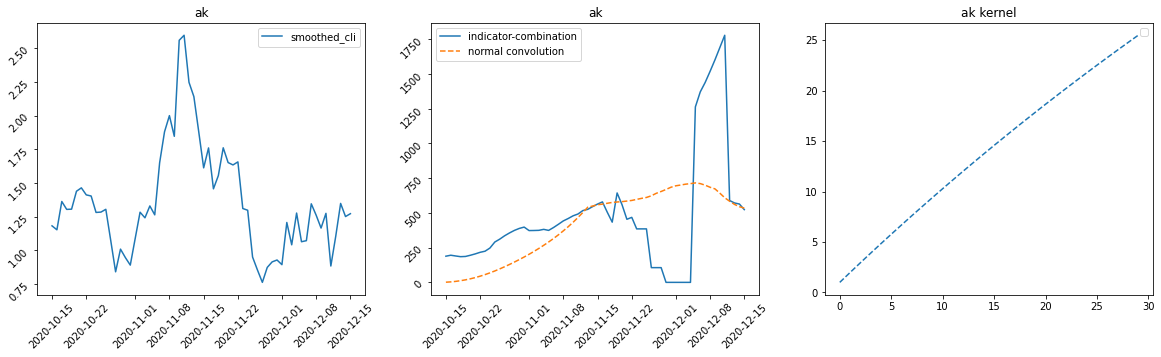

No handles with labels found to put in legend.


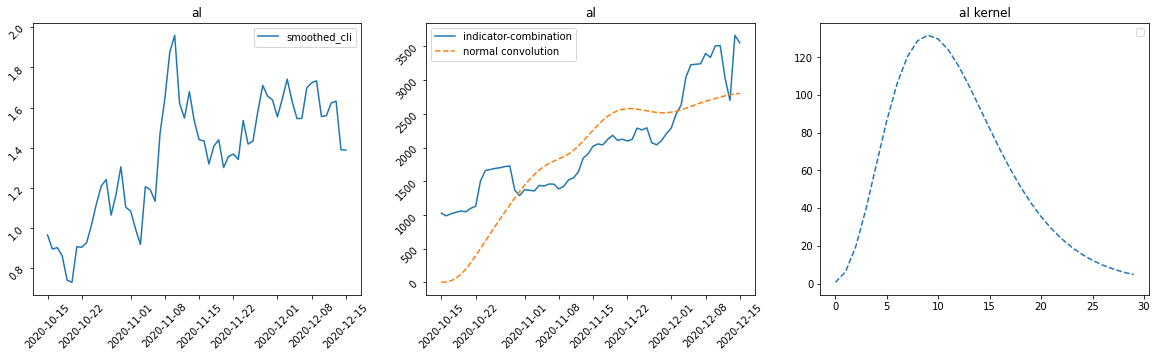

No handles with labels found to put in legend.


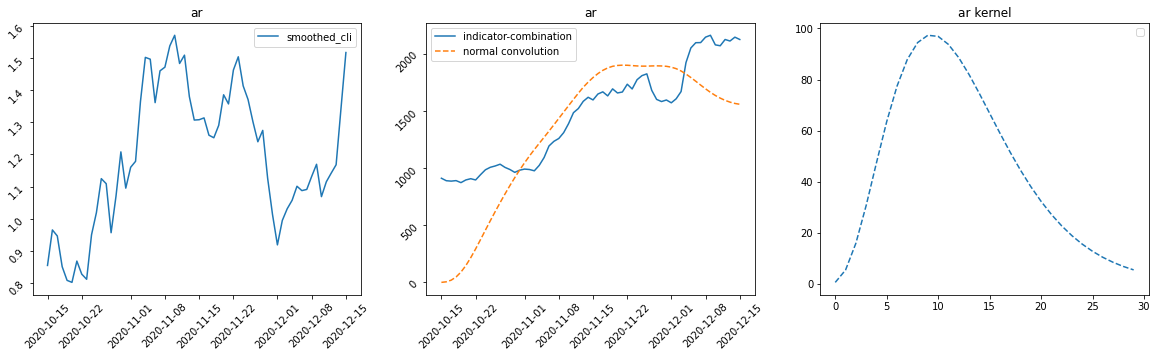

No handles with labels found to put in legend.


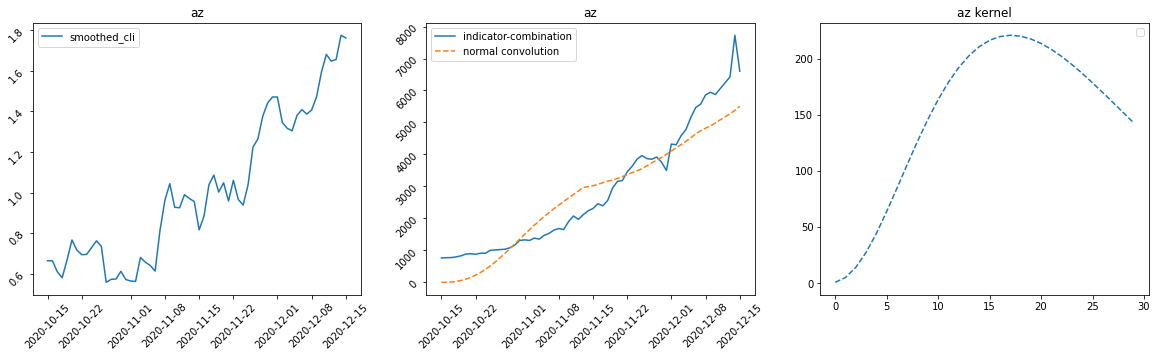

No handles with labels found to put in legend.


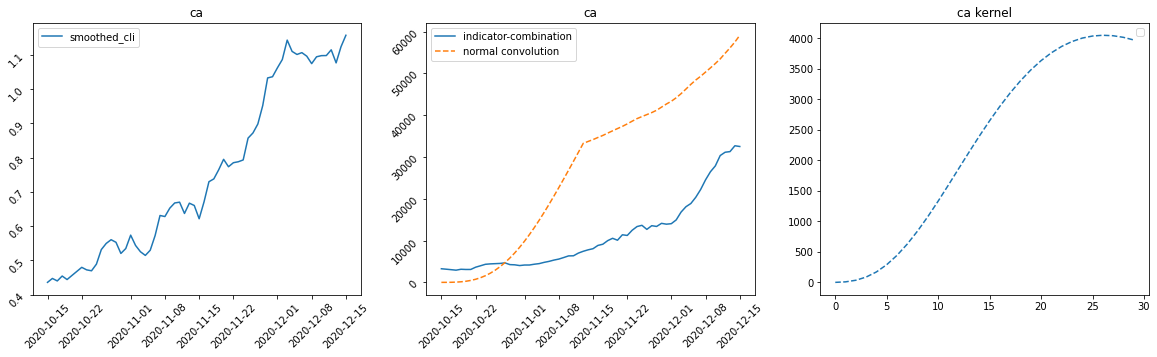

No handles with labels found to put in legend.


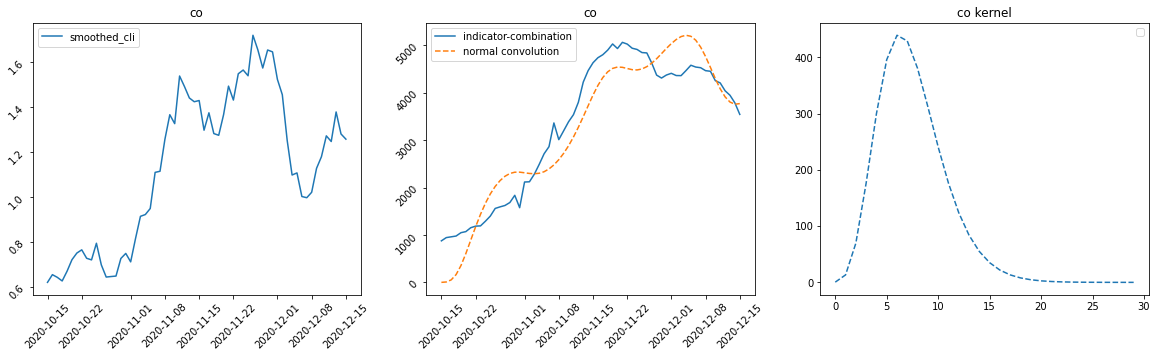

No handles with labels found to put in legend.


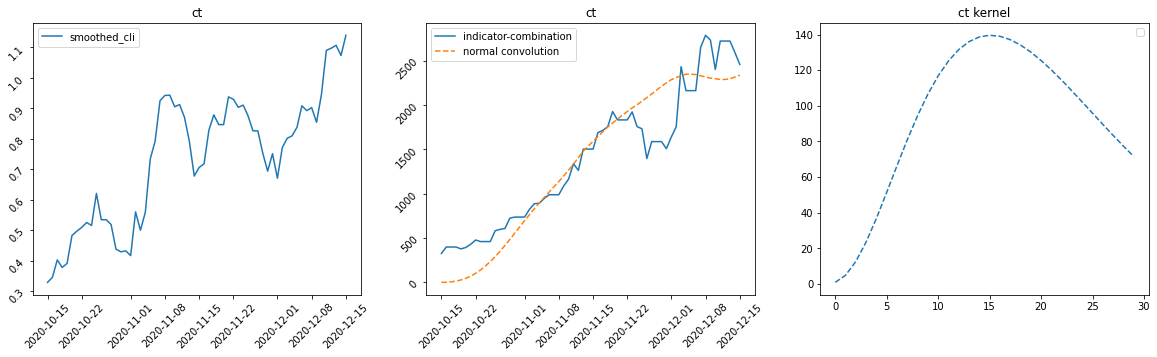

No handles with labels found to put in legend.


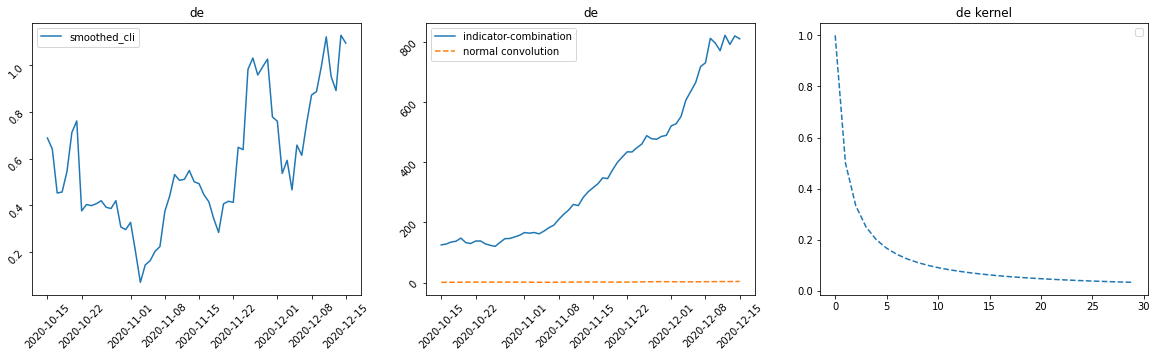

No handles with labels found to put in legend.


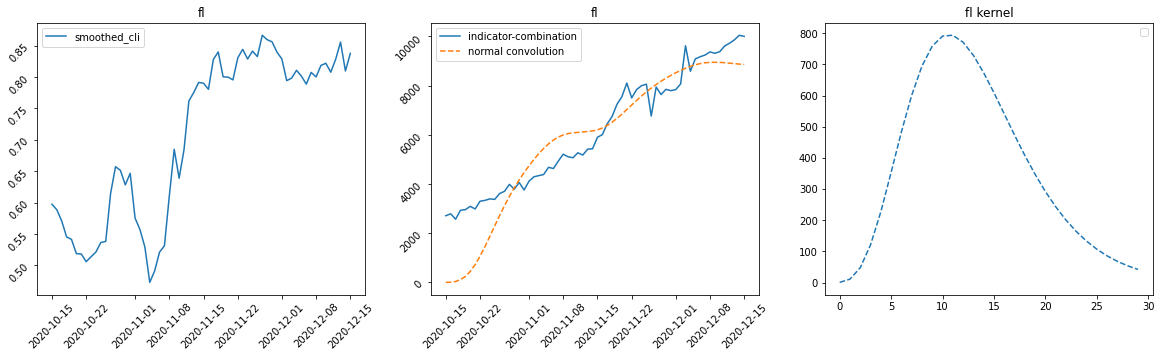

No handles with labels found to put in legend.


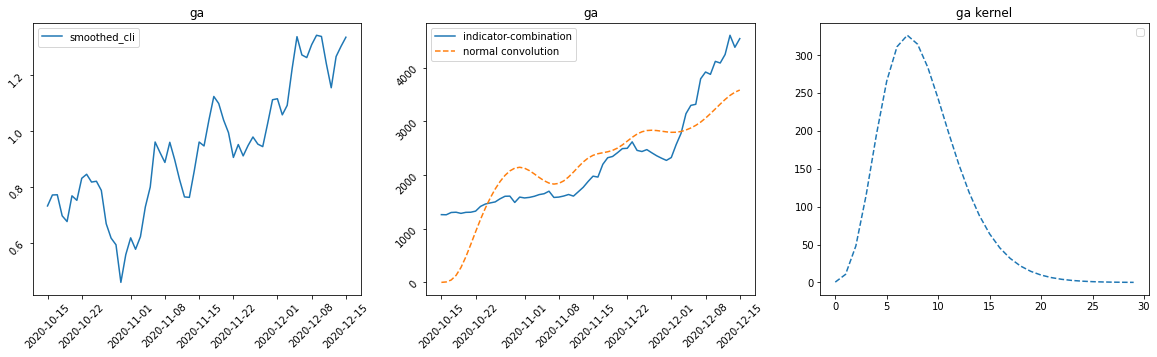

No handles with labels found to put in legend.


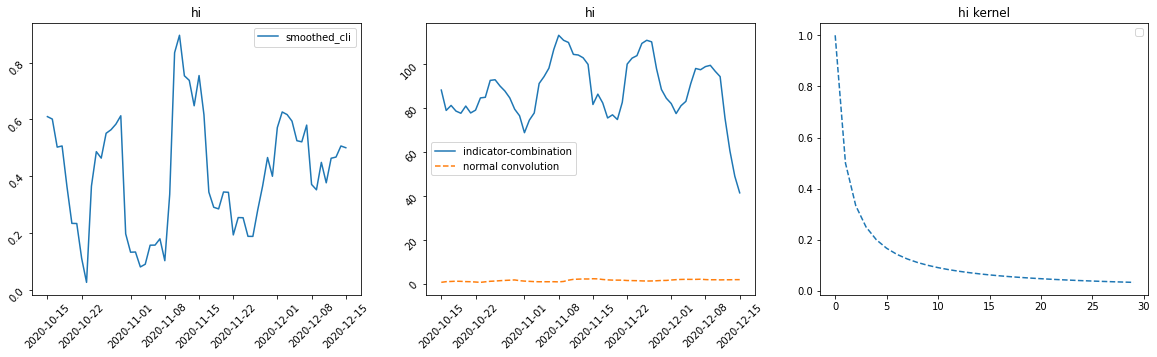

No handles with labels found to put in legend.


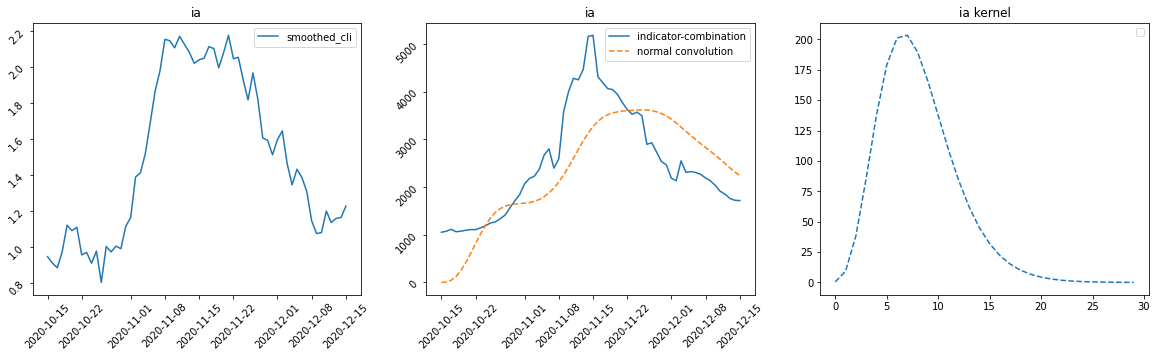

No handles with labels found to put in legend.


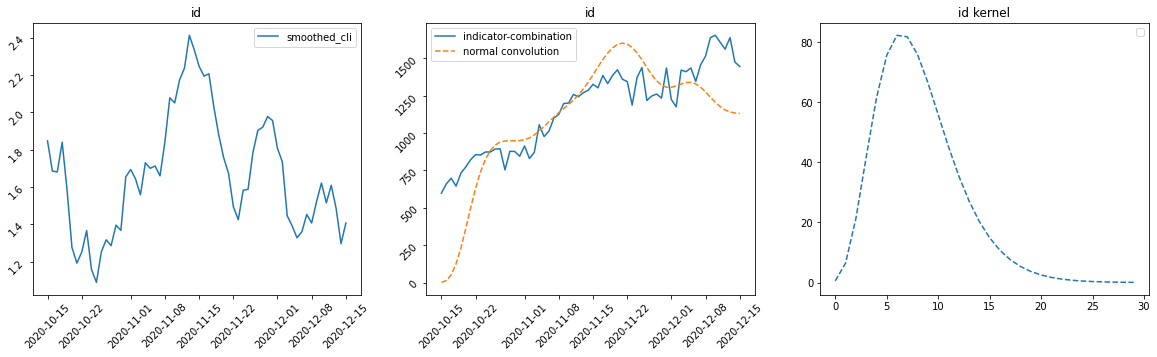

No handles with labels found to put in legend.


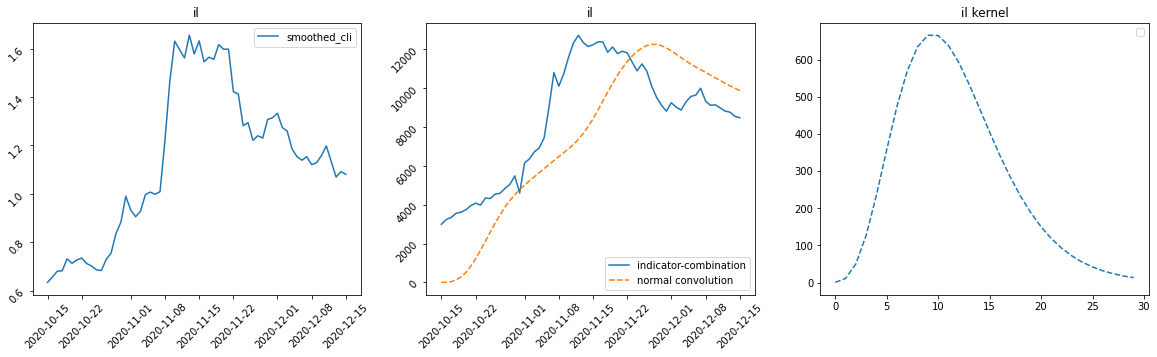

No handles with labels found to put in legend.


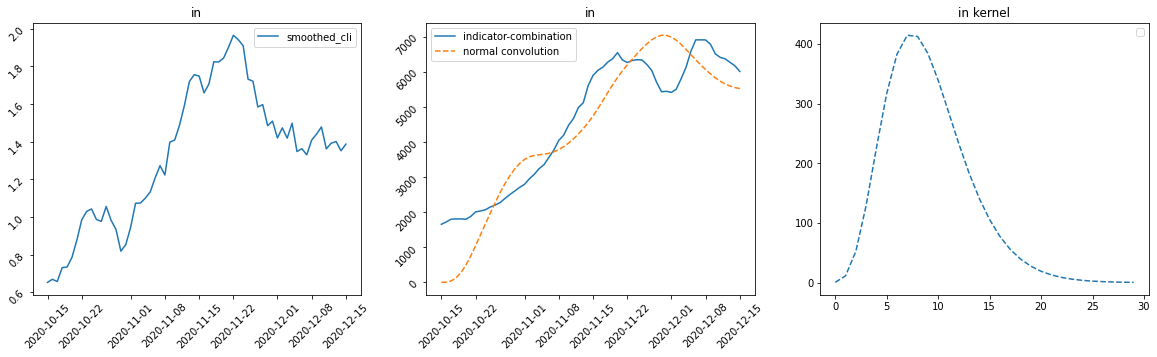

No handles with labels found to put in legend.


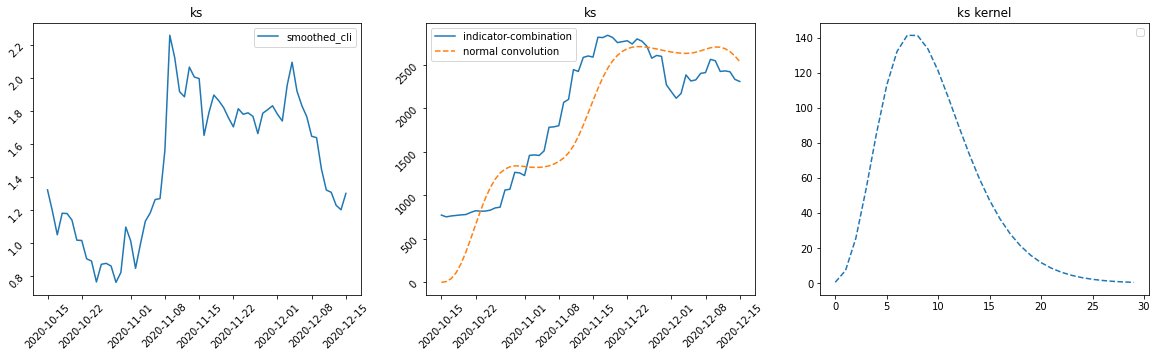

No handles with labels found to put in legend.


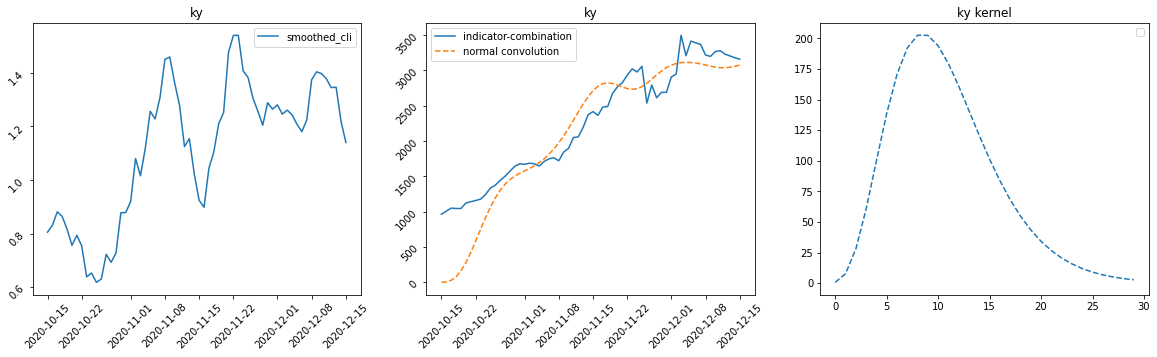

No handles with labels found to put in legend.


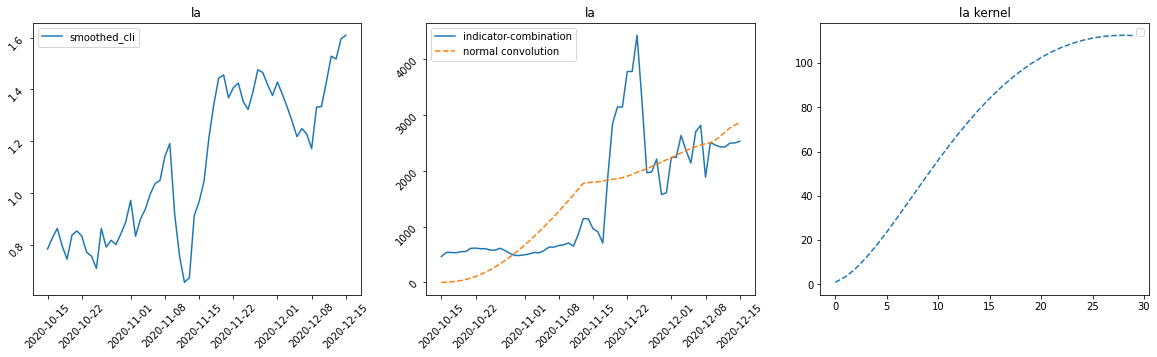

No handles with labels found to put in legend.


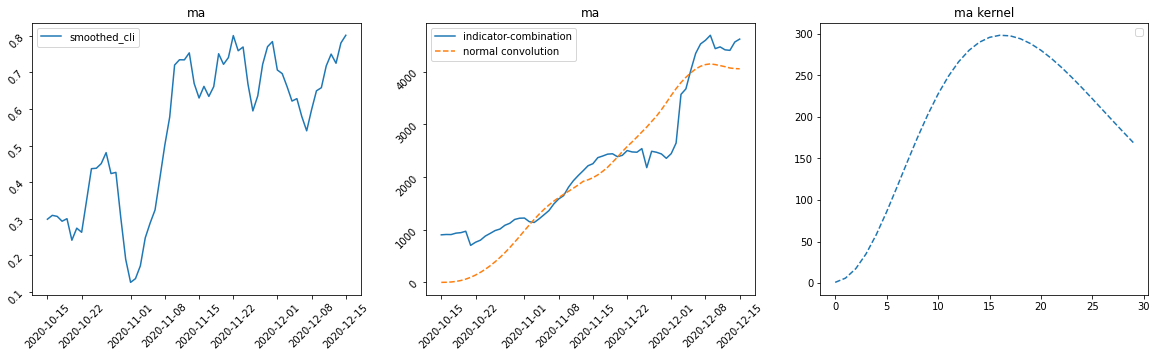

No handles with labels found to put in legend.


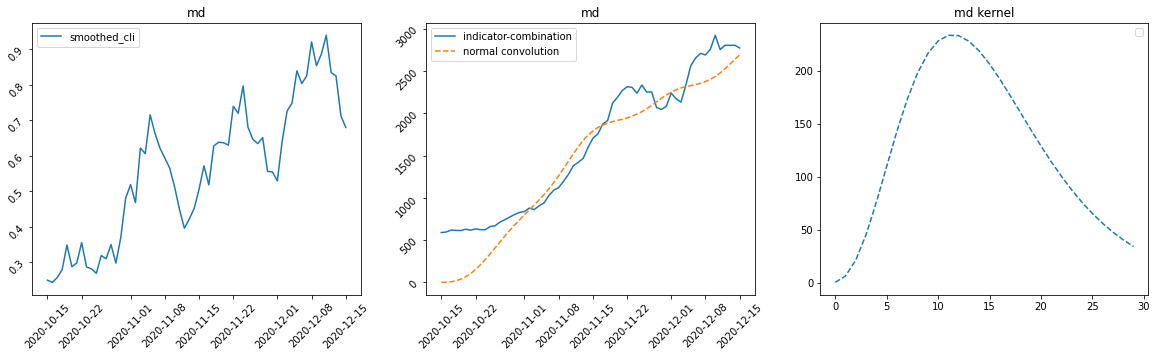

No handles with labels found to put in legend.


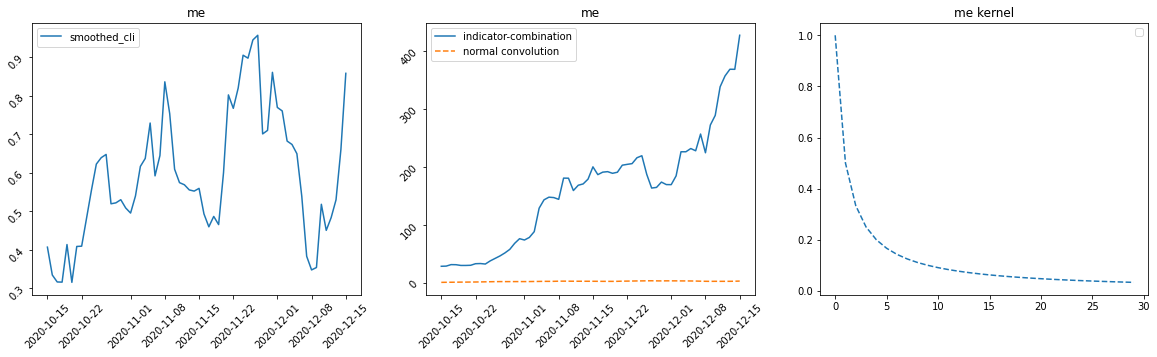

No handles with labels found to put in legend.


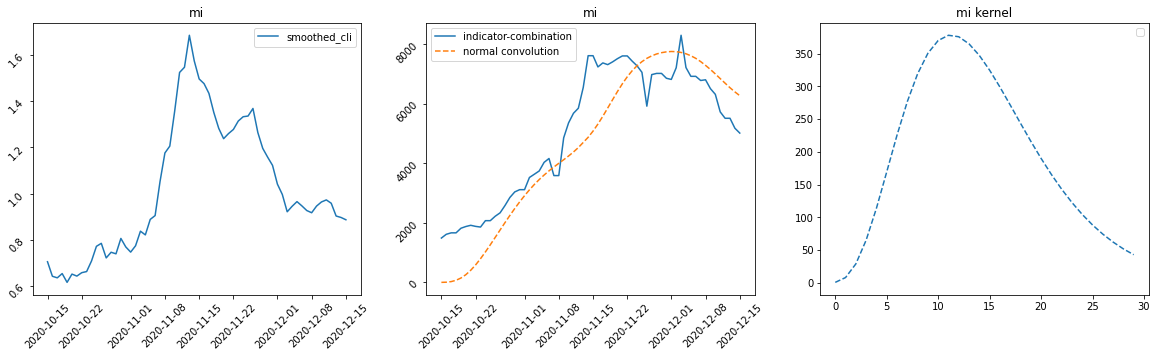

No handles with labels found to put in legend.


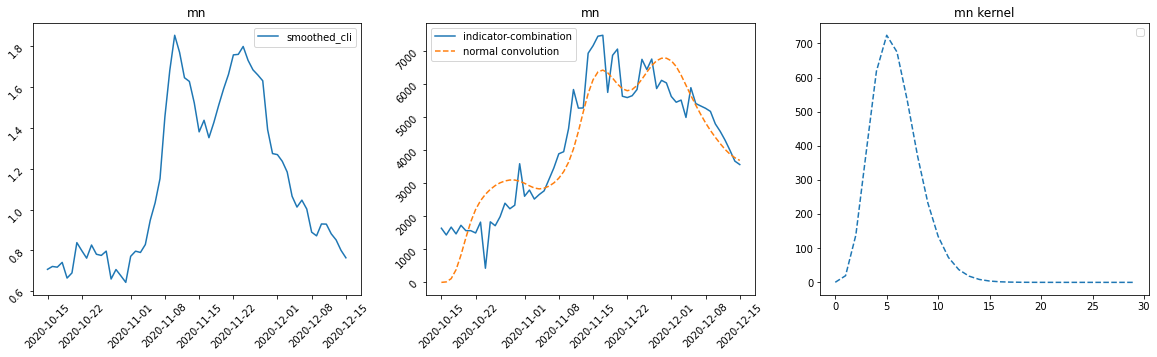

No handles with labels found to put in legend.


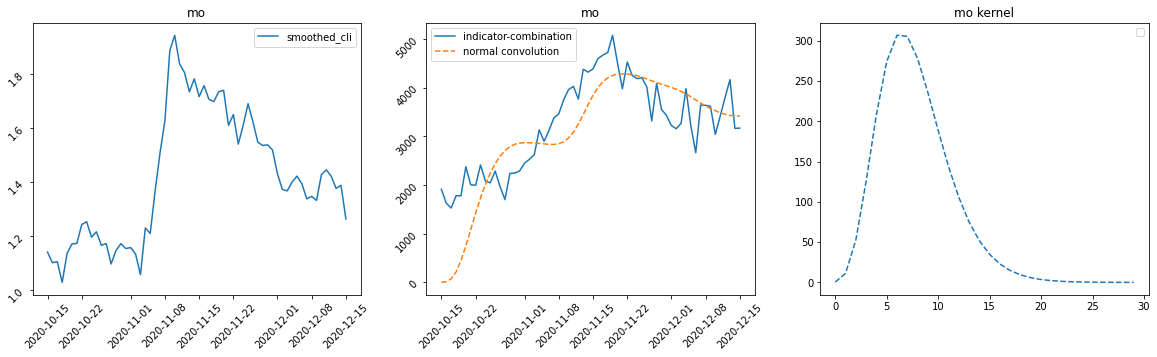

No handles with labels found to put in legend.


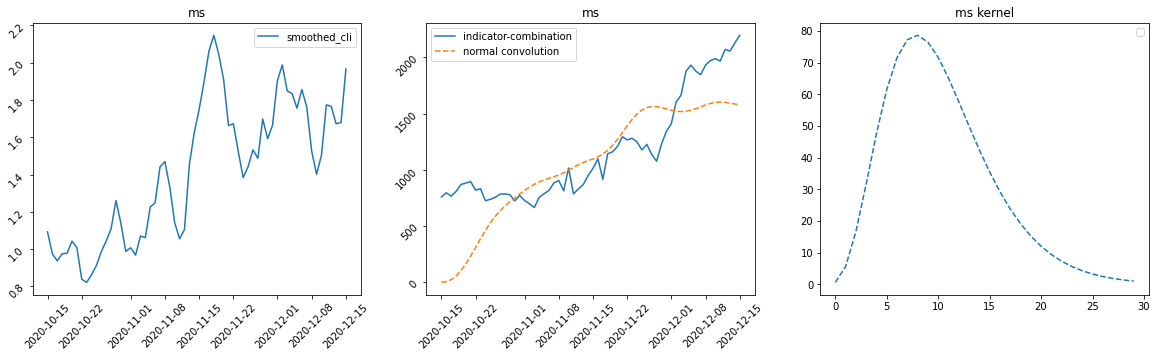

No handles with labels found to put in legend.


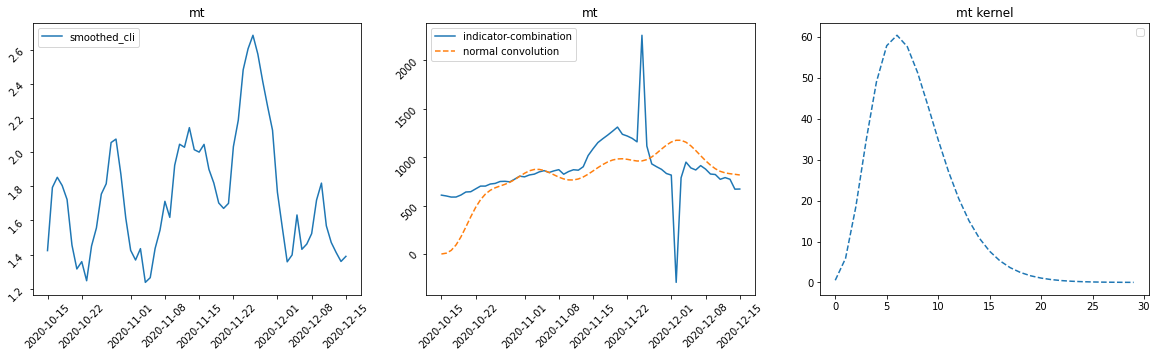

No handles with labels found to put in legend.


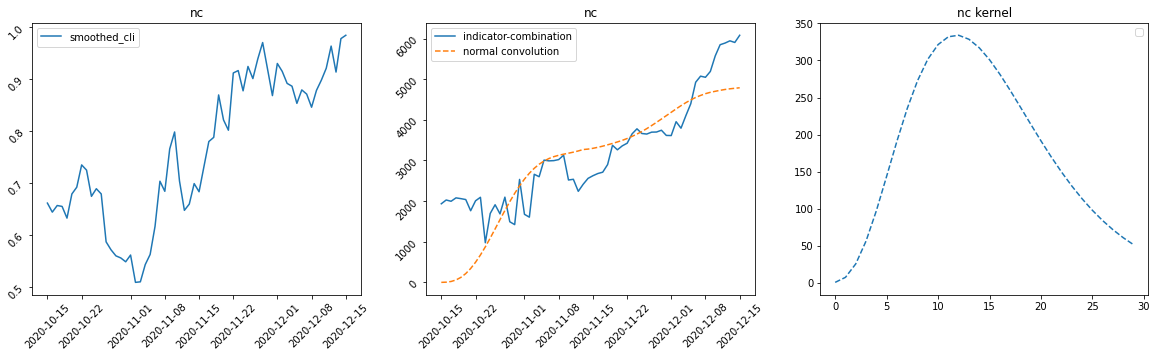

No handles with labels found to put in legend.


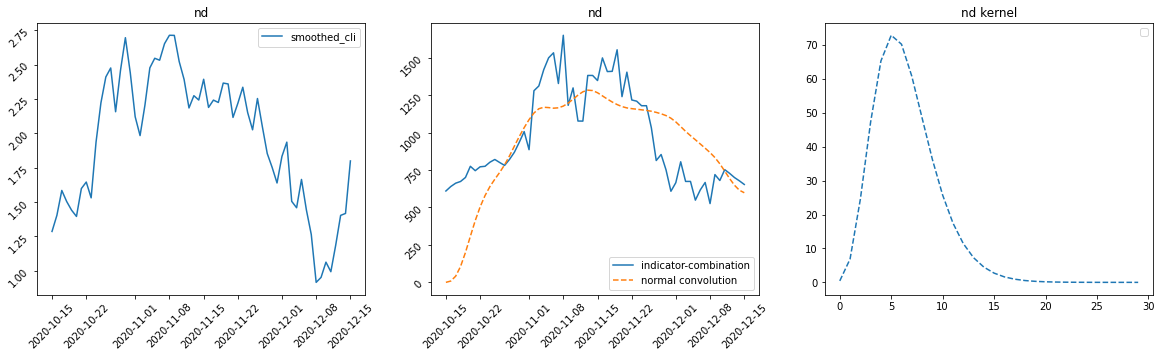

No handles with labels found to put in legend.


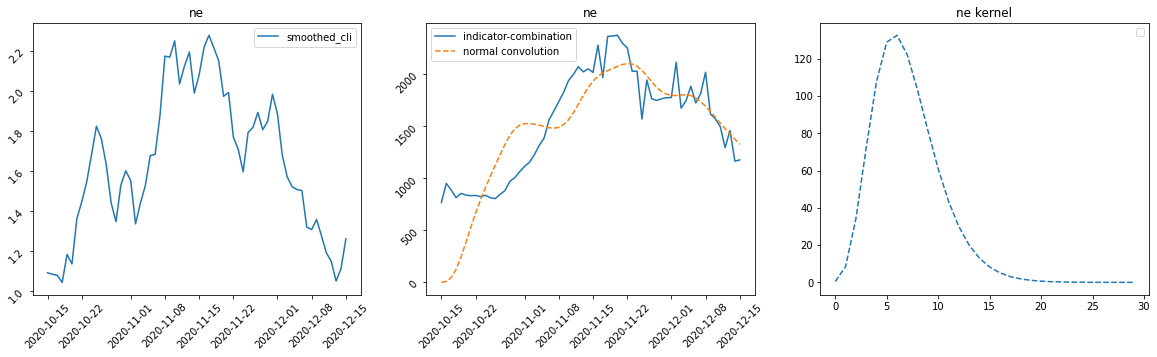

No handles with labels found to put in legend.


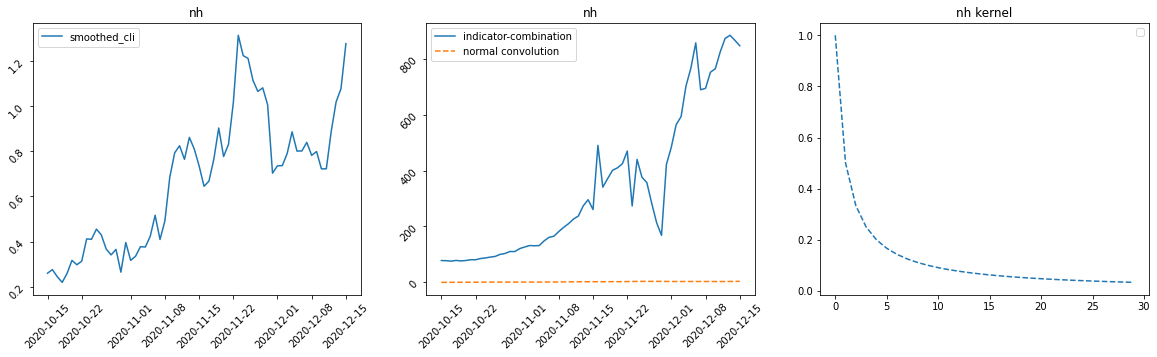

No handles with labels found to put in legend.


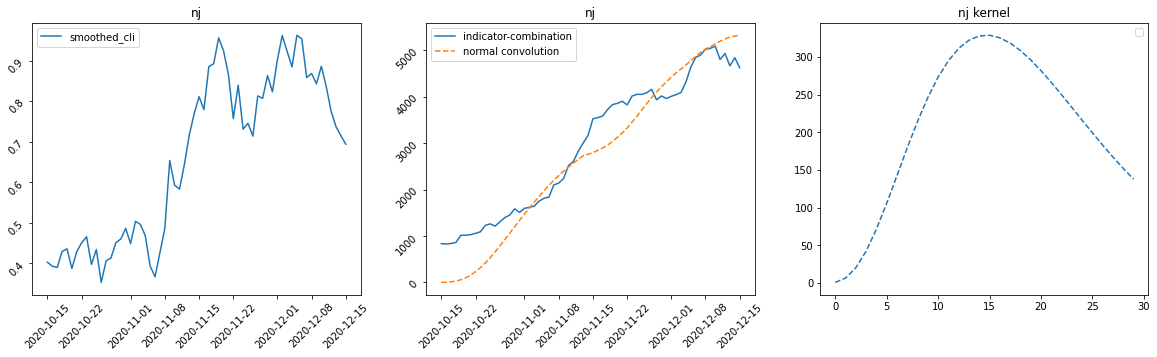

No handles with labels found to put in legend.


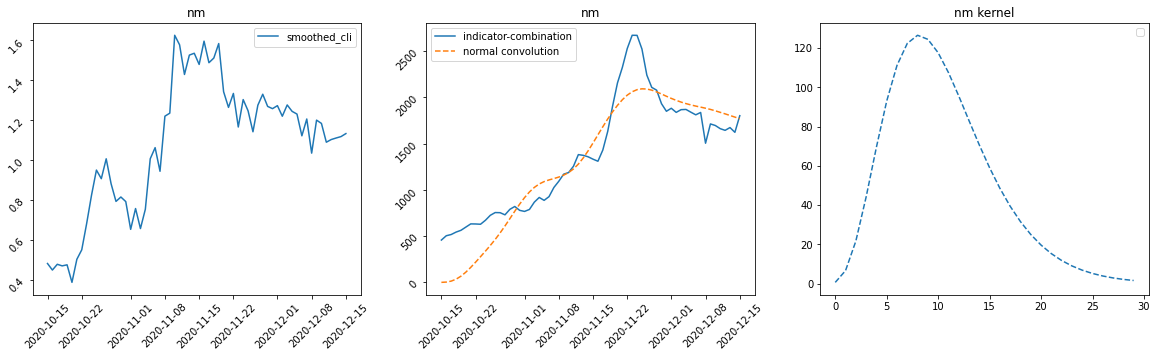

No handles with labels found to put in legend.


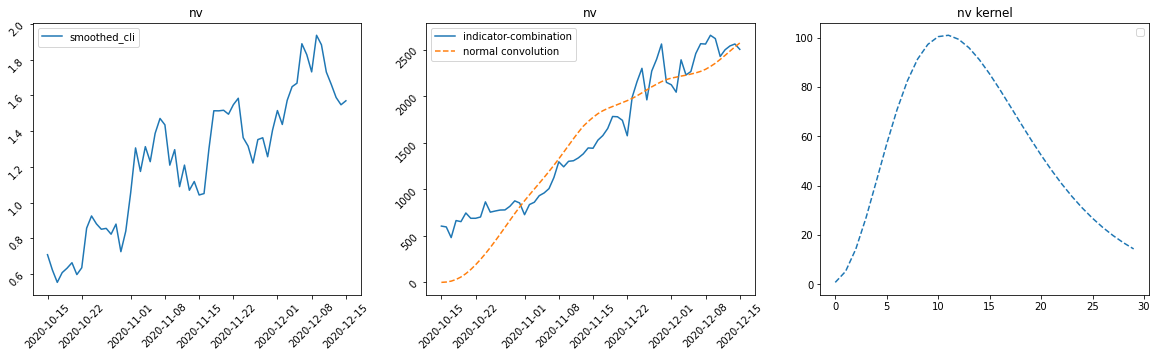

No handles with labels found to put in legend.


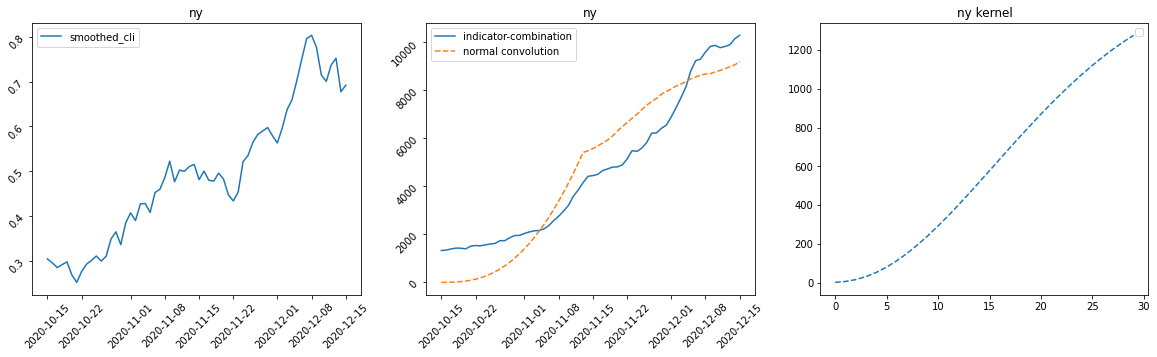

No handles with labels found to put in legend.


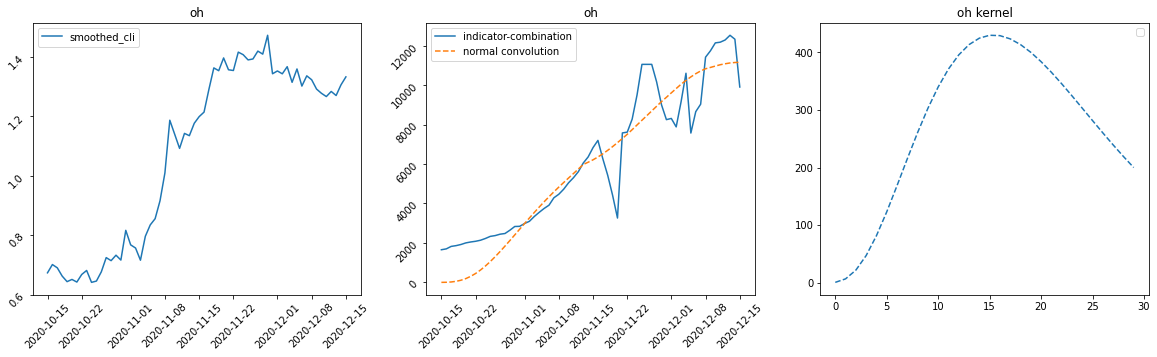

No handles with labels found to put in legend.


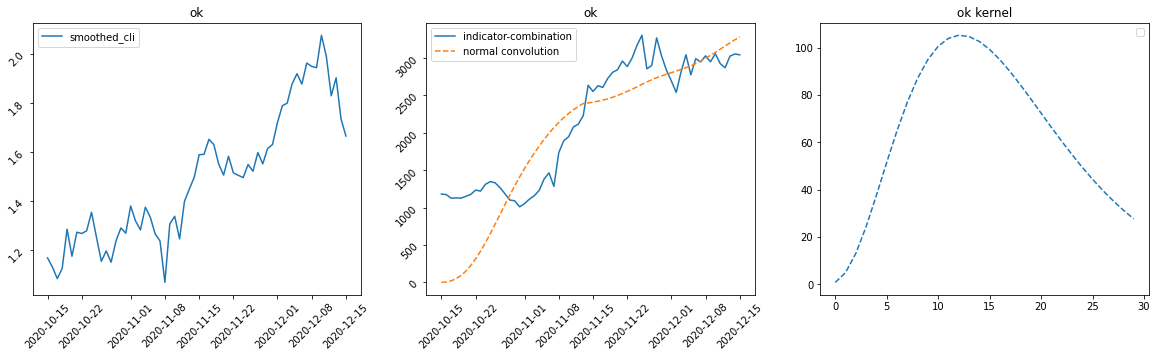

No handles with labels found to put in legend.


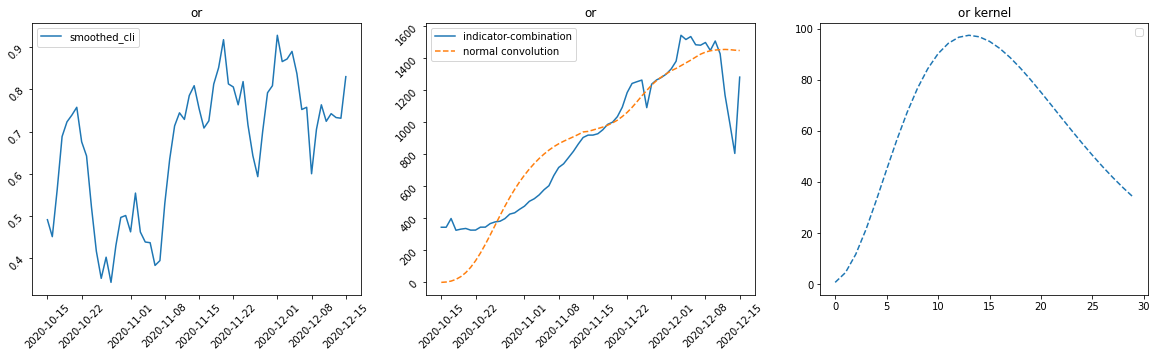

No handles with labels found to put in legend.


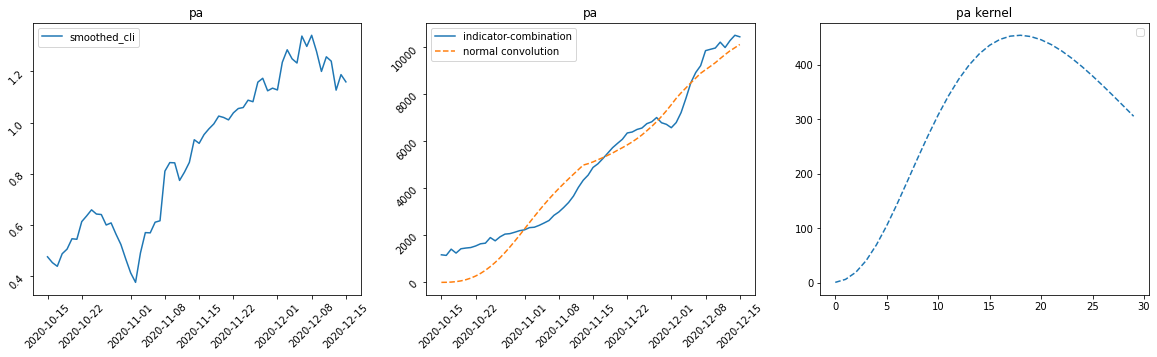

No handles with labels found to put in legend.


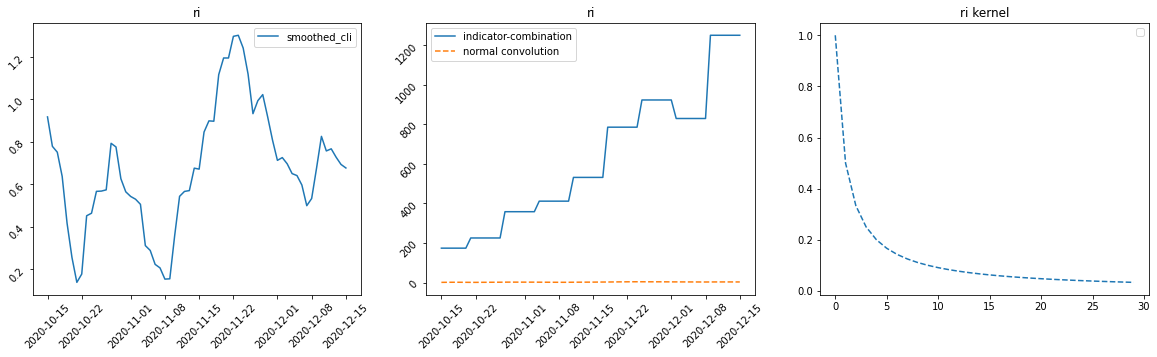

No handles with labels found to put in legend.


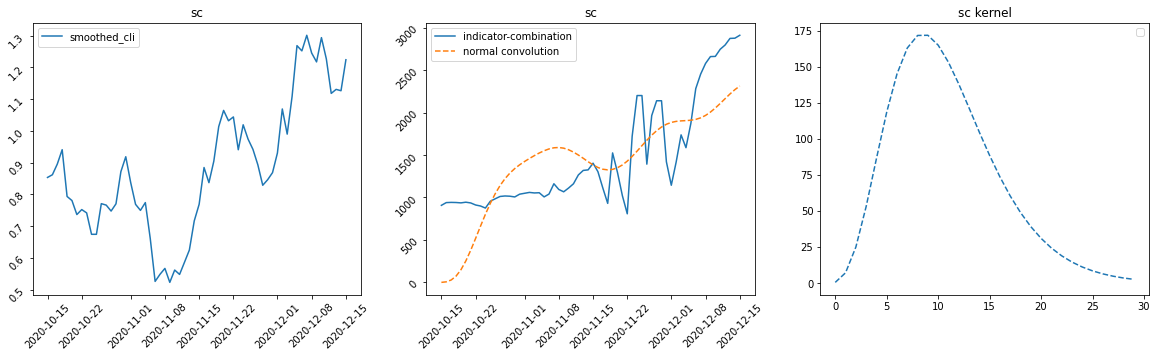

No handles with labels found to put in legend.


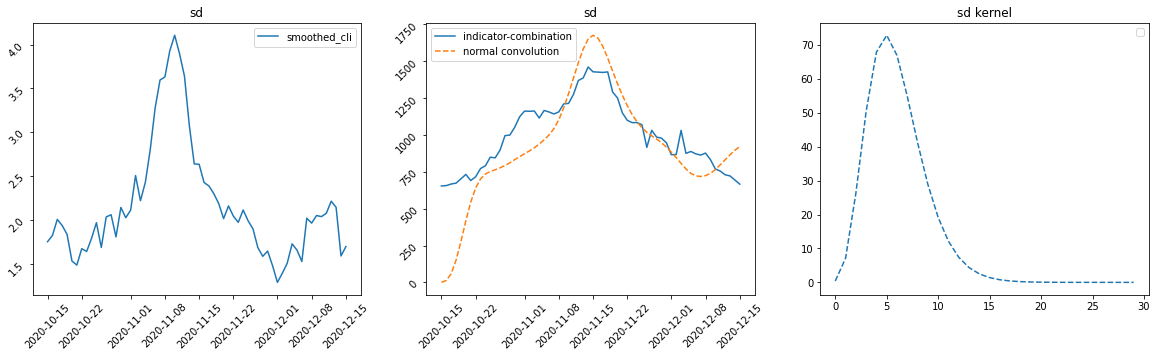

No handles with labels found to put in legend.


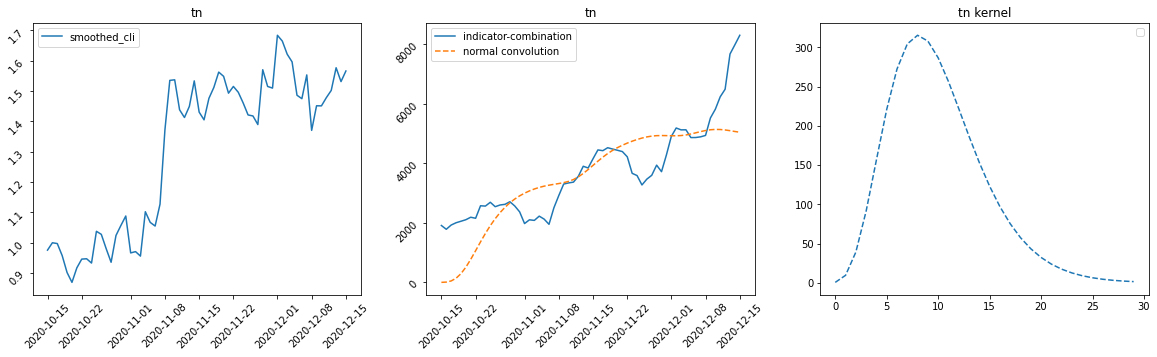

No handles with labels found to put in legend.


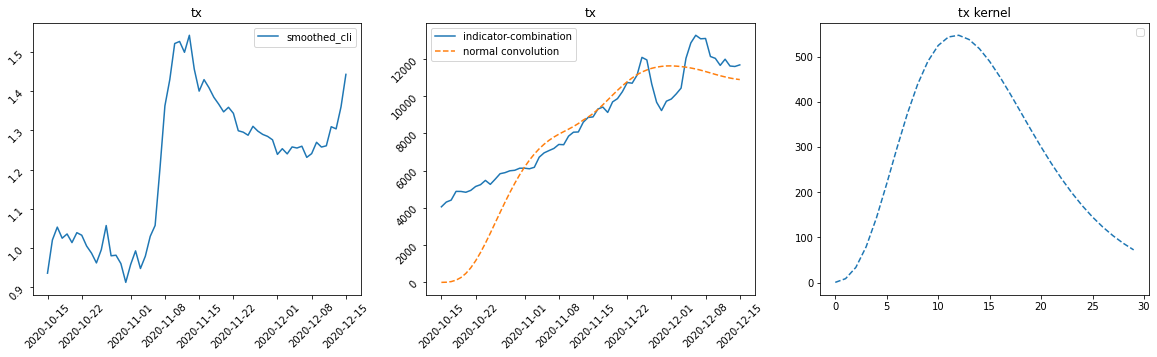

No handles with labels found to put in legend.


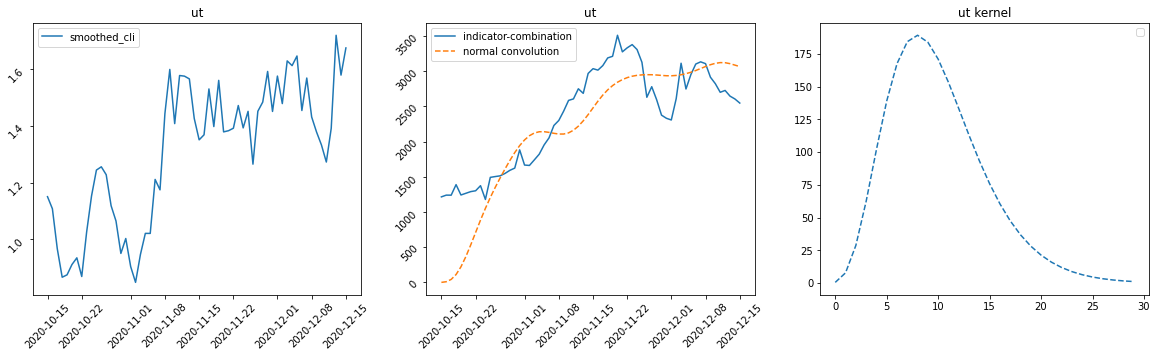

No handles with labels found to put in legend.


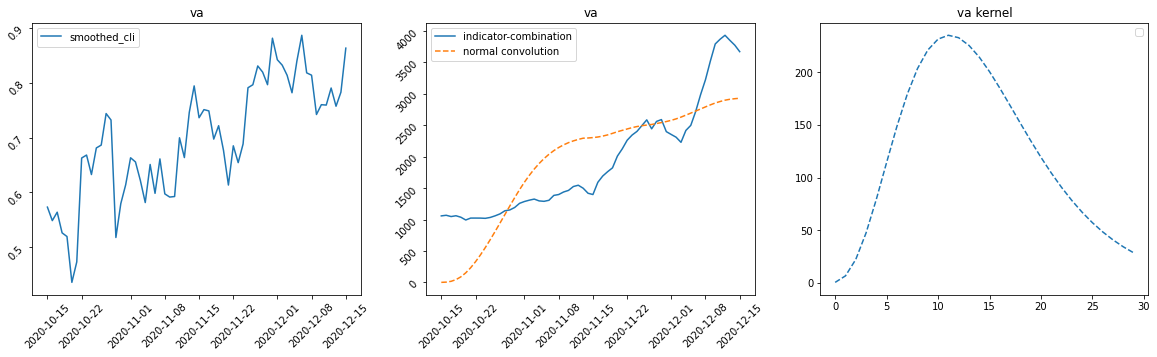

No handles with labels found to put in legend.


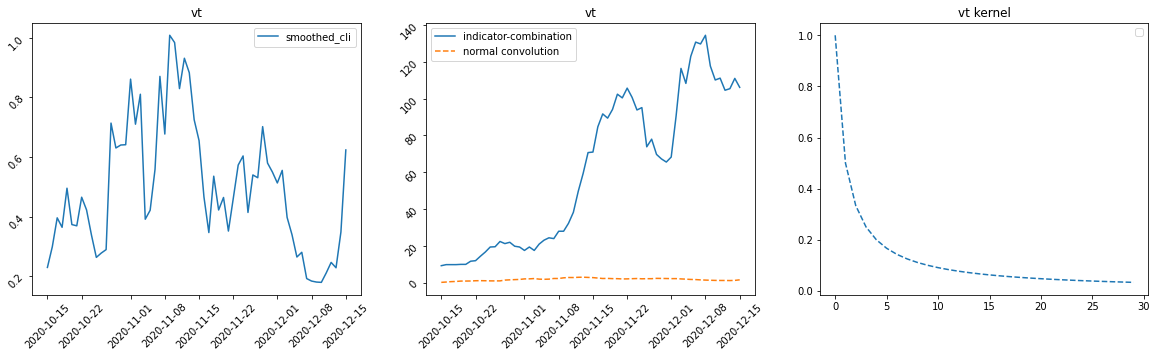

No handles with labels found to put in legend.


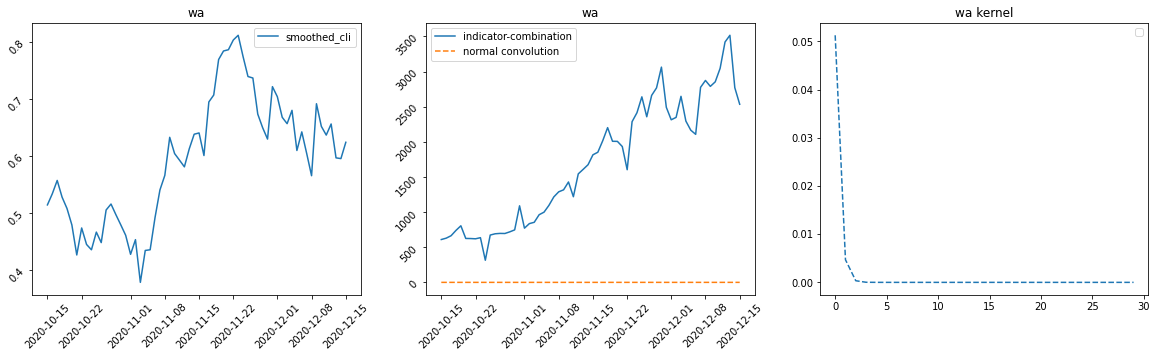

No handles with labels found to put in legend.


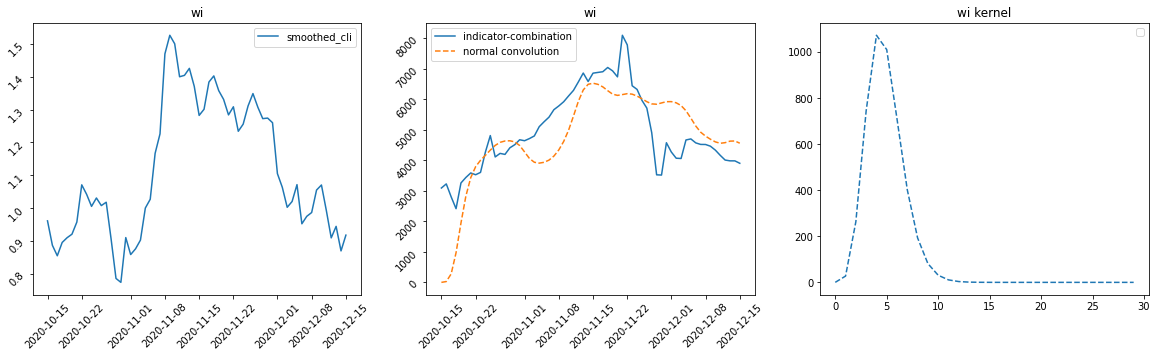

No handles with labels found to put in legend.


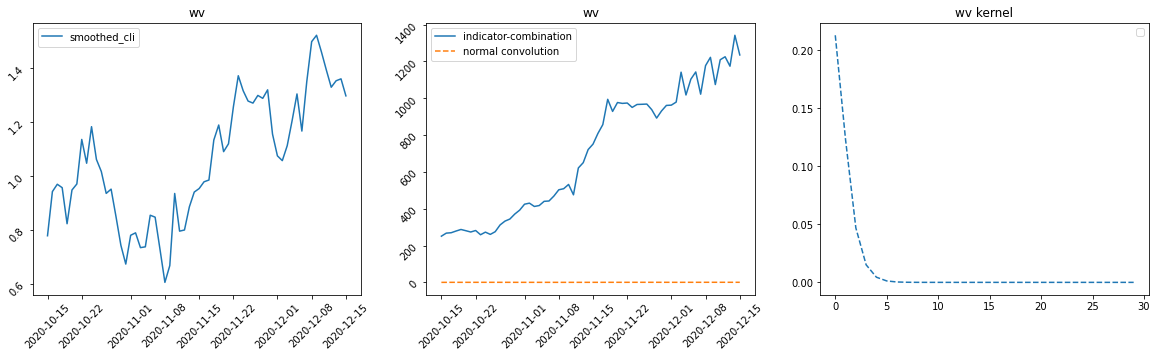

No handles with labels found to put in legend.


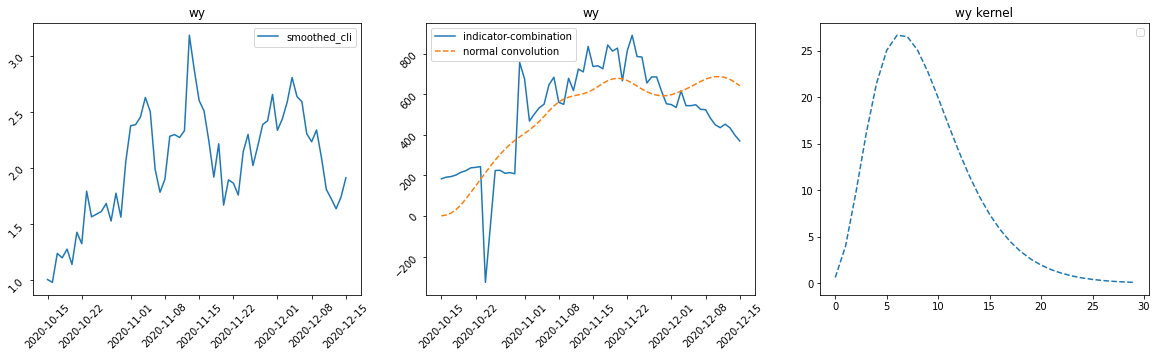

In [31]:
#Evaluation
model_a.load_weights(MODEL_A_PATH).expect_partial() #load best weights from training

dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat_model_a = model_a(X_padded)

for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat_model_a = Y_hat_model_a[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    ax[0].tick_params(labelrotation=45)
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    #ax[1].plot(dates, y_hat_model_b, label='convolution with filter bank [1,0,0,...]', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    ax[1].tick_params(labelrotation=45)
    
    #ax[2].plot(model_a.trainable_variables[i][::-1,0,0], label='normal convolutional kernel', linestyle='--')
    ax[2].plot(get_kernel(model_a,i)[::-1], linestyle='--')
    #ax[3].plot(get_kernel(model_c,i)[::-1], label='filter bank [1,1,0,...]', linestyle='--')
    ax[2].legend()
    ax[2].set_title('{} kernel'.format(states[i]))
    
    plt.show()